<a href="https://colab.research.google.com/github/Ryong1998/snowball/blob/main/1_Data_Understanding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 초기 데이터 수집 보고서

## 1-1. ETF 기본정보 데이터 수집

1. http://data.krx.co.kr/contents/MDC/MAIN/main/index.cmd krx 정보데이터 시스템 사이트 접속
2. '증권상품(좌측메뉴) -> ETF -> 전종목기본정보' 선택
3. 'data > ETF_base_info' 폴더에 다운로드 받은 파일을 저장(파일명 : 전종목기본정보.csv , 2023년 4월 13일 기준)

## 1-2. PDF 데이터 수집(크롤링)

1. 각 ETF를 구성하는 주식들의 비율을 ETF 내 기준에 따라 계속해서 변할 것임으로 각 ETF별 PDF 파일들이 필요
2. ETF를 구성하는 주식들의 비율이 정확히 언제 변하는지 알기 어려움으로, 각 ETF의 매달 첫번째 개장일의 PDF 파일들을 사용할 예정
3. '1. 개장일 추출 -> 2. 매달 첫번째 개장일 조회 -> 3. 해당 일의 PDF 파일 다운' 순으로 진행


### 1-2-1. 개장일 추출

1. http://open.krx.co.kr/contents/MKD/01/0110/01100305/MKD01100305.jsp 사이트로 부터 2015~2023년의 연도별 휴장일들을 추출한뒤 'ETC'폴더에 'krx_holiday.csv' 파일로 저장
2.'krx_holiday.csv'을 활용해서 개장일 들을 구한 다음 'ETC'폴더에 'openDate.csv'파일로 저장

In [ ]:
import pandas as pd

# 휴장일 파일 읽기
holiday_df = pd.read_csv("/content/drive/MyDrive/snowball/data/ETC/krx_holiday.csv")
print(holiday_df.info())
holiday_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    132 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
None


,Date
0,2015-01-01
1,2015-02-18
2,2015-02-19
3,2015-02-20
4,2015-05-01
5,2015-05-05
6,2015-05-25
7,2015-08-14
8,2015-09-28
9,2015-09-29


In [ ]:
# 'Date' 열을 날짜 형식으로 변환
holiday_df['Date'] = pd.to_datetime(holiday_df['Date'])
print(holiday_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    132 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 KB
None


In [ ]:
# 2015년부터 2023년까지의 날짜 범위 생성
date_range = pd.date_range(start='2015-01-01', end='2023-12-31', freq='B')
date_range

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21',
               '2023-12-22', '2023-12-25', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', length=2347, freq='B')

In [ ]:
# 주말 제외
date_range = date_range[date_range.weekday < 5]

# 휴일 제외
date_range = date_range[~date_range.isin(holiday_df['Date'])]

date_range # 주말과 공휴일을 제외해서 개장일들을 생성

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2023-12-14', '2023-12-15', '2023-12-18', '2023-12-19',
               '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-26',
               '2023-12-27', '2023-12-28'],
              dtype='datetime64[ns]', length=2215, freq=None)

In [ ]:
# 날짜로 DataFrame 생성
opening_days_df = pd.DataFrame({'Date': date_range})
print(opening_days_df.info())
opening_days_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2215 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.4 KB
None


,Date
0,2015-01-02
1,2015-01-05
2,2015-01-06
3,2015-01-07
4,2015-01-08


In [ ]:
# DataFrame을 CSV 파일로 저장
opening_days_df.to_csv('/content/drive/MyDrive/snowball/data/ETC/openDate.csv', index=False)

### 1-2-2. '매달 첫번째 개장일 조회' 함수 생성 (by 태현)

1. 시작일자, 끝일자, 월초/월말(택1) 3개의 인자를 input으로 입력하면, '시작일자' 와 '끝일자' 사이에 있는 매달 월초/월말 일자를 list 타입으로 return 해주는 함수
2. 이를 통해서 ETF의 (상장일자, 현재날짜, 0)을 입력하면 그 기간동안 매월 첫번째 날 ETF의 PDF의 정보를 얻을 수 있음

In [ ]:
from dateutil.parser import *
from dateutil.relativedelta import *
from dateutil.rrule import *
import warnings
import time
import pandas as pd
from datetime import datetime
from datetime import timedelta
warnings.simplefilter(action='ignore', category=FutureWarning)  # FutureWaring 제거

opendf = pd.read_csv('/content/drive/MyDrive/snowball/data/ETC/openDate.csv')   # 2002-09-13~2023-03-31까지의 개장일 csv파일 읽기
opendf['Opendate'] = pd.to_datetime(opendf['Date'], format='%Y-%m-%d', errors='raise')  # 원소를 datetime타입으로 변경
datetimeList = []
for date in opendf['Opendate']:
   date = pd.Timestamp(date).strftime('%Y-%m-%d')
   datetimeList.append(datetime.strptime(date, '%Y-%m-%d'))

def getPayInDateInfo(start_date, end_date, month_type):  # month_type으로 월초/월말 선택 (월초: 0, 월말: 1)

    rtList = []

    if month_type == '0':
        a = list(rrule(MONTHLY,
                       byweekday=(MO, TU, WE, TH, FR),
                       bysetpos=1,
                       dtstart=parse(start_date),
                       until=parse(end_date)))  # 지정된 기간의 매월 첫 평일

        for day in a:
            while 1: # 개장일 까지
                if day not in datetimeList:  # 개장일이 아니면
                    day = day + timedelta(days=1) # 하루 +
                else: # 개장일인 경우 빠져나감
                    break
            rtList.append(day.strftime('%Y-%m-%d'))  # yyyy-mm-dd 형식 변환

    elif month_type == '1':
        a = list(rrule(MONTHLY,
                       byweekday=(MO, TU, WE, TH, FR),
                       bysetpos=-1,
                       dtstart=parse(start_date),
                       until=parse(end_date)))  # 지정된 기간의 매월 마지막 평일

        for day in a:
            while 1:  # 개장일 까지
                if day not in datetimeList:  # 개장일이 아니면
                    day = day + timedelta(days=-1)  # 하루 +
                else:  # 개장일인 경우 빠져나감
                    break
            rtList.append(day.strftime('%Y-%m-%d'))  # yyyy-mm-dd 형식 변환

    return rtList  # 납입 예정일 리스트 출력

### 1-2-3. 해당 일의 PDF 파일 다운(by 환룡)

1. 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201030108 사이트 접속 -> 종목명, 조회일자 설정 -> '조회'버튼 클릭 -> '다운로드' 버튼을 클릭하여 csv 파일로 다운' 과정으로 PDF 파일들을 다운로드 함
2. ETF들의 PDF 파일들을 다운로드 받으려면 매우 많은 파일들을 다운로드 해야함
3. 일일히 다운로드를 하기는 어려움으로 크롤링 기법을 사용
4. 동적 웹사이트를 크롤링함으로 selenium 라이브러리 활용
5. 기존에는 사이트를 조회한 후, 사이트의 정보를 스크랩해서 정보를 가져오려 했으나, 스크랩 할 경우 PDF의 모든 데이터를 가져올 수 없어서 PDF파일을 직접 다운로드 하는 식으로 파일을 다운로드
6. 매우 많은 파일들을 조회해서 다운로드 해야 함으로 멀티쓰레딩을 활용해서 크롤링 코드를 작성
7. 파일을 다운로드할 때, 저장되는 파일명이 '랜덤의 파일명'으로 저장이 되서 다운로드한 파일이 어떤 PDF 파일인지 식별이 불가능한 문제 발생 -> Lock()을 활용해서 다운로드한 파일 순서대로 파일명(PDF 파일 식별 가능한 파일명)을 수정하는 기능을 추가
8. 'ad.csv' 파일은 '전종목기본정보.csv' 파일에서 '종목코드'와 '상장일자' 만을 추출한 파일
9. 크롤링한 PDF 파일들은 'data > PDF_files.zip' 으로 저장

10. 해당 코드는 로컬 pc 에서 'vscode' ~~~ 에서 실행을 한 코드, 사용한 'chromedriver.exe' 파일은 'ETC' 폴더에 위치


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# [2022.06.30] find_element_by_() 함수는 find_element(By., ) 과 같은 형태로 함수가 변경됨에 따른 추가 코드
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import os
import shutil
import pandas as pd
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import csv
import threading
import random



# 여기에 PDF 파일을 저장할 폴더의 경로' 수정!!!
Initial_path="/content/drive/MyDrive/snowball/data/PDF_files"

# 크롬 드라이버가 설치된 파일경로 설정
chromedriver = '/content/drive/MyDrive/snowball/data/ETC/chromedriver.exe' # 윈도우

# 파일 다운로드 위치 설정을 위한 코드
chromeOptions = webdriver.ChromeOptions() # 크롬 드라이버 옵션 설정
prefs = {"download.default_directory" : Initial_path} # 파일다운로드 경로 설정
chromeOptions.add_experimental_option("prefs",prefs) # 옵션 정의

# 크롤링하는 기능을 함수로 선언
def crawling_selenium(product_code,product_date):
    driver_chrome = webdriver.Chrome(service=Service(chromedriver), options=chromeOptions)  # 설정 반영
    driver_chrome.get("http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201030108") # 웹사이트 접속

    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)


    # 금융상품명 검색 버튼 클릭
    search_btn = driver_chrome.find_element(By.ID, 'btnisuCd_finder_secuprodisu1_0') # 검색 태그 선택
    search_btn.click() # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    # 금융상품코드를 통해서 금융상품 선택
    search_bar = driver_chrome.find_element(By.CSS_SELECTOR,'#searchText__finder_secuprodisu1_0') # 검색 창 선택
    search_bar.clear()
    search_bar.send_keys(product_code)
    search_bar.send_keys(Keys.RETURN)
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)


    # 조회날짜 선택
    elem = driver_chrome.find_element(By.ID, 'trdDd') # 검색 태그 선택
    for _ in range(8):
        elem.send_keys(Keys.BACK_SPACE) # clear() 를 입력하면 조회일자가 이상하게 초기화되기에 backspace로 지우는 과정 추가!
    elem.send_keys(product_date)
    elem.send_keys(Keys.RETURN)
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)


    # 조회 버튼 클릭
    search_btn = driver_chrome.find_element(By.ID, 'jsSearchButton') # 검색 태그 선택
    search_btn.click() # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)


    # 조회 버튼 클릭
    search_btn = driver_chrome.find_element(By.ID, 'jsSearchButton') # 검색 태그 선택
    search_btn.click() # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    # 다운로드 버튼 클릭
    search_btn = driver_chrome.find_element(By.CLASS_NAME, 'CI-MDI-UNIT-DOWNLOAD') # 검색 태그 선택
    search_btn.click() # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)


    product_date = ''.join(product_date.split('-')) # 저장할 '파일명'을 만들기 위해서 변수 선언

    # csv 파일 다운로드 클릭 - Lock()기능 구현
    _lock.acquire() # 락 키 얻음 - 동기화 이슈로 인해서 lock 필요
    search_btn = driver_chrome.find_elements(By.CLASS_NAME, 'ico_filedown') # 검색 태그 선택
    search_btn[1].click() # 태그 클릭
    time.sleep(2)
    # 파일명 수정
    filename = max([Initial_path + "\\" + f for f in os.listdir(Initial_path)],key=os.path.getctime)
    shutil.move(filename,os.path.join(Initial_path,str(product_code)+"_"+product_date+".csv"))
    time.sleep(1)
    # 드라이버 종료
    driver_chrome.quit()

    _lock.release() # 락 키 반환 - 동기화 이슈로 인해서 lock 필요






if __name__ == '__main__':

    # ad.csv 파일이 있는 경로로 수정 필요!
    df = pd.read_csv("/content/drive/MyDrive/snowball/data/ETC/ad.csv")
    code_list = list(df['code'])
    date_list = list(df['date'])
    payinDate_dict_bm = dict()
    # print('after ad.csv')
    for i in range(len(code_list)):
        payinDate_dict_bm[code_list[i]] = getPayInDateInfo(date_list[i],
                                                                       datetime.today().strftime('%Y-%m-%d'), '0')
    product_code_list = []
    product_date_list = []
    for stock_code in payinDate_dict_bm.keys():
        for search_date in payinDate_dict_bm[stock_code]:
            product_code_list.append(stock_code)
            product_date_list.append(search_date)


    _lock = threading.Lock() # lock을 사용하기 위해서 선언
    # max_workers의 개수는 컴퓨터 사양에 맞게 수정
    # max_workers의 개수가 많을 수록 동시에 띄우는 창이 많아짐!
    with ThreadPoolExecutor(max_workers=5) as executor: # 멀티스레드 실행
        # produt_code_list[] 와 product_date_list[] 슬라이싱들은 범위를 같게해서 해야함
        executor.map(crawling_selenium, product_code_list, product_date_list)


## 1-3. ETF 가격 데이터 수집(크롤링) - 수정 필요

- '기간 내 모든 일자(개장 일자들) 조회' -> '모든 일자에 대응하는 모든 ETF 들의 가격'을 추출하는 순서로 진행

#### 1-3-1. '기간 내 모든 일자 조회' 함수 생성(by 태현)

- pd.Timestamp와 'openDate.csv' 파일을 참조해서 기간내 모든 일자들을 추출

In [ ]:
from dateutil.parser import *
from dateutil.relativedelta import *
from dateutil.rrule import *
import warnings
import time
import pandas as pd
from datetime import datetime
from datetime import timedelta
warnings.simplefilter(action='ignore', category=FutureWarning)  # FutureWaring 제거

opendf = pd.read_csv('/content/drive/MyDrive/snowball/data/ETC/openDate.csv')   # 2002-09-13~2023-03-31까지의 개장일 csv파일 읽기
opendf['Opendate'] = pd.to_datetime(opendf['Date'], format='%Y-%m-%d', errors='raise')  # 원소를 datetime타입으로 변경
datetimeList = []
for date in opendf['Opendate']:
   date = pd.Timestamp(date).strftime('%Y-%m-%d')
   datetimeList.append(datetime.strptime(date, '%Y-%m-%d'))


def getDailyDateInfo(start_date, end_date):
    rtList = []

    for day in opendf['Opendate'][start_date:end_date]:
        rtList.append(pd.Timestamp(day).strftime('%Y-%m-%d'))

    return rtList


#### 1-3-2. '모든 일자에 대응하는 모든 ETF 들의 가격' 추출

1. '1-4-2 해당 일의 PDF 파일 다운' 코드를 대부분 참조(사이트와 클릭 태그만 일부분 수정)
2. 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201030101' 홈페이지가 동적 홈페이지 임으로,  셀레니움을 통해 ETF들의 종가를 추출
3. 크폴링한 파일들은 'data > ETF_closing_price.zip' 으로 저장

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
# [2022.06.30] find_element_by_() 함수는 find_element(By., ) 과 같은 형태로 함수가 변경됨에 따른 추가 코드
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
import os
import shutil
import pandas as pd
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor
import csv
import threading
import random

# 필독!!!!!!!!!!!
# 여기에 '파일을 저장할 폴더의 경로' 수정!!!
Initial_path = "/content/drive/MyDrive/snowball/data/ETF_closing_price"

# # 필독!!!!!!!!!!!
# # 크롬 드라이버가 설치된 파일경로 설정
chromedriver ='/content/drive/MyDrive/snowball/data/ETC/chromedriver.exe'  # 윈도우

# 파일 다운로드 위치 설정을 위한 코드
chromeOptions = webdriver.ChromeOptions()  # 크롬 드라이버 옵션 설정
prefs = {"download.default_directory": Initial_path}  # 파일다운로드 경로 설정
chromeOptions.add_experimental_option("prefs", prefs)  # 옵션 정의

def crawling_selenium(product_date):
    driver_chrome = webdriver.Chrome(service=Service(chromedriver), options=chromeOptions)  # 설정 반영
    driver_chrome.get("http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201030101")

    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    # 조회날짜 선택
    elem = driver_chrome.find_element(By.ID, 'trdDd')  # 검색 태그 선택
    for _ in range(8):
        elem.send_keys(Keys.BACK_SPACE)  # clear() 를 입력하면 조회일자가 이상하게 초기화되기에 backspace로 지우는 과정 추가!
    elem.send_keys(product_date)
    elem.send_keys(Keys.RETURN)
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    # 조회 버튼 클릭
    search_btn = driver_chrome.find_element(By.ID, 'jsSearchButton')  # 검색 태그 선택
    search_btn.click()  # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    # 조회 버튼 클릭
    search_btn = driver_chrome.find_element(By.ID, 'jsSearchButton')  # 검색 태그 선택
    search_btn.click()  # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    # 다운로드 버튼 클릭
    search_btn = driver_chrome.find_element(By.CLASS_NAME, 'CI-MDI-UNIT-DOWNLOAD')  # 검색 태그 선택
    search_btn.click()  # 태그 클릭
    # 랜덤으로 sleep
    rand = random.randrange(3, 6)
    time.sleep(rand)

    product_date = ''.join(product_date.split('-'))

    # csv 파일 다운로드 클릭
    _lock.acquire()  # 락 키 얻음 - 동기화 이슈로 인해서 lock 필요
    search_btn = driver_chrome.find_elements(By.CLASS_NAME, 'ico_filedown')  # 검색 태그 선택
    search_btn[1].click()  # 태그 클릭
    time.sleep(2)
    # 파일명 수정
    filename = max([Initial_path + "\\" + f for f in os.listdir(Initial_path)], key=os.path.getctime)
    shutil.move(filename, os.path.join(Initial_path, "ETF_" + product_date + ".csv"))
    time.sleep(1)
    # 드라이버 종료
    driver_chrome.quit()

    _lock.release()  # 락 키 반환 - 동기화 이슈로 인해서 lock 필요


if __name__ == '__main__':
    date_list = getDailyDateInfo('2015-01-01', datetime.today().strftime('%Y-%m-%d')) # ETF 종가 파일 다운받을 날짜 리스트 생성
    print('after create date list')

    _lock = threading.Lock()

    # 필독!!!!
    # max_workers의 개수는 컴퓨터 사양에 맞게 수정하면 됨!! 10개정도로 하면 될듯?
    # max_workers의 개수가 많을 수록 동시에 띄우는 창이 많아짐!
    with ThreadPoolExecutor(max_workers=1) as executor:
        executor.map(crawling_selenium, date_list)


## 1-4. 주식 가격 데이터 수집(크롤링)

1. '1-5.ETF 가격 데이터 수집(크롤링)'와 거의 동일
2. 코드가 거의 동일하기에 추가적으로 코드는 첨부X
3. 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101' 홈페이지에서 '시장구분 - 전체' 주식의 모든 시세 정보를 크롤링
4. 크롤링한 파일들은  Stock_closing_price.zip 으로 저장

## 1-5. DART 재무제표 데이터 수집

### 1-5-1. 파일 다운로드 방법

1. https://dart.fss.or.kr/ 전자공시시스템 사이트 접속
2. OpenDART(위쪽 메뉴) -> 재무정보일괄다운로드(좌측 메뉴) 선택
3. 2015~2022년 재무상태표, 손익계산서, 현금흐름표를 클릭하여 파일들 다운로드
4. 해당 파일들은 zip 파일로 되어 있어서 압축해제 실행
5. 압축 해제한 파일은 'data > Finance_report_txt' 폴더에 저장

### 1-5-2. 저장한 파일 정리

1. 저장한 파일들에서 PL은 손익계산서를, BS는 재무상태표를, CF는 현금흐름표를 의미함
2. Q는 분기를 의미함(1Q는 1분기, 2Q는 2분기)
3. 'Finance_report_txt' 폴더에 있는 각 파일들에 접근하기 위해서는 폴더들을 여러번 왔다갔다 해야 함으로, 파일명을 알기 쉽게 변경해서 손익계산서 파일들은 'PL_report_txt'폴더에, 재무상태표 파일들은 'BS_report_txt'폴더에 복사
4. 'PL_report_txt'에 있는 파일들 중 '_1'은 '손익계산서-별도재무제표', '_2'는 '손익계산서-연결재무제표', '_3'은 '포괄손익계산서-별도재무제표', '_4'는 '포괄손익계산서-연결재무제표' 를 뜻함
5. 'BS_report_txt'에 있는 파일들 중 '_1'은 '재무상태표-별도재무제표', '_2'는 '재무상태표-연결재무제표'를 뜻함


## 1-6. 금융지주회사 재무제표 데이터 수집

1. https://fisis.fss.or.kr/fss/fsiview/indexw.html 금융통계정보시스템 사이트 접속
2. '경영정보(위쪽 메뉴) -> 단순 통계표 조회(하위 메뉴)' 선택
3. '금융지주회사(왼쪽 메뉴) -> 재무현황(중간 메뉴) -> 요약연결재무상태표(부채 및 자본), 요약연결손익계산서, 요약연결현금흐름표'를 각각 클릭해서 데이터 조회
4. 조회기간은 2015년 3월 ~ 2023년 3월, 모든 지주회사 체크
5. 재무상태표는 '부채총계, 자본총계, 자산총계'를 클릭해서 추출한 후 '금융지주 연결재무상태표.xls' 파일로 저장
6. 손익계산서는 '영업수익, 영업이익, 연결당기순이익'를 클릭해서 추출한 후 '금융지주 연결손익계산서.xls' 파일로 저장
7. 현금흐름표는 '영업활동으로 인한 현금흐름, 투자활동으로 인한 현금흐름, 재무활동으로 인한 현금흐름' 를 클릭해서 추출한 후 '금융지주 현금흐름표.xls' 파일로 저장
8. 우리은행의 경우, 2019년 이전의 데이터가 존재하지 않음으로, '경영정보(위쪽 메뉴) -> 단순 통계표 조회(하위 메뉴) -> 국내은(왼쪽 메뉴) -> 재무현황(중간 메뉴) -> 연결재무상태표(부채 및 자본), 연결손익계산서'를 클릭해서 데이터 조회
9. 재무상태표는 '부채총계, 자본총계, 자산총계'를 클릭해서 추출한 후 '우리은행 연결재무상태표.xls'로 저장, 손익계산서는 '영업수익, 영업이익, 연결당기순이익'를 클릭해서 추가적으로 추출한 후 '우리은행 연결손익계산서.xls'로 저장
10. 금융지주회사들은 네이버 증권을 활용해서 주식코드를 찾은 후 '금융지주 주식코드.csv' 파일로 정리하여서 저장
11. 다운로드 받은 파일들은 'Bank_holding' 폴더에 저장


# 2. 데이터 설명 리포트

- 각 정보를 가진 파일들이 여러개가 있음으로 이 단계에서 파일들을 통합하여 하나의 파일로 만들어 'After_raw' 폴더에 파일들을 저장할 예정
- 세부적으로 데이터들을 탐색하는 것이 아닌, 기본적으로 다운로드 받은 파일들이 누락이 된 것이 없는지 확인, 파일 용량의 낭비를 줄이기 위해서 기초적으로 사용할 컬럼 필터링과, raw 파일들의 병합 및 기본 파일 구조 변경에 집중

## 2-1. ETF 기본정보 데이터 설명

### 2-1-1. 원본 데이터 확인

- 다운로드를 받은 '전종목기본정보.csv' 파일의 정보를 확인
- 2023년 10월 20일 조회 기준

In [ ]:
import pandas as pd

df_etf_base = pd.read_csv('/content/drive/MyDrive/snowball/data/ETF_base_info/전종목기본정보.csv', encoding = 'cp949')
print(df_etf_base.info())
df_etf_base.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   표준코드    784 non-null    object 
 1   단축코드    784 non-null    int64  
 2   한글종목명   784 non-null    object 
 3   한글종목약명  784 non-null    object 
 4   영문종목명   784 non-null    object 
 5   상장일     784 non-null    object 
 6   기초지수명   784 non-null    object 
 7   지수산출기관  784 non-null    object 
 8   추적배수    784 non-null    object 
 9   복제방법    784 non-null    object 
 10  기초시장분류  784 non-null    object 
 11  기초자산분류  784 non-null    object 
 12  상장좌수    784 non-null    int64  
 13  운용사     784 non-null    object 
 14  CU수량    784 non-null    int64  
 15  총보수     784 non-null    float64
 16  과세유형    784 non-null    object 
dtypes: float64(1), int64(3), object(13)
memory usage: 104.2+ KB
None


,표준코드,단축코드,한글종목명,한글종목약명,영문종목명,상장일,기초지수명,지수산출기관,추적배수,복제방법,기초시장분류,기초자산분류,상장좌수,운용사,CU수량,총보수,과세유형
0,KR7466810009,466810,BNK BNK 2차전지양극재증권상장지수투자신탁(주식),BNK 2차전지양극재,BNK BNK Secondary Battery Cathode Materials ETF,2023/10/19,iSelect 2차전지양극재 지수,NH투자증권,일반 (1),실물(패시브),국내,주식,750000,비엔케이자산운용,50000,0.395,비과세
1,KR7457930006,457930,BNK BNK 미래전략기술액티브증권상장지수투자신탁(주식),BNK 미래전략기술액티브,BNK BNK Future Strategic Technology Active ETF,2023/06/20,iSelect 미래전략기술 지수 (PR),NH투자증권,일반 (1),실물(액티브),국내,주식,750000,비엔케이자산운용,50000,0.495,배당소득세(보유기간과세)
2,KR7445690001,445690,BNK BNK 주주가치액티브증권상장지수투자신탁(주식),BNK 주주가치액티브,BNK BNK Shareholder Yield Active ETF,2022/10/27,FnGuide 주주가치 지수,FnGuide,일반 (1),실물(액티브),국내,주식,1100000,비엔케이자산운용,50000,0.495,배당소득세(보유기간과세)
3,KR7292340007,292340,DB 마이티 200커버드콜ATM레버리지증권상장지수투자신탁[주식-파생형],마이티 200커버드콜ATM레버리지,DB Mighty KOSPI200 Covered Call ATM Leverage ETF,2018/03/20,코스피 200 커버드콜 ATM 지수,KRX,2X 레버리지 (2),실물(패시브),국내,주식,400000,디비자산운용,100000,0.510,배당소득세(보유기간과세)
4,KR7465780005,465780,DB 마이티 26-09 특수채(AAA)액티브증권상장지수투자신탁[채권],마이티 26-09 특수채(AAA)액티브,DB Mighty 26-09 Special Bond Active ETF,2023/09/21,KAP 26-09 특수채 지수(총수익),한국자산평가(KAP),일반 (1),실물(액티브),국내,채권,730000,디비자산운용,1000,0.060,배당소득세(보유기간과세)


### 2-1-2. 원본 데이터 수정(df_etf_base_info.pkl 파일 생성)

- raw데이터에 있는 모든 정보들을 활용을 하는 것이 아님으로, 필요한 컬럼과, 사용할 record들만 추려서 저장


In [ ]:
# record들을 추릴 때, 사용하기 위해서 필요한 컬럼들의 unique()를 확인
print('추적배수 종류 :', df_etf_base['추적배수'].unique())
print('기초시장분류 종류 :', df_etf_base['기초시장분류'].unique())
print('기초자산분류 종류 :', df_etf_base['기초자산분류'].unique())

추적배수 종류 : ['일반 (1)' '2X 레버리지 (2)' '2X 인버스 (-2)' '1X 인버스 (-1)']
기초시장분류 종류 : ['국내' '국내&해외' '해외']
기초자산분류 종류 : ['주식' '채권' '기타' '혼합자산' '부동산' '원자재' '통화']


- '추적배수'가 '일반 (1)' 이고 '기초시장분류'는 '국내', '기초자산분류'는 '주식'인 record 만을 추림
- '단축코드', '한글종목약명', '상장일, '운용사', 'CU수량'의 컬럼들 만을 추림

In [ ]:
# 사용할 record 만을 추린다음, 사용한 컬럼들의 정보들만을 추림
df_etf_base_after = df_etf_base.loc[(df_etf_base['추적배수']=='일반 (1)')&(df_etf_base['기초시장분류']=='국내')&(df_etf_base['기초자산분류']=='주식'),['단축코드', '한글종목약명', '상장일', '운용사', 'CU수량']].copy()
df_etf_base_after.reset_index(inplace=True, drop=True)
print(df_etf_base_after.info())
df_etf_base_after.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   단축코드    311 non-null    int64 
 1   한글종목약명  311 non-null    object
 2   상장일     311 non-null    object
 3   운용사     311 non-null    object
 4   CU수량    311 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 12.3+ KB
None


,단축코드,한글종목약명,상장일,운용사,CU수량
0,466810,BNK 2차전지양극재,2023/10/19,비엔케이자산운용,50000
1,457930,BNK 미래전략기술액티브,2023/06/20,비엔케이자산운용,50000
2,445690,BNK 주주가치액티브,2022/10/27,비엔케이자산운용,50000
3,442260,마이티 다이나믹퀀트액티브,2022/10/25,디비자산운용,40000
4,159800,마이티 코스피100,2012/07/05,디비자산운용,40000


- '상장일' 컬럼이 날짜의 정보를 가지고 있지만 object 타입이므로 컬럼의 타입을 변경

In [ ]:
# 상장일 열을 date 타입으로 변환
df_etf_base_after['상장일'] = pd.to_datetime(df_etf_base_after['상장일'])

### 2-1-3. 데이터프레임 확인

In [ ]:
print(df_etf_base_after.info())
df_etf_base_after.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   단축코드    311 non-null    int64         
 1   한글종목약명  311 non-null    object        
 2   상장일     311 non-null    datetime64[ns]
 3   운용사     311 non-null    object        
 4   CU수량    311 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 12.3+ KB
None


,단축코드,한글종목약명,상장일,운용사,CU수량
0,466810,BNK 2차전지양극재,2023-10-19,비엔케이자산운용,50000
1,457930,BNK 미래전략기술액티브,2023-06-20,비엔케이자산운용,50000
2,445690,BNK 주주가치액티브,2022-10-27,비엔케이자산운용,50000
3,442260,마이티 다이나믹퀀트액티브,2022-10-25,디비자산운용,40000
4,159800,마이티 코스피100,2012-07-05,디비자산운용,40000


- 만들어진 데이터 프레임은 ETF의 기본 정보들을 알려주는 데이터프레임
- ETF들을 구분하는 '단축코드', ETF의 이름을 알려주는 '한글종목약명', ETF가 상장이 된 날짜인 '상장일', ETF를 운용하는 '운용사, ETF의 몇개의 CU로 구성되어 있는 'CU수량'의 컬럼들로 구성되어 있음
- 'After_raw' 폴더에 'etf_base_info.pkl' 파일로 저장

In [ ]:
df_etf_base_after.to_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_etf_base_info.pkl')

## 2-2. PDF 데이터 설명

### 2-2-1. 원본 데이터 확인

1. pdf 파일의 파일명은 'etf코드_조회날짜.csv'로 되어 있음
2. 각 pdf 파일들은 다음 과 같은 구조로 되어 있음
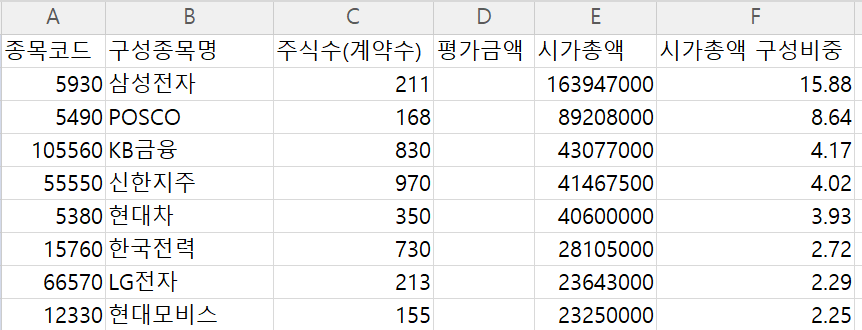

### 2-2-2. 원본 데이터 수정(df_pdf_files.pkl 생성)

- pdf 파일들은 매우 많은 폴더들로 이루어져 있음으로, 하나의 파일로 통합해야 추후 동작 과정에 용이
- 구글 드라이브에서 많은 폴더들을 압축해제 할 경우, 제대로 압축해제가 되지 않아서 로컬pc에서 실행하여 파일을 통합하여 파일을 생성한 후, 통합한 파일을 구글드라이브로 가져와서 실행
- 통합한 파일은 After_raw 폴더에 'df_pdf_files.pkl' 파일로 존재
- 밑에 코드는 로컬 pc에서 실행한 파일

In [ ]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm

path_dir = "C:\\Users\\LG\\Desktop\\졸작\\pdf_files"

file_list = os.listdir(path_dir) # pdf파일 경로에 있는 모든 pdf 파일들 명을 file_list로 저장(33741개의 pdf 파일)

# pdf파일의 etf코드가 'etf_base_info.pkl' 데이터프레임에서 '단축코드'에 대응하는 pdf 파일들만을 거름
pdf_file_list = list() # 걸러진(사용할) pdf 파일들의 파일명들을 담을 리스트
for i, pdf_file in tqdm(enumerate(file_list), total=len(file_list)): # PDF_files 폴더안에 있는 모든 pdf 파일들에 대해서 적용
    df_pdf = pd.read_csv(path_dir+'\\'+pdf_file, encoding='cp949')
    etf_code = int(pdf_file.split('_')[0]) # etf 코드를 추출
    pdf_date = datetime.strptime(pdf_file.split('.')[0].split('_')[1], "%Y%m%d") # pdf 조회 날짜를 추출
    df_pdf['etf_code'] = etf_code # etf_code를 컬럼으로 추가
    df_pdf['pdf_date'] = pdf_date # pdf 조회 날짜를 컬럼으로 추가
    if i ==0:
        df_pdf_concat = df_pdf.copy() # 첫번째 pdf 파일은 데이터프레임으로 초기설정
    else:
        df_pdf_concat = pd.concat([df_pdf_concat, df_pdf]) # 그 다음 pdf 파일들은 초기 데이터프레임에 위아래 병함
df_pdf_concat = df_pdf_concat.reset_index(drop=True)
df_pdf_concat.to_pickle('df_pdf_files.pkl')

### 2-2-3. 데이터프레임 확인

In [ ]:
import pandas as pd
# 로컬 pc에서 생성한 pdf 통합 파일 확인
df_pdf_files = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_pdf_files.pkl')

In [ ]:
df_pdf_files.isnull().sum()

종목코드              0
구성종목명            35
주식수(계약수)     115351
평가금액         790498
시가총액         758822
시가총액 구성비중    913343
etf_code          0
pdf_date          0
dtype: int64

In [ ]:
print(df_pdf_files.info()) # 2536672 개의 row들로 이루어져 있고, 8개의 컬럼으로 이루어져 있음
df_pdf_files.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863706 entries, 0 to 2863705
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   종목코드       object        
 1   구성종목명      object        
 2   주식수(계약수)   float64       
 3   평가금액       float64       
 4   시가총액       float64       
 5   시가총액 구성비중  float64       
 6   etf_code   int64         
 7   pdf_date   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 174.8+ MB
None


,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
0,005930,삼성전자,246.0,NaN,144156000.0,NaN,100910,2008-02-01
1,005490,POSCO,174.0,NaN,88914000.0,NaN,100910,2008-02-01
2,060000,국민은행,749.0,NaN,45988600.0,NaN,100910,2008-02-01
3,055550,신한지주,840.0,NaN,42588000.0,NaN,100910,2008-02-01
4,009540,현대중공업,116.0,NaN,37758000.0,NaN,100910,2008-02-01


In [ ]:
df_pdf_files.tail()

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
2863701,KYG9829N1025,XINYI SOLAR HOLDINGS LTD,3000.0,NaN,NaN,NaN,99140,2023-10-04
2863702,KYG982AW1003,Xpeng inc,744.0,NaN,NaN,NaN,99140,2023-10-04
2863703,KYG9894K1085,ZHONGSHENG GROUP HOLDINGS,510.0,NaN,NaN,NaN,99140,2023-10-04
2863704,KRD010010001,원화현금,NaN,NaN,53505674.0,NaN,99140,2023-10-04
2863705,CASH00000001,설정현금액,NaN,NaN,767123038.0,NaN,99140,2023-10-04


- 만들어진 데이터 프레임은 ETF의 PDF(Portfolio Deposit File) 정보를 가지고 있음
- 한 PDF 파일이 어떤 주식종목들로 구성되어 있는지 나타내는 '종목코드', 해당 주식코드의 종목명을 나타내는 '구성종목명', 한 PDF에서 해당 종목코드의 주식을 몇개 가지고 있는지 나타내는 '주식수(계약수)',해당일자에 있는 PDF내 주식들의 평가금액을 나타내는 '평가금액', 해당일자에 있는 PDF내 주식들의 시가총액을 나타내는 '시가총액', 한 PDF내 금액 중 시가총액 비중을 나타내는 '시가총액 구성비중, PDF의 어떤 ETF에 대응하는지 나타내는 'etf_code', PDF 조회날짜를 나타내는 'pdf_date'의 컬럼들로 이루어져 있음
- 'After_raw' 폴더에 'df_pdf_files.pkl' 파일로 저장

## 2-3. ETF 가격 데이터 설명

### 2-3-1 원본 데이터 확인

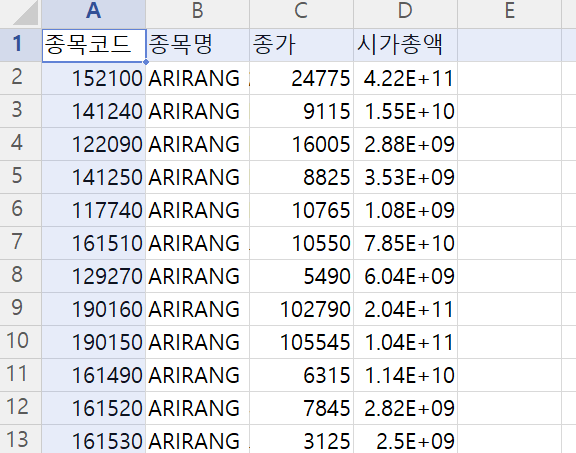

### 2-3-2. 원본 데이터 수정(df_etf_closing_price.pkl 생성)

- etf 가격 파일들은 매우 많은 폴더들로 이루어져 있음으로, 하나의 파일로 통합해야 추후 동작 과정에 용이
- 구글 드라이브에서 많은 폴더들을 압축해제 할 경우, 제대로 압축해제가 되지 않아서 로컬pc에서 실행하여 파일을 통합하여 파일을 생성한 후, 통합한 파일을 구글드라이브로 가져와서 실행
- 통합한 파일은 After_raw 폴더에 'df_etf_closing_price.pkl' 파일로 존재
- 밑에 코드는 로컬 pc에서 실행한 파일

In [ ]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm

path_dir = "C:\\Users\\LG\\Desktop\\졸작\\ETF_closing_price"

file_list = os.listdir(path_dir) # pdf파일 경로에 있는 모든 pdf 파일들 명을 file_list로 저장(33741개의 pdf 파일)

# pdf파일의 etf코드가 'etf_base_info.pkl' 데이터프레임에서 '단축코드'에 대응하는 pdf 파일들만을 거름
etf_file_list = list() # 걸러진(사용할) pdf 파일들의 파일명들을 담을 리스트
for i, etf_file in tqdm(enumerate(file_list), total=len(file_list)): # PDF_files 폴더안에 있는 모든 pdf 파일들에 대해서 적용
    df_etf = pd.read_csv(path_dir+'\\'+etf_file, encoding='cp949')
    etf_date = datetime.strptime(etf_file.split('.')[0], "%Y%m%d") # pdf 조회 날짜를 추출
    df_etf['etf_date'] = etf_date # etf_code를 컬럼으로 추가

    if i ==0:
        df_etf_concat = df_etf.copy() # 첫번째 pdf 파일은 데이터프레임으로 초기설정
    else:
        df_etf_concat = pd.concat([df_etf_concat, df_etf]) # 그 다음 pdf 파일들은 초기 데이터프레임에 위아래 병함
df_etf_concat = df_etf_concat.reset_index(drop=True)

### 2-3-3. 데이터프레임 확인

In [ ]:
import pandas as pd
# 로컬 pc에서 생성한 pdf 통합 파일 확인
df_etf_closing_price = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_etf_closing_price.pkl')
print(df_etf_closing_price.info())
display(df_etf_closing_price.head())
display(df_etf_closing_price.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810846 entries, 0 to 810845
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   종목코드      810846 non-null  int64         
 1    종목명      810846 non-null  object        
 2   종가        810846 non-null  int64         
 3   시가총액      810846 non-null  int64         
 4   etf_date  810846 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 30.9+ MB
None


,종목코드,종목명,종가,시가총액,etf_date
0,152100,ARIRANG 200,24775,422413750000,2015-01-02
1,152100,ARIRANG 200,24730,425356000000,2015-01-05
2,152100,ARIRANG 200,24245,417014000000,2015-01-06
3,152100,ARIRANG 200,24315,413355000000,2015-01-07
4,152100,ARIRANG 200,24640,418880000000,2015-01-08


,종목코드,종목명,종가,시가총액,etf_date
810841,435550,히어로즈 TDF2050액티브,10635,6912750000,2023-11-02
810842,437550,히어로즈 글로벌리츠이지스액티브,8390,5453500000,2023-11-02
810843,419890,히어로즈 단기채권ESG액티브,103930,115362300000,2023-11-02
810844,429870,히어로즈 리츠이지스액티브,6520,4238000000,2023-11-02
810845,454780,히어로즈 종합채권(AA-이상)액티브,98635,76935300000,2023-11-02


- 만들어진 데이터 프레임은 ETF의 종가에 대한 정보를 가지고 있음
- 어떤 etf 코드인지 나타내는 '종목코드', 해당 코드의 한글종목명을 나타내는 '종목명', ETF 한 주당 종가가격을 나타내는 '종가', 해당 일자의 상장된 etf의 전체 종가를 나타내는 '시가총액', 조회날짜의 정보를 나타내는 'etf_date'의 컬럼으로 이루어져 있음
- 'After_raw' 폴더에 'df_etf_closing_price.pkl' 파일로 저장

## 2-4. Stock 가격 데이터 설명

### 2-4-1 원본 데이터 확인

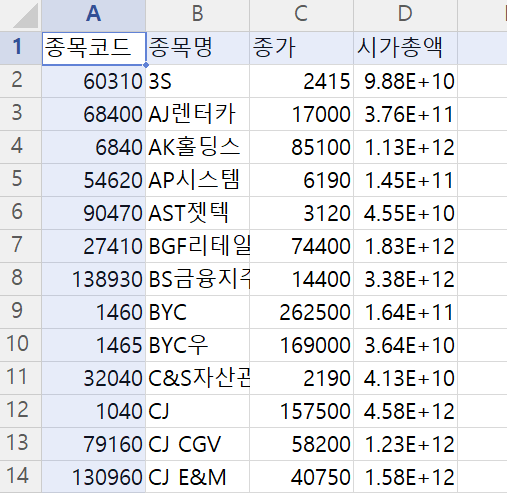

### 2-4-2. 원본 데이터 수정(df_stock_closing_price.pkl 생성)

- stock 가격 파일들은 매우 많은 폴더들로 이루어져 있음으로, 하나의 파일로 통합해야 추후 동작 과정에 용이
- 구글 드라이브에서 많은 폴더들을 압축해제 할 경우, 제대로 압축해제가 되지 않아서 로컬pc에서 실행하여 파일을 통합하여 파일을 생성한 후, 통합한 파일을 구글드라이브로 가져와서 실행
- 통합한 파일은 After_raw 폴더에 'df_stock_closing_price.pkl' 파일로 존재
- 밑에 코드는 로컬 pc에서 실행한 파일

In [ ]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm

path_dir = "C:\\Users\\LG\\Desktop\\졸작\\Stock_closing_price"

file_list = os.listdir(path_dir) # pdf파일 경로에 있는 모든 pdf 파일들 명을 file_list로 저장(33741개의 pdf 파일)

# pdf파일의 etf코드가 'etf_base_info.pkl' 데이터프레임에서 '단축코드'에 대응하는 pdf 파일들만을 거름
stock_file_list = list() # 걸러진(사용할) pdf 파일들의 파일명들을 담을 리스트
for i, stock_file in tqdm(enumerate(file_list), total=len(file_list)): # PDF_files 폴더안에 있는 모든 pdf 파일들에 대해서 적용
    df_stock = pd.read_csv(path_dir+'\\'+stock_file, encoding='cp949')
    stock_date = datetime.strptime(stock_file.split('.')[0].split('_')[-1], "%Y%m%d") # pdf 조회 날짜를 추출
    df_stock['stock_date'] = stock_date # etf_code를 컬럼으로 추가

    if i ==0:
        df_stock_concat = df_stock.copy() # 첫번째 pdf 파일은 데이터프레임으로 초기설정
    else:
        df_stock_concat = pd.concat([df_stock_concat, df_stock]) # 그 다음 pdf 파일들은 초기 데이터프레임에 위아래 병함
df_stock_concat = df_stock_concat.reset_index(drop=True)



### 2-4-3. 데이터프레임 확인

In [ ]:
import pandas as pd
# 로컬 pc에서 생성한 pdf 통합 파일 확인
df_stock_closing_price = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_stock_closing_price.pkl')
print(df_stock_closing_price.info())
display(df_stock_closing_price.head())
display(df_stock_closing_price.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254041 entries, 0 to 254040
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   종목코드        254041 non-null  object        
 1   종목명         254041 non-null  object        
 2   시장구분        254041 non-null  object        
 3   소속부         157698 non-null  object        
 4   종가          254041 non-null  int64         
 5   대비          254041 non-null  int64         
 6   등락률         254041 non-null  float64       
 7   시가          254041 non-null  int64         
 8   고가          254041 non-null  int64         
 9   저가          254041 non-null  int64         
 10  거래량         254041 non-null  int64         
 11  거래대금        254041 non-null  int64         
 12  시가총액        254041 non-null  int64         
 13  상장주식수       254041 non-null  int64         
 14  stock_date  254041 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(9), object(

,종목코드,종목명,시장구분,소속부,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,stock_date
0,060310,3S,KOSDAQ,중견기업부,2415,20,0.84,2395,2450,2385,212450,512299645,98754827220,40892268,2015-01-02
1,068400,AJ렌터카,KOSPI,NaN,17000,700,4.29,16250,17150,16250,117784,1979494550,376487100000,22146300,2015-01-02
2,006840,AK홀딩스,KOSPI,NaN,85100,4900,6.11,81000,85800,80500,82706,6929975900,1127367441100,13247561,2015-01-02
3,054620,AP시스템,KOSDAQ,우량기업부,6190,90,1.48,6140,6310,6130,241484,1498150700,144907658590,23409961,2015-01-02
4,090470,AST젯텍,KOSDAQ,벤처기업부,3120,-75,-2.35,3195,3195,3060,42314,131109315,45545160960,14597808,2015-01-02


,종목코드,종목명,시장구분,소속부,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,stock_date
254036,000540,흥국화재,KOSPI,NaN,3020,-25,-0.82,3060,3060,2990,35418,106465830,194012787900,64242645,2023-10-04
254037,000545,흥국화재우,KOSPI,NaN,5070,70,1.40,5010,5070,5000,257,1288380,3893760000,768000,2023-10-04
254038,003280,흥아해운,KOSPI,NaN,1550,-65,-4.02,1614,1614,1535,415288,646319973,372658593450,240424899,2023-10-04
254039,037440,희림,KOSDAQ,우량기업부,9050,20,0.22,9290,9700,9020,4826919,45358213260,125998398750,13922475,2023-10-04
254040,238490,힘스,KOSDAQ,벤처기업부,5960,-190,-3.09,6150,6250,5950,15091,90383460,67420926560,11312236,2023-10-04


- 만들어진 데이터 프레임은 Stock의 종가에 대한 정보를 가지고 있음
- 어떤 주식종목 코드인지 나타내는 '종목코드', 해당 코드의 한글종목명을 나타내는 '종목명', 주식의 한 주당 종가가격을 나타내는 '종가', 해당 일자의 상장된 주식의 전체 종가를 나타내는 '시가총액', 조회날짜의 정보를 나타내는 'stock_date'의 컬럼으로 이루어져 있음
- 'After_raw' 폴더에 'df_stock_closing_price.pkl' 파일로 저장

## 2-5. Dart 제무제표 데이터 설명

### 2-5-1. 원본 데이터 확인

- 재무 상태표의 경우
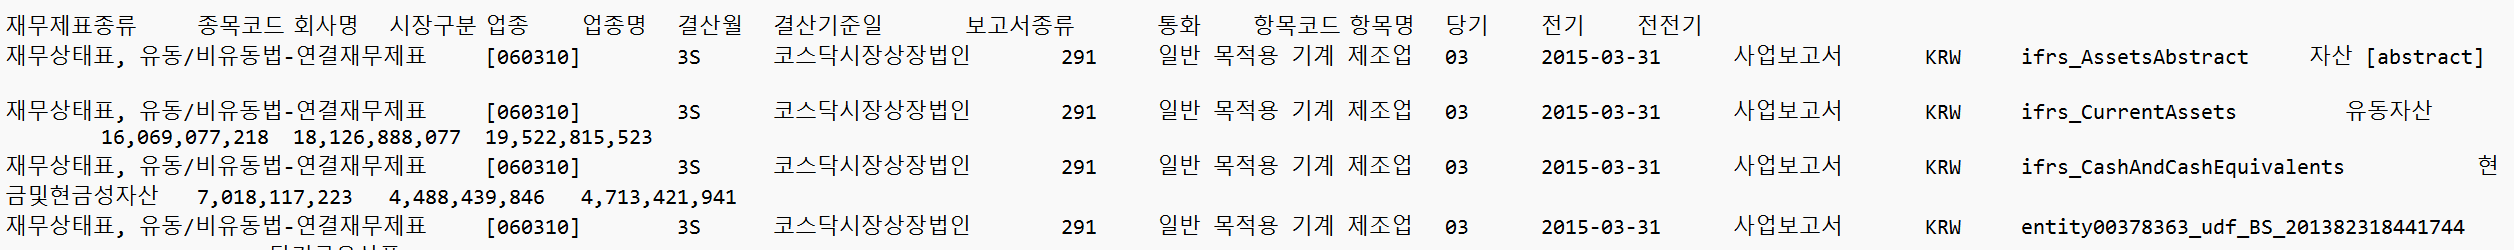
- 손익계산서의 경우
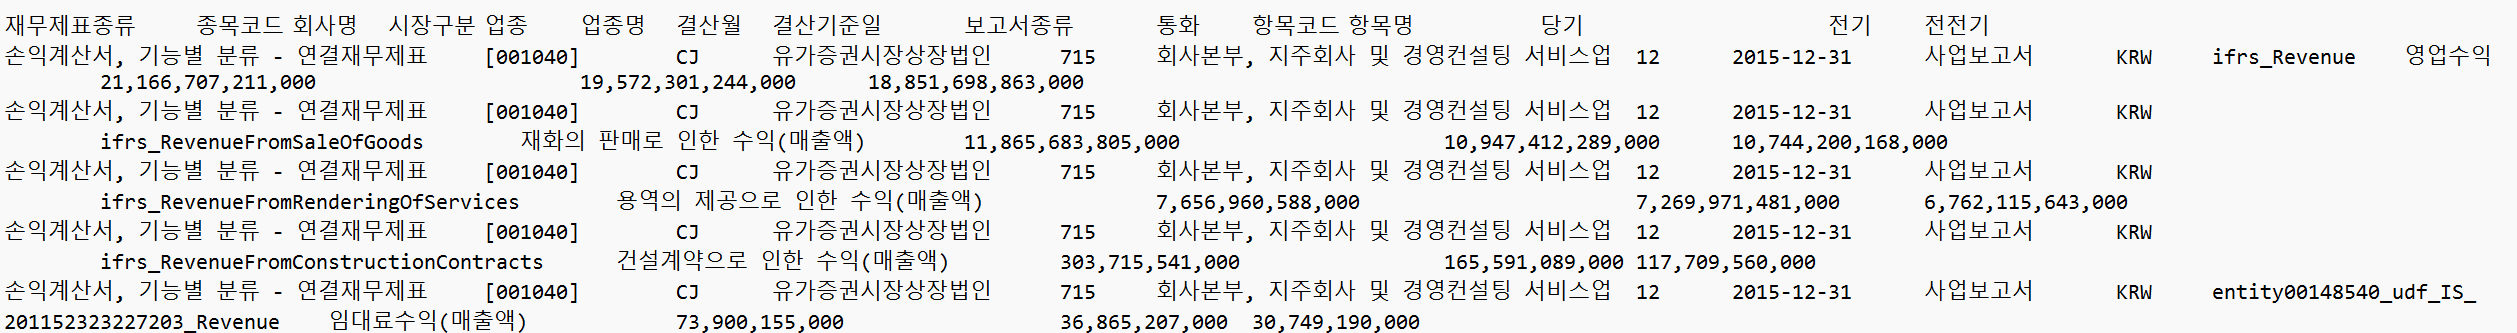
- txt 파일들이어서 추후 전처리에 애로사항이 생김으로, 데이터프레임화를 하여서 병합이 필요

### 2-5-2. 원본데이터 수정

- 재무제표 파일들은 매우 많은 txt 파일들로 이루어져 있음으로, 하나의 pkl 파일로 통합해야 추후 동작 과정에 용이
- 재무상태표와 손익계산서를 구분해서 저장

#### 2-5-2-1. 손익계산서 통합(df_Dart_PL.pkl 생성)

- PL_1 : 손익계산서, 기능별 분류 - 별도재무제표
- PL_2 : 손익계산서, 기능별 분류 - 연결재무제표
- PL_3 : 포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표
- PL_4 : 포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표
- 연결재무제표는 자회사의 정보들을 포함하므로 연결재무제표를 우선시, 자회사가 없는 경우는 별도재무제표에만 있음으로 별도재무제표도 고려, 포괄손익계산서와 손익계산서의 경우는 거의 비슷함으로 우선은 포괄손익계산서를 우선시, 이 모든 경우를 고려하여 PL_4 -> PL_2 -> PL_3 -> PL_1 순서로 중요도를 부여
- 동일한 항목에 다른 값들이 나올 경우, 위에서 파악한 중요도가 중요한 값으로 처리

In [ ]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm

path_dir = "/content/drive/MyDrive/snowball/data/PL_report_txt"

file_list = os.listdir(path_dir) # 손익계산서 txt 파일들 확인

print(len(file_list))

128


In [ ]:
# txt파일들의 컬럼명들을 확인
for file in file_list[:5]:
  df = pd.read_csv(path_dir+"/"+file,delimiter="\t", encoding='cp949') # txt파일 데이터프레임화
  print(df.columns)

Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 3분기 3개월', '당기 3분기 누적', '전기 3분기 3개월',
       '전기 3분기 누적', '전기', '전전기'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 반기 3개월', '당기 반기 누적', '전기 반기 3개월', '전기 반기 누적',
       '전기', '전전기'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 반기 3개월', '당기 반기 누적', '전기 반기 3개월', '전기 반기 누적',
       '전기', '전전기'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 반기 3개월', '당기 반기 누적', '전기 반기 3개월', '전기 반기 누적',
       '전기', '전전기'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 3분기 3개월', '당기 3분기 누적', '전기 3분기 3개월',
       '전기 3분기 누적', '전기', '전전기'],
      dtype='object

- txt 파일별로 데이터프레임화 했을 했을 때, 컬럼들이 통일되지 않고 다름을 확인
- '재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류','통화', '항목코드', '항목명', '당기 1분기 누적', '당기 반기 누적','당기 3분기 누적', '당기'에 속한 컬럼들만 사용할 것
- concat을 사용하기 위해서 '당기 1분기 누적', '당기 반기 누적','당기 3분기 누적', '당기 컬럼들을 '분기누적금액' 컬럼으로 수정
- 누적값을 활용해서, 예상 1년치 실적을 계산해야 하기에 몇 분기까지 누적한 값인지를 알아야 함으로 '분기표시' 컬럼을 추가

In [ ]:
dart_finance_report_columns =['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류','통화', '항목코드', '항목명', '당기 1분기 누적', '당기 반기 누적','당기 3분기 누적', '당기']

for i, file in tqdm(enumerate(file_list), total=len(file_list), desc="Processing PL txt files", unit="file"):
  # 데이터불러오기
  df_column_list = list() #데이터프레임에 사용할 컬럼들을 리스트로 선언
  df_txt = pd.read_csv(path_dir+"/"+file,delimiter="\t", encoding='cp949') # txt파일 데이터프레임화
  df_txt_column_list = list(df_txt.columns) # 불러온 txt파일 데이터프레임의 컬럼들을 추출
  for df_txt_column in df_txt_column_list:
    if df_txt_column in dart_finance_report_columns: # dart_finance_report_columns 에 있는 컬럼들만을 추림
      df_column_list.append(df_txt_column)
  df = df_txt[df_column_list].copy() # 데이터프레임화 한 txt파일, 에서 사용할 컬럼들만을 설정

  # 컬럼수정 및 추가
  if df_column_list[-1] =='당기':
    df.rename(columns = {'당기' : '분기누적금액'}, inplace = True)
    df.loc[:,'분기표시'] = 4
  elif df_column_list[-1] =='당기 3분기 누적':
    df.rename(columns = {'당기 3분기 누적' : '분기누적금액'}, inplace = True)
    df.loc[:,'분기표시'] = 3
  elif df_column_list[-1] =='당기 반기 누적':
    df.rename(columns = {'당기 반기 누적' : '분기누적금액'}, inplace = True)
    df.loc[:,'분기표시'] = 2
  elif df_column_list[-1] =='당기 1분기 누적':
    df.rename(columns = {'당기 1분기 누적' : '분기누적금액'}, inplace = True)
    df.loc[:,'분기표시'] = 1

  df.loc[:, '연도표시'] = int(file.split('_')[0]) # 손익계산서 연도 표시

  # 파일들 통합
  if i == 0:
    df_PL = df.copy()
  else:
    df_PL = pd.concat([df_PL,df])

Processing PL txt files: 100%|██████████| 128/128 [00:56<00:00,  2.28file/s]


In [ ]:
df_PL = df_PL.reset_index(drop=True)
print(df_PL.info())
print(df_PL.isnull().sum())
display(df_PL.head())
display(df_PL.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141339 entries, 0 to 3141338
Data columns (total 15 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   재무제표종류  object
 1   종목코드    object
 2   회사명     object
 3   시장구분    object
 4   업종      int64 
 5   업종명     object
 6   결산월     int64 
 7   결산기준일   object
 8   보고서종류   object
 9   통화      object
 10  항목코드    object
 11  항목명     object
 12  분기누적금액  object
 13  분기표시    int64 
 14  연도표시    int64 
dtypes: int64(4), object(11)
memory usage: 359.5+ MB
None
재무제표종류         0
종목코드           0
회사명            0
시장구분           0
업종             0
업종명            0
결산월            0
결산기준일          0
보고서종류          0
통화             0
항목코드           0
항목명           24
분기누적금액    336319
분기표시           0
연도표시           0
dtype: int64


,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
0,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,ifrs_Revenue,영업수익,"99,202,002,000",3,2016
1,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,ifrs_RevenueFromRoyalties,로열티수익(매출액),"60,229,168,000",3,2016
2,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,ifrs_RevenueFromDividends,배당수익(매출액),"33,081,247,000",3,2016
3,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,entity00148540_udf_IS_2015810134350728_Revenue,임대료수익,"5,891,587,000",3,2016
4,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,entity00148540_udf_IS_201152222820640_IncomeSt...,영업비용,"-34,703,820,000",3,2016


,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
3141334,"손익계산서, 기능별 분류 - 별도",[298000],효성화학,유가증권시장상장법인,201,기초 화학물질 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_GrossProfit,매출총이익(손실),"43,547,835,140",3,2023
3141335,"손익계산서, 기능별 분류 - 별도",[298000],효성화학,유가증권시장상장법인,201,기초 화학물질 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_IncomeTaxExpenseContinuingOperations,법인세비용(수익),"-13,678,032,090",3,2023
3141336,"손익계산서, 기능별 분류 - 별도",[298000],효성화학,유가증권시장상장법인,201,기초 화학물질 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLoss,당기순이익(손실),"-46,151,238,149",3,2023
3141337,"손익계산서, 기능별 분류 - 별도",[298000],효성화학,유가증권시장상장법인,201,기초 화학물질 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLossBeforeTax,법인세비용차감전순이익(손실),"-59,829,270,239",3,2023
3141338,"손익계산서, 기능별 분류 - 별도",[298000],효성화학,유가증권시장상장법인,201,기초 화학물질 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_Revenue,매출액,"1,570,604,256,990",3,2023


In [ ]:
df_PL.to_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Dart_PL.pkl')

#### 2-5-2-2. 재무상태표 통합(df_Dart_BS.pkl 생성)

- BS_1 : 재무상태표, 유동/비유동법-별도재무제표
- BS_2 : 재무상태표, 유동/비유동법-연결재무제표
- 연결재무제표는 자회사의 정보들을 포함하므로 연결재무제표를 우선시, 자회사가 없는 경우는 별도재무제표에만 있음으로 별도재무제표도 고려,  이 경우를 고려하여 BS_2 -> BS_1 순서로 중요도를 부여
- 동일한 항목에 다른 값들이 나올 경우, 위에서 파악한 중요도가 중요한 값으로 처리

In [ ]:
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm

path_dir = "/content/drive/MyDrive/snowball/data/BS_report_txt"

file_list = os.listdir(path_dir) # 손익계산서 txt 파일들 확인

In [ ]:
# txt파일들의 컬럼명들을 확인
for file in file_list[:5]:
  df = pd.read_csv(path_dir+"/"+file,delimiter="\t", encoding='cp949') # txt파일 데이터프레임화
  print(df.columns)

Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기', '전기', '전전기', 'Unnamed: 15'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 1분기말', '전기말', '전전기말', 'Unnamed: 15'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 1분기말', '전기말', '전전기말', 'Unnamed: 15'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기', '전기', '전전기', 'Unnamed: 15'],
      dtype='object')
Index(['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류',
       '통화', '항목코드', '항목명', '당기 반기말', '전기말', '전전기말', 'Unnamed: 15'],
      dtype='object')


- txt 파일별로 데이터프레임화 했을 했을 때, 컬럼들이 통일되지 않고 다름을 확인
- '재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류', '통화', '항목코드', '항목명','당기', '당기 1분기말','당기 3분기말','당기 반기말' 컬럼들을 '분기금액' 컬럼으로 수정
- 손익계산서와 추후 조합을 해야 할 수도 있음으로, 몇 분기에 조회한 값인지를 알아야 함으로 '분기표시' 컬럼을 추가

In [ ]:
dart_finance_report_columns =['재무제표종류', '종목코드', '회사명', '시장구분', '업종', '업종명', '결산월', '결산기준일', '보고서종류', '통화', '항목코드', '항목명','당기', '당기 1분기말','당기 3분기말','당기 반기말' ]

for i, file in tqdm(enumerate(file_list), total=len(file_list), desc="Processing BS txt files", unit="file"):
  # 데이터불러오기
  df_column_list = list() #데이터프레임으로 사용할 컬럼들을 리스트로 선언
  df_txt = pd.read_csv(path_dir+"/"+file,delimiter="\t", encoding='cp949') # txt파일 데이터프레임화
  df_txt_column_list = list(df_txt.columns) # 불러온 txt파일 데이터프레임의 컬럼들을 추출
  for df_txt_column in df_txt_column_list:
    if df_txt_column in dart_finance_report_columns: # dart_finance_report_columns 에 있는 컬럼들만을 추림
      df_column_list.append(df_txt_column)
  df = df_txt[df_column_list].copy() # 데이터프레임화 한 txt파일, 에서 사용할 컬럼들만을 설정

  # 컬럼수정 및 추가
  if df_column_list[-1] =='당기':
    df.rename(columns = {'당기' : '분기금액'}, inplace = True)
    df.loc[:,'분기표시'] = 4
  elif df_column_list[-1] =='당기 3분기말':
    df.rename(columns = {'당기 3분기말' : '분기금액'}, inplace = True)
    df.loc[:,'분기표시'] = 3
  elif df_column_list[-1] =='당기 반기말':
    df.rename(columns = {'당기 반기말' : '분기금액'}, inplace = True)
    df.loc[:,'분기표시'] = 2
  elif df_column_list[-1] =='당기 1분기말':
    df.rename(columns = {'당기 1분기말' : '분기금액'}, inplace = True)
    df.loc[:,'분기표시'] = 1

  df.loc[:, '연도표시'] = int(file.split('_')[0]) # 손익계산서 연도 표시

  # 파일들 통합
  if i == 0:
    df_BS = df.copy()
  else:
    df_BS = pd.concat([df_BS,df])

Processing BS txt files:   9%|▉         | 6/64 [00:04<00:52,  1.11file/s]<ipython-input-14-c20092cc9b6c>:6: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_txt = pd.read_csv(path_dir+"/"+file,delimiter="\t", encoding='cp949') # txt파일 데이터프레임화
Processing BS txt files: 100%|██████████| 64/64 [01:33<00:00,  1.46s/file]


In [ ]:
df_BS =  df_BS.reset_index(drop=True)
print(df_BS.info())
print(df_BS.isnull().sum())
display(df_BS.head())
display(df_BS.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334369 entries, 0 to 5334368
Data columns (total 15 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   재무제표종류  object
 1   종목코드    object
 2   회사명     object
 3   시장구분    object
 4   업종      int64 
 5   업종명     object
 6   결산월     int64 
 7   결산기준일   object
 8   보고서종류   object
 9   통화      object
 10  항목코드    object
 11  항목명     object
 12  분기금액    object
 13  분기표시    int64 
 14  연도표시    int64 
dtypes: int64(4), object(11)
memory usage: 610.5+ MB
None
재무제표종류         0
종목코드           0
회사명            0
시장구분           0
업종             0
업종명            0
결산월            0
결산기준일          0
보고서종류          0
통화             0
항목코드           0
항목명            0
분기금액      473623
분기표시           0
연도표시           0
dtype: int64


,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기금액,분기표시,연도표시
0,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_AssetsAbstract,자산 [abstract],NaN,4,2022
1,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_CurrentAssets,유동자산,"27,082,210,427",4,2022
2,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_CashAndCashEquivalents,현금및현금성자산,"6,306,392,463",4,2022
3,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,NaN,4,2022
4,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_TradeAndOtherCurrentReceivables,매출채권 및 기타채권,"6,880,410,913",4,2022


,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기금액,분기표시,연도표시
5334364,"재무상태표, 유동/비유동법 - 별도",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_NoncurrentLiabilities,비유동부채,"1,891,384,802",3,2023
5334365,"재무상태표, 유동/비유동법 - 별도",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2023-09-30,3분기보고서,KRW,dart_ConvertibleBonds,전환사채,0,3,2023
5334366,"재무상태표, 유동/비유동법 - 별도",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2023-09-30,3분기보고서,KRW,entity00556712_udf_BS_20198914461586_Noncurren...,기타금융부채,"195,750,249",3,2023
5334367,"재무상태표, 유동/비유동법 - 별도",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_NoncurrentProvisions,비유동충당부채,"1,530,434,455",3,2023
5334368,"재무상태표, 유동/비유동법 - 별도",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_OtherNoncurrentLiabilities,기타 비유동 부채,"165,200,098",3,2023


In [ ]:
df_BS.to_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Dart_BS.pkl')

## 2-6. 금융 재무제표 데이터 설명

- 'Bank_holding' 폴더에서 '금융지주 연결손익계산서.xls'와 '우리은행 연결손익계산서'를 병합해서 '금융지주 손익계산서 최종.xls'파일 생성(직접 복붙하여 파일 생성)
- 'Bank_holding' 폴더에서 '금융지주 연결재무상태표.xls'와 '우리은행 연결재무상태표'를 병합해서 '금융지주 재무상태표 최종.xls'파일 생성(직접 복붙하여 파일 생성)
- '금융지주 손익계산서 최종.xls' 와 '금융지주 재무상태표 최종.xls' 의 '금융회사코드'는 주식의 종목코드와 다름으로 통일이 필요

### 2-6-1. 원본데이터 확인

- 금융지주 손익계산서 최종.xls

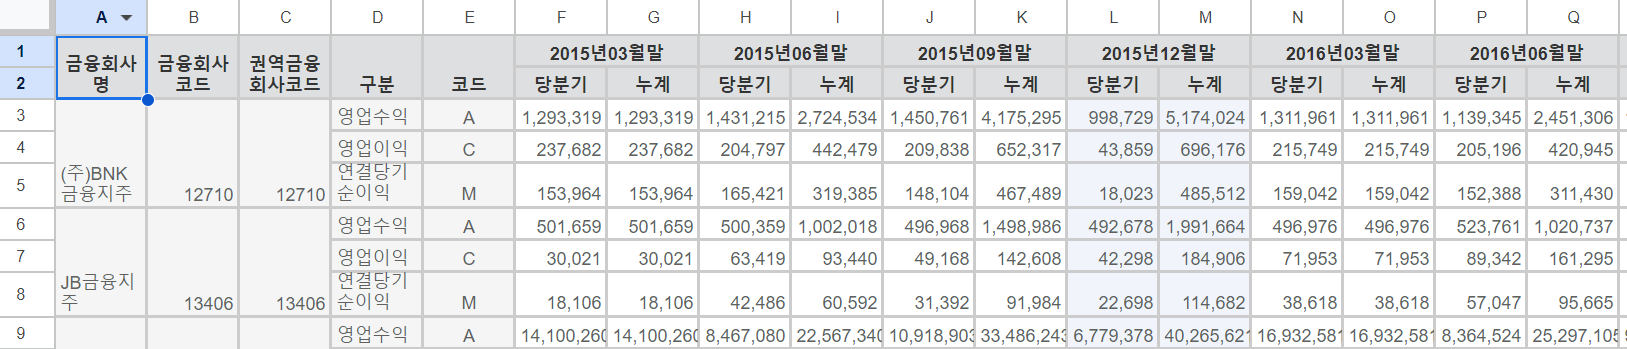

- 금융지주 재무상태표 최종.xls

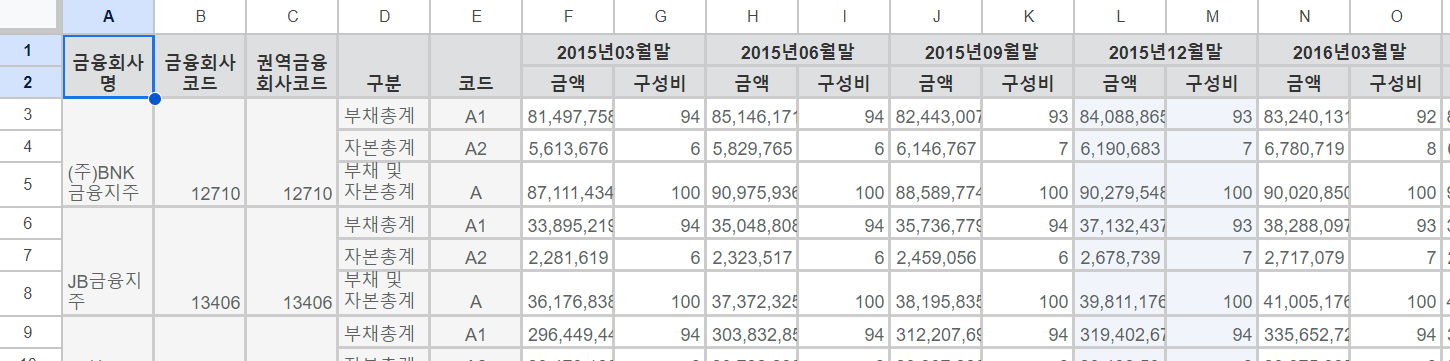

- 엑셀 파일의 header 등의 형태가 전처리를 하기에 까다롭게 되어 있음으로, 데이터 형태 수정이 필요

### 2-6-2. 원본 데이터 수정

- 원본데이터를 df_Dart_PL 또는 df_Dart_BS 파일과 비슷한 형식으로 데이터를 수정해야 함

#### 2-6-2-1. 손익계산서 수정(df_Bank_PL.pkl 생성)

In [ ]:
import pandas as pd

df_bank_PL_raw = pd.read_excel('/content/drive/MyDrive/snowball/data/Bank_holding/금융지주 손익계산서 최종.xls', skiprows=1)
print(df_bank_PL_raw.info())
df_bank_PL_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 73 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   금융회사명        35 non-null     object
 1   금융회사코드       35 non-null     object
 2   권역금융회사코드     34 non-null     object
 3   구분           34 non-null     object
 4   코드           34 non-null     object
 5   2015년03월말    35 non-null     object
 6   Unnamed: 6   35 non-null     object
 7   2015년06월말    35 non-null     object
 8   Unnamed: 8   35 non-null     object
 9   2015년09월말    35 non-null     object
 10  Unnamed: 10  34 non-null     object
 11  2015년12월말    31 non-null     object
 12  Unnamed: 12  31 non-null     object
 13  2016년03월말    31 non-null     object
 14  Unnamed: 14  31 non-null     object
 15  2016년06월말    31 non-null     object
 16  Unnamed: 16  31 non-null     object
 17  2016년09월말    31 non-null     object
 18  Unnamed: 18  31 non-null     object
 19  2016년12월말    31 non-null     ob

,금융회사명,금융회사코드,권역금융회사코드,구분,코드,2015년03월말,Unnamed: 6,2015년06월말,Unnamed: 8,2015년09월말,...,2022년06월말,Unnamed: 64,2022년09월말,Unnamed: 66,2022년12월말,Unnamed: 68,2023년03월말,Unnamed: 70,2023년06월말,Unnamed: 72
0,NaN,NaN,NaN,NaN,NaN,당분기,누계,당분기,누계,당분기,...,당분기,누계,당분기,누계,당분기,누계,당분기,누계,당분기,누계
1,(주)BNK금융지주,0012710,0012710,영업수익,A,1293319,1293319,1431215,2724534,1450761,...,1819308,3631080,2073003,5704083,1858746,7562829,2587596,2587596,2302543,4890139
2,(주)BNK금융지주,0012710,0012710,영업이익,C,237682,237682,204797,442479,209838,...,327358,702603,365936,1068539,90380,1158919,321791,321791,279560,601351
3,(주)BNK금융지주,0012710,0012710,연결당기순이익,M,153964,153964,165421,319385,148104,...,228775,505092,258099,763191,46961,810152,256754,256754,195916,452670
4,JB금융지주,0013406,0013406,영업수익,A,501659,501659,500359,1002018,496968,...,743632,1451924,831712,2283636,914628,3198264,1008679,1008679,1026614,2035293


- 'Unnamed'가 들어간 컬럼들은 누계 금액을 나타냄, Dart 재무제표에서 만든 df_PL이 누적 값으로 되어 있음으로, 이 데이터프레임도 누적값으로 데이터들을 저장
- Unnamed가 들어간 컬럼들은 어떤 값을 나타내는지 확인하기 어려움으로 컬럼명 수정이 필요
- 파일명은 df_Bank_PL.pkl로 저장
- 컬럼명 수정 -> 결측치 처리 -> 데이터 구조 순으로 전처리 진행

In [ ]:
original_columns = list(df_bank_PL_raw.columns) # 기존 데이터프레임의 컬럼명
to_use_row_list = list(df_bank_PL_raw.loc[0,:]) # 앞으로 행의 정보들
print(original_columns[:7])
print(to_use_row_list[:7])
print(len(original_columns))
print(len(to_use_row_list))

['금융회사명', '금융회사코드', '권역금융회사코드', '구분', '코드', '2015년03월말', 'Unnamed: 6']
[nan, nan, nan, nan, nan, '당분기', '누계']
73
73


In [ ]:
# unnamed 컬럼명 수정과, 사용할 컬럼들 만을 use_column_list 에 추가
use_column_list = list() # 사용할 컬럼명들을 담을 리스트
for i in range(len(original_columns)):
  if (i>5) & (i%2==0):
    original_columns[i] = original_columns[i-1] +' 누계'
    use_column_list.append(original_columns[i]) # 사용할 컬럼명들만 추출
  elif (i==0)|(i==3):
    use_column_list.append(original_columns[i])# 사용할 컬럼명들만 추출
print(original_columns)
print(use_column_list)

['금융회사명', '금융회사코드', '권역금융회사코드', '구분', '코드', '2015년03월말', '2015년03월말 누계', '2015년06월말', '2015년06월말 누계', '2015년09월말', '2015년09월말 누계', '2015년12월말', '2015년12월말 누계', '2016년03월말', '2016년03월말 누계', '2016년06월말', '2016년06월말 누계', '2016년09월말', '2016년09월말 누계', '2016년12월말', '2016년12월말 누계', '2017년03월말', '2017년03월말 누계', '2017년06월말', '2017년06월말 누계', '2017년09월말', '2017년09월말 누계', '2017년12월말', '2017년12월말 누계', '2018년03월말', '2018년03월말 누계', '2018년06월말', '2018년06월말 누계', '2018년09월말', '2018년09월말 누계', '2018년12월말', '2018년12월말 누계', '2019년03월말', '2019년03월말 누계', '2019년06월말', '2019년06월말 누계', '2019년09월말', '2019년09월말 누계', '2019년12월말', '2019년12월말 누계', '2020년03월말', '2020년03월말 누계', '2020년06월말', '2020년06월말 누계', '2020년09월말', '2020년09월말 누계', '2020년12월말', '2020년12월말 누계', '2021년03월말', '2021년03월말 누계', '2021년06월말', '2021년06월말 누계', '2021년09월말', '2021년09월말 누계', '2021년12월말', '2021년12월말 누계', '2022년03월말', '2022년03월말 누계', '2022년06월말', '2022년06월말 누계', '2022년09월말', '2022년09월말 누계', '2022년12월말', '2022년12월말 누계', '2023년03월말', '2023년03월말 누계',

In [ ]:
# 컬럼명 수정이 된 것을 확인
df_bank_PL_raw.columns = original_columns
df_bank_PL_raw.head()

,금융회사명,금융회사코드,권역금융회사코드,구분,코드,2015년03월말,2015년03월말 누계,2015년06월말,2015년06월말 누계,2015년09월말,...,2022년06월말,2022년06월말 누계,2022년09월말,2022년09월말 누계,2022년12월말,2022년12월말 누계,2023년03월말,2023년03월말 누계,2023년06월말,2023년06월말 누계
0,NaN,NaN,NaN,NaN,NaN,당분기,누계,당분기,누계,당분기,...,당분기,누계,당분기,누계,당분기,누계,당분기,누계,당분기,누계
1,(주)BNK금융지주,0012710,0012710,영업수익,A,1293319,1293319,1431215,2724534,1450761,...,1819308,3631080,2073003,5704083,1858746,7562829,2587596,2587596,2302543,4890139
2,(주)BNK금융지주,0012710,0012710,영업이익,C,237682,237682,204797,442479,209838,...,327358,702603,365936,1068539,90380,1158919,321791,321791,279560,601351
3,(주)BNK금융지주,0012710,0012710,연결당기순이익,M,153964,153964,165421,319385,148104,...,228775,505092,258099,763191,46961,810152,256754,256754,195916,452670
4,JB금융지주,0013406,0013406,영업수익,A,501659,501659,500359,1002018,496968,...,743632,1451924,831712,2283636,914628,3198264,1008679,1008679,1026614,2035293


In [ ]:
# 사용할 컬럼들만 추림
df_bank_PL_raw = df_bank_PL_raw[use_column_list]
df_bank_PL_raw.head()

,금융회사명,구분,2015년03월말 누계,2015년06월말 누계,2015년09월말 누계,2015년12월말 누계,2016년03월말 누계,2016년06월말 누계,2016년09월말 누계,2016년12월말 누계,...,2021년03월말 누계,2021년06월말 누계,2021년09월말 누계,2021년12월말 누계,2022년03월말 누계,2022년06월말 누계,2022년09월말 누계,2022년12월말 누계,2023년03월말 누계,2023년06월말 누계
0,NaN,NaN,누계,누계,누계,누계,누계,누계,누계,누계,...,누계,누계,누계,누계,누계,누계,누계,누계,누계,누계
1,(주)BNK금융지주,영업수익,1293319,2724534,4175295,5174024,1311961,2451306,3730961,4912676,...,1393822,2780427,4246506,5580698,1811772,3631080,5704083,7562829,2587596,4890139
2,(주)BNK금융지주,영업이익,237682,442479,652317,696176,215749,420945,623295,712281,...,262718,636622,1003674,1092019,375245,702603,1068539,1158919,321791,601351
3,(주)BNK금융지주,연결당기순이익,153964,319385,467489,485512,159042,311430,457077,501611,...,192724,468027,743383,791009,276317,505092,763191,810152,256754,452670
4,JB금융지주,영업수익,501659,1002018,1498986,1991664,496976,1020737,1545373,2096378,...,615153,1243245,1885084,2591083,708292,1451924,2283636,3198264,1008679,2035293


In [ ]:
df_bank_PL_raw

,금융회사명,구분,2015년03월말 누계,2015년06월말 누계,2015년09월말 누계,2015년12월말 누계,2016년03월말 누계,2016년06월말 누계,2016년09월말 누계,2016년12월말 누계,...,2021년03월말 누계,2021년06월말 누계,2021년09월말 누계,2021년12월말 누계,2022년03월말 누계,2022년06월말 누계,2022년09월말 누계,2022년12월말 누계,2023년03월말 누계,2023년06월말 누계
0,NaN,NaN,누계,누계,누계,누계,누계,누계,누계,누계,...,누계,누계,누계,누계,누계,누계,누계,누계,누계,누계
1,(주)BNK금융지주,영업수익,1293319,2724534,4175295,5174024,1311961,2451306,3730961,4912676,...,1393822,2780427,4246506,5580698,1811772,3631080,5704083,7562829,2587596,4890139
2,(주)BNK금융지주,영업이익,237682,442479,652317,696176,215749,420945,623295,712281,...,262718,636622,1003674,1092019,375245,702603,1068539,1158919,321791,601351
3,(주)BNK금융지주,연결당기순이익,153964,319385,467489,485512,159042,311430,457077,501611,...,192724,468027,743383,791009,276317,505092,763191,810152,256754,452670
4,JB금융지주,영업수익,501659,1002018,1498986,1991664,496976,1020737,1545373,2096378,...,615153,1243245,1885084,2591083,708292,1451924,2283636,3198264,1008679,2035293
5,JB금융지주,영업이익,30021,93440,142608,184906,71953,161295,233678,242444,...,177838,371669,556733,708288,229640,442025,672597,825758,223229,443091
6,JB금융지주,연결당기순이익,18106,60592,91984,114682,38618,95665,135974,142650,...,132345,278355,412356,506562,166808,320030,487062,601020,163363,326138
7,농협금융지주 주식회사,영업수익,14100260,22567340,33486243,40265621,16932581,25297105,34973610,42962781,...,21386843,29610149,39828544,48237499,21989214,35409249,50575924,55509599,12042925,22088577
8,농협금융지주 주식회사,영업이익,302024,795056,1173403,936442,240151,-26336,436355,750779,...,1155815,2420800,3451342,4263404,1031005,2219790,3216923,3775157,1497532,2728877
9,농협금융지주 주식회사,연결당기순이익,137588,436975,619667,402258,89415,-201269,98683,320968,...,604355,1281930,1824734,2291895,596293,1350494,1971730,2230893,947090,1705832


In [ ]:
df_bank_PL_raw = df_bank_PL_raw.loc[1:30,:] # 0번 인덱스 행은 사용을 안하기에 제거
df_bank_PL_raw = df_bank_PL_raw.reset_index(drop=True) # 인덱스 초기화
print(df_bank_PL_raw.info())
df_bank_PL_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   금융회사명         30 non-null     object
 1   구분            30 non-null     object
 2   2015년03월말 누계  30 non-null     object
 3   2015년06월말 누계  30 non-null     object
 4   2015년09월말 누계  30 non-null     object
 5   2015년12월말 누계  30 non-null     object
 6   2016년03월말 누계  30 non-null     object
 7   2016년06월말 누계  30 non-null     object
 8   2016년09월말 누계  30 non-null     object
 9   2016년12월말 누계  30 non-null     object
 10  2017년03월말 누계  30 non-null     object
 11  2017년06월말 누계  30 non-null     object
 12  2017년09월말 누계  30 non-null     object
 13  2017년12월말 누계  30 non-null     object
 14  2018년03월말 누계  30 non-null     object
 15  2018년06월말 누계  30 non-null     object
 16  2018년09월말 누계  30 non-null     object
 17  2018년12월말 누계  30 non-null     object
 18  2019년03월말 누계  30 non-null     object
 19  2019년06월말 

,금융회사명,구분,2015년03월말 누계,2015년06월말 누계,2015년09월말 누계,2015년12월말 누계,2016년03월말 누계,2016년06월말 누계,2016년09월말 누계,2016년12월말 누계,...,2021년03월말 누계,2021년06월말 누계,2021년09월말 누계,2021년12월말 누계,2022년03월말 누계,2022년06월말 누계,2022년09월말 누계,2022년12월말 누계,2023년03월말 누계,2023년06월말 누계
0,(주)BNK금융지주,영업수익,1293319,2724534,4175295,5174024,1311961,2451306,3730961,4912676,...,1393822,2780427,4246506,5580698,1811772,3631080,5704083,7562829,2587596,4890139
1,(주)BNK금융지주,영업이익,237682,442479,652317,696176,215749,420945,623295,712281,...,262718,636622,1003674,1092019,375245,702603,1068539,1158919,321791,601351
2,(주)BNK금융지주,연결당기순이익,153964,319385,467489,485512,159042,311430,457077,501611,...,192724,468027,743383,791009,276317,505092,763191,810152,256754,452670
3,JB금융지주,영업수익,501659,1002018,1498986,1991664,496976,1020737,1545373,2096378,...,615153,1243245,1885084,2591083,708292,1451924,2283636,3198264,1008679,2035293
4,JB금융지주,영업이익,30021,93440,142608,184906,71953,161295,233678,242444,...,177838,371669,556733,708288,229640,442025,672597,825758,223229,443091


In [ ]:
melt_columns = list(df_bank_PL_raw.columns)[2:] # melt를 사용하기 위해서 컬럼을 설정
melt_columns

['2015년03월말 누계',
 '2015년06월말 누계',
 '2015년09월말 누계',
 '2015년12월말 누계',
 '2016년03월말 누계',
 '2016년06월말 누계',
 '2016년09월말 누계',
 '2016년12월말 누계',
 '2017년03월말 누계',
 '2017년06월말 누계',
 '2017년09월말 누계',
 '2017년12월말 누계',
 '2018년03월말 누계',
 '2018년06월말 누계',
 '2018년09월말 누계',
 '2018년12월말 누계',
 '2019년03월말 누계',
 '2019년06월말 누계',
 '2019년09월말 누계',
 '2019년12월말 누계',
 '2020년03월말 누계',
 '2020년06월말 누계',
 '2020년09월말 누계',
 '2020년12월말 누계',
 '2021년03월말 누계',
 '2021년06월말 누계',
 '2021년09월말 누계',
 '2021년12월말 누계',
 '2022년03월말 누계',
 '2022년06월말 누계',
 '2022년09월말 누계',
 '2022년12월말 누계',
 '2023년03월말 누계',
 '2023년06월말 누계']

In [ ]:
# 데이터프레임 구조변경 및 컬러명 수정
df_bank_PL = pd.melt(df_bank_PL_raw, id_vars=['금융회사명','구분'], value_vars=melt_columns)
df_bank_PL.columns = ['회사명','항목명', '시기', '분기누적금액']
df_bank_PL.head()

,회사명,항목명,시기,분기누적금액
0,(주)BNK금융지주,영업수익,2015년03월말 누계,1293319
1,(주)BNK금융지주,영업이익,2015년03월말 누계,237682
2,(주)BNK금융지주,연결당기순이익,2015년03월말 누계,153964
3,JB금융지주,영업수익,2015년03월말 누계,501659
4,JB금융지주,영업이익,2015년03월말 누계,30021


In [ ]:
# '시기' 컬럼을 분리하여 '연도'와 '분기' 컬럼을 만듭니다.
df_bank_PL['연도표시'] = df_bank_PL['시기'].str.extract(r'(\d{4})년')[0]
df_bank_PL['분기표시'] = df_bank_PL['시기'].str.extract(r'(\d{2}월말)')[0]

# '연도'와 '분기' 컬럼을 정수로 변환합니다.
df_bank_PL['연도표시'] = df_bank_PL['연도표시'].astype(int)
df_bank_PL['분기표시'] = df_bank_PL['분기표시'].str.replace('월말', '').astype(int)

# '시기' 컬럼을 삭제합니다.
df_bank_PL.drop(columns=['시기'], inplace=True)

# '분기' 컬럼을 수정합니다.
df_bank_PL['분기표시'] = df_bank_PL['분기표시'].replace({3: 1, 6: 2, 9: 3, 12: 4})

df_bank_PL.head()

,회사명,항목명,분기누적금액,연도표시,분기표시
0,(주)BNK금융지주,영업수익,1293319,2015,1
1,(주)BNK금융지주,영업이익,237682,2015,1
2,(주)BNK금융지주,연결당기순이익,153964,2015,1
3,JB금융지주,영업수익,501659,2015,1
4,JB금융지주,영업이익,30021,2015,1


In [ ]:
df_bank_PL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사명     1020 non-null   object
 1   항목명     1020 non-null   object
 2   분기누적금액  1020 non-null   object
 3   연도표시    1020 non-null   int64 
 4   분기표시    1020 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 40.0+ KB


- df_bank_PL 에는 종목코드의 정보가 없음으로, '금융지주 주식코드.csv' 파일의 정보를 통해 종목코드 정보 추가

In [ ]:
df_bank_stock = pd.read_csv('/content/drive/MyDrive/snowball/data/Bank_holding/금융지주 주식코드.csv', encoding ='cp949')
df_bank_stock

,회사명,종목코드
0,(주)BNK금융지주,[138930]
1,JB금융지주,[175330]
2,농협금융지주 주식회사,NaN
3,주식회사 디지비금융지주,[139130]
4,주식회사 메리츠금융지주,[138040]
5,주식회사 신한금융지주회사,[055550]
6,주식회사 우리금융지주,[316140]
7,주식회사 케이비금융지주,[105560]
8,주식회사 하나금융지주,[086790]
9,한국투자금융지주 주식회사,[071050]


In [ ]:
df_Bank_PL = pd.merge(df_bank_PL,df_bank_stock, on='회사명', how='inner') # merge를 통해서 종목코드 병합
df_Bank_PL.head()

,회사명,항목명,분기누적금액,연도표시,분기표시,종목코드
0,(주)BNK금융지주,영업수익,1293319,2015,1,[138930]
1,(주)BNK금융지주,영업이익,237682,2015,1,[138930]
2,(주)BNK금융지주,연결당기순이익,153964,2015,1,[138930]
3,(주)BNK금융지주,영업수익,2724534,2015,2,[138930]
4,(주)BNK금융지주,영업이익,442479,2015,2,[138930]


In [ ]:
df_Bank_PL.to_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Bank_PL.pkl')

#### 2-6-2-2. 재무상태표 수정(df_Bank_BS.pkl 생성)

- 2-6-2-1 에서의 df_Bank_PL 파일 생성과정과 비슷하게 진행
- df_Bank_PL 과 달리 Unnamed 컬럼들 컬럼명 수정할 필요는 없음

In [ ]:
import pandas as pd

df_bank_BS_raw = pd.read_excel('/content/drive/MyDrive/snowball/data/Bank_holding/금융지주 재무상태표 최종.xls', skiprows=1)
print(df_bank_BS_raw.info())
df_bank_BS_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 73 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   금융회사명        35 non-null     object
 1   금융회사코드       35 non-null     object
 2   권역금융회사코드     34 non-null     object
 3   구분           34 non-null     object
 4   코드           34 non-null     object
 5   2015년03월말    35 non-null     object
 6   Unnamed: 6   35 non-null     object
 7   2015년06월말    35 non-null     object
 8   Unnamed: 8   35 non-null     object
 9   2015년09월말    35 non-null     object
 10  Unnamed: 10  34 non-null     object
 11  2015년12월말    31 non-null     object
 12  Unnamed: 12  31 non-null     object
 13  2016년03월말    31 non-null     object
 14  Unnamed: 14  31 non-null     object
 15  2016년06월말    31 non-null     object
 16  Unnamed: 16  31 non-null     object
 17  2016년09월말    31 non-null     object
 18  Unnamed: 18  31 non-null     object
 19  2016년12월말    31 non-null     ob

,금융회사명,금융회사코드,권역금융회사코드,구분,코드,2015년03월말,Unnamed: 6,2015년06월말,Unnamed: 8,2015년09월말,...,2022년06월말,Unnamed: 64,2022년09월말,Unnamed: 66,2022년12월말,Unnamed: 68,2023년03월말,Unnamed: 70,2023년06월말,Unnamed: 72
0,NaN,NaN,NaN,NaN,NaN,금액,구성비,금액,구성비,금액,...,금액,구성비,금액,구성비,금액,구성비,금액,구성비,금액,구성비
1,(주)BNK금융지주,0012710,0012710,부채총계,A1,81497758,93.56,85146171,93.59,82443007,...,124495357,92.01,126094470,92.13,126134072,92.09,130873165,92.48,132726046,92.67
2,(주)BNK금융지주,0012710,0012710,자본총계,A2,5613676,6.44,5829765,6.41,6146767,...,10808147,7.99,10775959,7.87,10832316,7.91,10645109,7.52,10500146,7.33
3,(주)BNK금융지주,0012710,0012710,부채 및 자본총계,A,87111434,100,90975936,100,88589774,...,135303504,100,136870429,100,136966388,100,141518274,100,143226192,100
4,JB금융지주,0013406,0013406,부채총계,A1,33895219,93.69,35048808,93.78,35736779,...,54451103,92.4,55515976,92.29,55065152,92.04,55025402,91.71,55702706,91.67


In [ ]:
# unnamed 컬럼명 수정과, 사용할 컬럼들 만을 use_column_list 에 추가
original_columns = list(df_bank_BS_raw.columns)
use_column_list = list() # 사용할 컬럼명들을 담을 리스트
for i in range(len(original_columns)):
  if (i>5) & (i%2==1):
    use_column_list.append(original_columns[i]) # 사용할 컬럼명들만 추출
  elif (i==0)|(i==3):
    use_column_list.append(original_columns[i])# 사용할 컬럼명들만 추출
print(original_columns)
print(use_column_list)

['금융회사명', '금융회사코드', '권역금융회사코드', '구분', '코드', '2015년03월말', 'Unnamed: 6', '2015년06월말', 'Unnamed: 8', '2015년09월말', 'Unnamed: 10', '2015년12월말', 'Unnamed: 12', '2016년03월말', 'Unnamed: 14', '2016년06월말', 'Unnamed: 16', '2016년09월말', 'Unnamed: 18', '2016년12월말', 'Unnamed: 20', '2017년03월말', 'Unnamed: 22', '2017년06월말', 'Unnamed: 24', '2017년09월말', 'Unnamed: 26', '2017년12월말', 'Unnamed: 28', '2018년03월말', 'Unnamed: 30', '2018년06월말', 'Unnamed: 32', '2018년09월말', 'Unnamed: 34', '2018년12월말', 'Unnamed: 36', '2019년03월말', 'Unnamed: 38', '2019년06월말', 'Unnamed: 40', '2019년09월말', 'Unnamed: 42', '2019년12월말', 'Unnamed: 44', '2020년03월말', 'Unnamed: 46', '2020년06월말', 'Unnamed: 48', '2020년09월말', 'Unnamed: 50', '2020년12월말', 'Unnamed: 52', '2021년03월말', 'Unnamed: 54', '2021년06월말', 'Unnamed: 56', '2021년09월말', 'Unnamed: 58', '2021년12월말', 'Unnamed: 60', '2022년03월말', 'Unnamed: 62', '2022년06월말', 'Unnamed: 64', '2022년09월말', 'Unnamed: 66', '2022년12월말', 'Unnamed: 68', '2023년03월말', 'Unnamed: 70', '2023년06월말', 'Unnamed: 72']
['금융회사

In [ ]:
# 사용할 컬럼들만 추림
df_bank_BS_raw = df_bank_BS_raw[use_column_list]
df_bank_BS_raw

,금융회사명,구분,2015년06월말,2015년09월말,2015년12월말,2016년03월말,2016년06월말,2016년09월말,2016년12월말,2017년03월말,...,2021년03월말,2021년06월말,2021년09월말,2021년12월말,2022년03월말,2022년06월말,2022년09월말,2022년12월말,2023년03월말,2023년06월말
0,NaN,NaN,금액,금액,금액,금액,금액,금액,금액,금액,...,금액,금액,금액,금액,금액,금액,금액,금액,금액,금액
1,(주)BNK금융지주,부채총계,85146171,82443007,84088865,83240131,85924051,85775784,86395039,87864044,...,110074322,115388503,119617288,118063851,122412473,124495357,126094470,126134072,130873165,132726046
2,(주)BNK금융지주,자본총계,5829765,6146767,6190683,6780719,6945187,7071093,7087152,7180489,...,9694470,9946058,10202651,10223183,10270168,10808147,10775959,10832316,10645109,10500146
3,(주)BNK금융지주,부채 및 자본총계,90975936,88589774,90279548,90020850,92869238,92846877,93482191,95044533,...,119768792,125334561,129819939,128287034,132682641,135303504,136870429,136966388,141518274,143226192
4,JB금융지주,부채총계,35048808,35736779,37132437,38288097,39724070,41358644,42835081,43345839,...,49698556,50375989,51340823,52068950,53617279,54451103,55515976,55065152,55025402,55702706
5,JB금융지주,자본총계,2323517,2459056,2678739,2717079,2787133,2929161,2963814,2985692,...,4074880,4169503,4228033,4326687,4345737,4479690,4637925,4763013,4975988,5061164
6,JB금융지주,부채 및 자본총계,37372325,38195835,39811176,41005176,42511203,44287805,45798895,46331531,...,53773436,54545492,55568856,56395637,57963016,58930793,60153901,59828165,60001390,60763870
7,농협금융지주 주식회사,부채총계,303832851,312207699,319402671,335652729,342995938,347061347,346575949,353582352,...,468070383,475398216,490015893,478988495,494489240,508546189,522775161,496209212,489461305,497713265
8,농협금융지주 주식회사,자본총계,20782299,20937883,20438504,20375395,20198889,20404067,20368848,20554434,...,26004191,27142023,27820158,27949571,28447610,27862274,27832265,28677762,33249251,34254062
9,농협금융지주 주식회사,부채 및 자본총계,324615150,333145582,339841175,356028124,363194827,367465414,366944797,374136786,...,494074574,502540239,517836051,506938066,522936850,536408463,550607426,524886974,522710556,531967327


In [ ]:
df_bank_BS_raw = df_bank_BS_raw.loc[1:30,:] # 0번 인덱스 행은 사용을 안하기에 제거
df_bank_BS_raw = df_bank_BS_raw.reset_index(drop=True) # 인덱스 초기화
print(df_bank_BS_raw.info())
df_bank_BS_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   금융회사명      30 non-null     object
 1   구분         30 non-null     object
 2   2015년06월말  30 non-null     object
 3   2015년09월말  30 non-null     object
 4   2015년12월말  30 non-null     object
 5   2016년03월말  30 non-null     object
 6   2016년06월말  30 non-null     object
 7   2016년09월말  30 non-null     object
 8   2016년12월말  30 non-null     object
 9   2017년03월말  30 non-null     object
 10  2017년06월말  30 non-null     object
 11  2017년09월말  30 non-null     object
 12  2017년12월말  30 non-null     object
 13  2018년03월말  30 non-null     object
 14  2018년06월말  30 non-null     object
 15  2018년09월말  30 non-null     object
 16  2018년12월말  30 non-null     object
 17  2019년03월말  30 non-null     object
 18  2019년06월말  30 non-null     object
 19  2019년09월말  30 non-null     object
 20  2019년12월말  30 non-null     object


,금융회사명,구분,2015년06월말,2015년09월말,2015년12월말,2016년03월말,2016년06월말,2016년09월말,2016년12월말,2017년03월말,...,2021년03월말,2021년06월말,2021년09월말,2021년12월말,2022년03월말,2022년06월말,2022년09월말,2022년12월말,2023년03월말,2023년06월말
0,(주)BNK금융지주,부채총계,85146171,82443007,84088865,83240131,85924051,85775784,86395039,87864044,...,110074322,115388503,119617288,118063851,122412473,124495357,126094470,126134072,130873165,132726046
1,(주)BNK금융지주,자본총계,5829765,6146767,6190683,6780719,6945187,7071093,7087152,7180489,...,9694470,9946058,10202651,10223183,10270168,10808147,10775959,10832316,10645109,10500146
2,(주)BNK금융지주,부채 및 자본총계,90975936,88589774,90279548,90020850,92869238,92846877,93482191,95044533,...,119768792,125334561,129819939,128287034,132682641,135303504,136870429,136966388,141518274,143226192
3,JB금융지주,부채총계,35048808,35736779,37132437,38288097,39724070,41358644,42835081,43345839,...,49698556,50375989,51340823,52068950,53617279,54451103,55515976,55065152,55025402,55702706
4,JB금융지주,자본총계,2323517,2459056,2678739,2717079,2787133,2929161,2963814,2985692,...,4074880,4169503,4228033,4326687,4345737,4479690,4637925,4763013,4975988,5061164


In [ ]:
melt_columns = list(df_bank_BS_raw.columns)[2:] # melt를 사용하기 위해서 컬럼을 설정

# 데이터프레임 구조변경 및 컬러명 수정
df_bank_BS = pd.melt(df_bank_BS_raw, id_vars=['금융회사명','구분'], value_vars=melt_columns)
df_bank_BS.columns = ['회사명','항목명', '시기', '분기금액']
df_bank_BS.head()


,회사명,항목명,시기,분기금액
0,(주)BNK금융지주,부채총계,2015년06월말,85146171
1,(주)BNK금융지주,자본총계,2015년06월말,5829765
2,(주)BNK금융지주,부채 및 자본총계,2015년06월말,90975936
3,JB금융지주,부채총계,2015년06월말,35048808
4,JB금융지주,자본총계,2015년06월말,2323517


In [ ]:
# '시기' 컬럼을 분리하여 '연도'와 '분기' 컬럼을 만듭니다.
df_bank_BS['연도표시'] = df_bank_BS['시기'].str.extract(r'(\d{4})년')[0]
df_bank_BS['분기표시'] = df_bank_BS['시기'].str.extract(r'(\d{2}월말)')[0]

# '연도'와 '분기' 컬럼을 정수로 변환합니다.
df_bank_BS['연도표시'] = df_bank_BS['연도표시'].astype(int)
df_bank_BS['분기표시'] = df_bank_BS['분기표시'].str.replace('월말', '').astype(int)

# '시기' 컬럼을 삭제합니다.
df_bank_BS.drop(columns=['시기'], inplace=True)

# '분기' 컬럼을 수정합니다.
df_bank_BS['분기표시'] = df_bank_BS['분기표시'].replace({3: 1, 6: 2, 9: 3, 12: 4})

df_bank_BS.head()

,회사명,항목명,분기금액,연도표시,분기표시
0,(주)BNK금융지주,부채총계,85146171,2015,2
1,(주)BNK금융지주,자본총계,5829765,2015,2
2,(주)BNK금융지주,부채 및 자본총계,90975936,2015,2
3,JB금융지주,부채총계,35048808,2015,2
4,JB금융지주,자본총계,2323517,2015,2


In [ ]:
df_bank_stock = pd.read_csv('/content/drive/MyDrive/snowball/data/Bank_holding/금융지주 주식코드.csv', encoding ='cp949')

df_Bank_BS = pd.merge(df_bank_BS,df_bank_stock, on='회사명') # merge를 통해서 종목코드 병합
df_Bank_BS.head()

,회사명,항목명,분기금액,연도표시,분기표시,종목코드
0,(주)BNK금융지주,부채총계,85146171,2015,2,[138930]
1,(주)BNK금융지주,자본총계,5829765,2015,2,[138930]
2,(주)BNK금융지주,부채 및 자본총계,90975936,2015,2,[138930]
3,(주)BNK금융지주,부채총계,82443007,2015,3,[138930]
4,(주)BNK금융지주,자본총계,6146767,2015,3,[138930]


In [ ]:
df_Bank_BS.to_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Bank_BS.pkl')

# 3.  데이터 탐색 & 품질 보고서

## 3-1. df_etf_base_info.pkl

### 3-1-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df_etf_base_info = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_etf_base_info.pkl')
print(df_etf_base_info.info())
print(df_etf_base_info.isnull().sum())
df_etf_base_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   단축코드    292 non-null    int64         
 1   한글종목약명  292 non-null    object        
 2   상장일     292 non-null    datetime64[ns]
 3   운용사     292 non-null    object        
 4   CU수량    292 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.5+ KB
None
단축코드      0
한글종목약명    0
상장일       0
운용사       0
CU수량      0
dtype: int64


,단축코드,한글종목약명,상장일,운용사,CU수량
0,445690,BNK 주주가치액티브,2022-10-27,비엔케이자산운용,50000
1,442260,마이티 다이나믹퀀트액티브,2022-10-25,디비자산운용,40000
2,159800,마이티 코스피100,2012-07-05,디비자산운용,40000
3,361580,KBSTAR 200TR,2020-08-21,케이비자산운용,50000
4,285000,KBSTAR 200IT,2017-12-08,케이비자산운용,20000


- 만들어진 데이터 프레임은 ETF(국내, 기본, 주식구성으로 된 ETF들)의 기본 정보들을 알려주는 데이터프레임
- ETF들을 구분하는 '단축코드', ETF의 이름을 알려주는 '한글종목약명', ETF가 상장이 된 날짜인 '상장일', ETF를 운용하는 '운용사, ETF의 몇개의 CU로 구성되어 있는 'CU수량'의 컬럼들로 구성되어 있음
- null 값이 있는 컬럼은 없음

### 3-1-2. 운용사별 상장 etf 개수 확인

- 운용사별 상장 etf 개수를 시각화
- 전체 etf 개수에서 비중을 확인하기 위해서 pie chart를 활용

In [ ]:
import plotly.express as px

df_etf_base_info_count = df_etf_base_info.groupby('운용사').count().reset_index()

fig = px.pie(df_etf_base_info_count, values='한글종목약명', names='운용사',title='운용사별 상장 etf 개수')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

- 여러개의 자산 운용사들이 있지만 5개 정도의 자산운용사가 전체 자산운용사들 중에서 75프로 이상을 차지할 정도로, 소수의 자산운용사가 대부분을 차지 함
- 상위 5개 중에서도 미래에셋자산운용과 삼성자산운용, 케이비자산운용이 압도적으로 많은 비중을 차지함을 확인

### 3-1-3. 연도별 상장 etf 개수 확인

- 연도별 상장 etf 개수를 확인
- 시간 흐름에 따른 상장개수를 구하기 위해서 bar chart를 사용

In [ ]:
df_etf_base_info_year_month = df_etf_base_info.copy()
df_etf_base_info_year_month['year'] = df_etf_base_info['상장일'].dt.year # 상장년도 컬럼 추가
df_etf_base_info_year_month['month'] = df_etf_base_info['상장일'].dt.month # 상장월 커럼 추가
df_etf_base_info_year_month.head()


,단축코드,한글종목약명,상장일,운용사,CU수량,year,month
0,445690,BNK 주주가치액티브,2022-10-27,비엔케이자산운용,50000,2022,10
1,442260,마이티 다이나믹퀀트액티브,2022-10-25,디비자산운용,40000,2022,10
2,159800,마이티 코스피100,2012-07-05,디비자산운용,40000,2012,7
3,361580,KBSTAR 200TR,2020-08-21,케이비자산운용,50000,2020,8
4,285000,KBSTAR 200IT,2017-12-08,케이비자산운용,20000,2017,12


In [ ]:
df_etf_base_info_count = df_etf_base_info_year_month.groupby('year').count().reset_index()
df_etf_base_info_count.head()

,year,단축코드,한글종목약명,상장일,운용사,CU수량,month
0,2002,2,2,2,2,2,2
1,2006,5,5,5,5,5,5
2,2007,1,1,1,1,1,1
3,2008,9,9,9,9,9,9
4,2009,5,5,5,5,5,5


In [ ]:
import plotly.express as px
fig = px.bar(df_etf_base_info_count, x='year', y='한글종목약명',title="연도별 etf 상장개수")
fig.show()

- 국내, 일반, 주식으로만 이루어진 etf들은 10년전에 비해서 많은 상장이 있었지만, 딱히 규칙이 있어보이지는 않음
- 2023년은 아직 해당 년도가 다 지나지 않았기에 아직 상장개수가 다 있지 않음

### 3-1-4. 월별 상장 etf 개수 확인

- 월 별 상장 etf 개수를 확인
- 시간 흐름에 따른 상장개수를 구하기 위해서 bar chart를 사용

In [ ]:
df_etf_base_info_count = df_etf_base_info_year_month.groupby('month').count().reset_index()
fig = px.bar(df_etf_base_info_count, x='month', y='단축코드',title="월별 etf 상장개수")
fig.show()

- 다른 월 보다 유독 10월에 상장하는 etf의 개수가 많음 을 확인

## 3-2. df_pdf_files.pkl

### 3-2-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df_pdf_files = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_pdf_files.pkl')
print(df_pdf_files.info())
print(df_pdf_files.isnull().sum())
df_pdf_files.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2863706 entries, 0 to 2863705
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   종목코드       object        
 1   구성종목명      object        
 2   주식수(계약수)   float64       
 3   평가금액       float64       
 4   시가총액       float64       
 5   시가총액 구성비중  float64       
 6   etf_code   int64         
 7   pdf_date   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 174.8+ MB
None
종목코드              0
구성종목명            35
주식수(계약수)     115351
평가금액         790498
시가총액         758822
시가총액 구성비중    913343
etf_code          0
pdf_date          0
dtype: int64


,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
0,005930,삼성전자,246.0,NaN,144156000.0,NaN,100910,2008-02-01
1,005490,POSCO,174.0,NaN,88914000.0,NaN,100910,2008-02-01
2,060000,국민은행,749.0,NaN,45988600.0,NaN,100910,2008-02-01
3,055550,신한지주,840.0,NaN,42588000.0,NaN,100910,2008-02-01
4,009540,현대중공업,116.0,NaN,37758000.0,NaN,100910,2008-02-01


- 만들어진 데이터 프레임은 ETF의 PDF(Portfolio Deposit File) 정보를 가지고 있음
- 한 PDF 파일이 어떤 주식종목들로 구성되어 있는지 나타내는 '종목코드', 해당 주식코드의 종목명을 나타내는 '구성종목명', 한 PDF에서 해당 종목코드의 주식을 몇개 가지고 있는지 나타내는 '주식수(계약수)',해당일자에 있는 PDF내 주식들의 평가금액을 나타내는 '평가금액', 해당일자에 있는 PDF내 주식들의 시가총액을 나타내는 '시가총액', 한 PDF내 금액 중 시가총액 비중을 나타내는 '시가총액 구성비중, PDF의 어떤 ETF에 대응하는지 나타내는 'etf_code', PDF 조회날짜를 나타내는 'pdf_date'의 컬럼들로 이루어져 있음

### 3-2-2. null 값들을 확인

#### 3-2-2-1. 구성종목명

In [ ]:
# 구성종목명이 null 값인 데이터프레임을 확인
df_pdf_files.loc[(df_pdf_files['구성종목명'].isnull()),:]

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
93832,US92906P1066,NaN,200.0,NaN,NaN,NaN,105010,2008-09-01
93833,US02364W1053,NaN,300.0,NaN,NaN,NaN,105010,2008-09-01
93834,US0384962041,NaN,100.0,NaN,NaN,NaN,105010,2008-09-01
93835,US0594603039,NaN,1000.0,NaN,NaN,NaN,105010,2008-09-01
93836,US0596022014,NaN,1000.0,NaN,NaN,NaN,105010,2008-09-01
93837,US05968L1026,NaN,100.0,NaN,NaN,NaN,105010,2008-09-01
93838,US1055301097,NaN,100.0,NaN,NaN,NaN,105010,2008-09-01
93839,US1512908898,NaN,500.0,NaN,NaN,NaN,105010,2008-09-01
93840,US2044096012,NaN,400.0,NaN,NaN,NaN,105010,2008-09-01
93841,US20440T2015,NaN,100.0,NaN,NaN,NaN,105010,2008-09-01


- 구성종목명이 null 값인 데이터들의 '종목코드' 국내 주식 종목코드들이 아님으로 추후 '국내, 일반, 주식'으로 데이터들을 필터링할 때 자동으로 제거가 될 예정

#### 3-2-2-2. 평가금액 & 시가총액

- 평가금액 : 주식수(계약수)에 전일 종가를 곱한 금액
- 시가총액 : 주식수(계약수)에 조회시점(20분 지연) 가격을 곱한 금액
- 과거의 금액 데이터들을 사용함으로,  시가총액은 조회일의 종가, 평가금액은 조회일 전날의 종가를 의미함
- 시가총액도 null값이 있고, 평가금액도 null 값이 있음으로, 시가총액 또는 평가금액 둘 중 하나에 존재하는 null 값들을 채울 때 시가총액 -> 평가금액 순으로 우선순위를 두어서 금액을 판단하기로 함
- 시가총액과 평가금액이 둘 다 null 값인 경우는 따로 값을 조사하여 값을 채워야 함

In [ ]:
df_pdf_files.loc[df_pdf_files['평가금액'].isnull(),:] # 평가금액이 null 값인 데이터 확인

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
0,005930,삼성전자,246.0,NaN,144156000.0,NaN,100910,2008-02-01
1,005490,POSCO,174.0,NaN,88914000.0,NaN,100910,2008-02-01
2,060000,국민은행,749.0,NaN,45988600.0,NaN,100910,2008-02-01
3,055550,신한지주,840.0,NaN,42588000.0,NaN,100910,2008-02-01
4,009540,현대중공업,116.0,NaN,37758000.0,NaN,100910,2008-02-01
...,...,...,...,...,...,...,...,...
2863701,KYG9829N1025,XINYI SOLAR HOLDINGS LTD,3000.0,NaN,NaN,NaN,99140,2023-10-04
2863702,KYG982AW1003,Xpeng inc,744.0,NaN,NaN,NaN,99140,2023-10-04
2863703,KYG9894K1085,ZHONGSHENG GROUP HOLDINGS,510.0,NaN,NaN,NaN,99140,2023-10-04
2863704,KRD010010001,원화현금,NaN,NaN,53505674.0,NaN,99140,2023-10-04


In [ ]:
df_pdf_files.loc[df_pdf_files['시가총액'].isnull(),:] # 시가총액이 null 값인 데이터 확인

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
18729,JP3388200002,AEON,1300.0,NaN,NaN,NaN,101280,2008-03-03
18730,JP3112000009,ASAHI GLASS,2000.0,NaN,NaN,NaN,101280,2008-03-03
18731,JP3111200006,ASAHI KASEI,2000.0,NaN,NaN,NaN,101280,2008-03-03
18732,JP3942400007,ASTELLAS PHARMA INC,800.0,NaN,NaN,NaN,101280,2008-03-03
18733,JP3955400001,BANK OF YOKOHAMA,2000.0,NaN,NaN,NaN,101280,2008-03-03
...,...,...,...,...,...,...,...,...
2863699,KYG9066F1019,TRIP COM GROUP,84.0,NaN,NaN,NaN,99140,2023-10-04
2863700,KYG9830T1067,XIAOMI CORP-CLASS B,10772.0,NaN,NaN,NaN,99140,2023-10-04
2863701,KYG9829N1025,XINYI SOLAR HOLDINGS LTD,3000.0,NaN,NaN,NaN,99140,2023-10-04
2863702,KYG982AW1003,Xpeng inc,744.0,NaN,NaN,NaN,99140,2023-10-04


In [ ]:
df_pdf_files.loc[(df_pdf_files['시가총액'].notnull()) &(df_pdf_files['평가금액'].isnull()),:] # 시가총액은 값이 있고 평가금액이 null 인 데이터 확인

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
0,005930,삼성전자,246.0,NaN,144156000.0,NaN,100910,2008-02-01
1,005490,POSCO,174.0,NaN,88914000.0,NaN,100910,2008-02-01
2,060000,국민은행,749.0,NaN,45988600.0,NaN,100910,2008-02-01
3,055550,신한지주,840.0,NaN,42588000.0,NaN,100910,2008-02-01
4,009540,현대중공업,116.0,NaN,37758000.0,NaN,100910,2008-02-01
...,...,...,...,...,...,...,...,...
2863599,CASH00000001,설정현금액,NaN,NaN,816775319.0,NaN,99140,2023-08-01
2863651,KRD010010001,원화현금,NaN,NaN,23476257.0,NaN,99140,2023-09-01
2863652,CASH00000001,설정현금액,NaN,NaN,785457210.0,NaN,99140,2023-09-01
2863704,KRD010010001,원화현금,NaN,NaN,53505674.0,NaN,99140,2023-10-04


In [ ]:
df_pdf_files.loc[(df_pdf_files['평가금액'].notnull()) &(df_pdf_files['시가총액'].isnull()),:] # 시가총액이 null 값이고, 평가금액이 null 값이 아닌 데이터 확인

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
34027,TPZ0INDEX000,TOPIX INDEX F2012,0.67,117392533.0,NaN,NaN,101280,2020-11-02
34130,TPZ0INDEX000,TOPIX INDEX F2012,0.67,126822730.0,NaN,NaN,101280,2020-12-01
34233,TPH1INDEX000,TOPIX INDEX F2103,0.67,127871256.0,NaN,NaN,101280,2021-01-04
34336,TPH1INDEX000,TOPIX INDEX F2103,0.67,131108980.0,NaN,NaN,101280,2021-02-01
34439,TPH1INDEX000,TOPIX INDEX F2103,0.67,136975837.0,NaN,NaN,101280,2021-03-02
...,...,...,...,...,...,...,...,...
2862936,HCQ2INDEX000,H-SHARES F2208,0.29,17017998.0,NaN,NaN,99140,2022-08-01
2862990,HCU2INDEX000,H-SHARES F2209,0.47,27346060.0,NaN,NaN,99140,2022-09-01
2863042,HCV2INDEX000,H-SHARES F2210,0.47,25330537.0,NaN,NaN,99140,2022-10-04
2863095,HCX2INDEX000,H-SHARES F2211,0.47,21516522.0,NaN,NaN,99140,2022-11-01


In [ ]:
# 평가금액과 시가총액이 둘 다 null 값인 값을 확인
two_null_list = list(df_pdf_files.loc[(df_pdf_files['평가금액'].isnull())&(df_pdf_files['시가총액'].isnull()),'종목코드'].unique())
print(len(two_null_list))
print(two_null_list[:5])

7230
['JP3388200002', 'JP3112000009', 'JP3111200006', 'JP3942400007', 'JP3955400001']


- 평가금액과 시가총액이 둘 다 null 값인 '종목코드'의 종류가 6747로 일일히 확인하기에는 너무 많음(국내,일반, 주식이 아닌 etf들도 현재는 포함이 되어 있기 때문에, 추후 국내,일반, 주식이 아닌 etf들로 필터링 하는 과정에서 많이 줄어들 것으로 기대)
- 사용하는 종목코드들은 6자릿수 임으로 종목코드가 6자리가 아닌 종목코드들을 거름
- 종목코드가 'KRD010010001'인 경우는 원화현금 또는 원화예금으로 '국내, 일반, 주식'에 포함이 됨으로 사용을 해야 함

In [ ]:
# 종목코드가 6자리거나 'KRD010010001' 인 데이터들 중에서, '평가금액'과 '시가총액'이 둘 다 null 값이어서 값을 채울 수 없는 데이터들을 확인
df_pdf_files.loc[((df_pdf_files['종목코드'].str.len()==6) | (df_pdf_files['종목코드']== 'KRD010010001'))&((df_pdf_files['평가금액'].isnull())&(df_pdf_files['시가총액'].isnull())),:]

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date


- 확인 결과, 사용할 row들 중에서 '평가금액'과 '시가총액'이 둘 다 null 값이어서 사용하기 어려운 데이터는 없음을 확인

#### 3-2-2-3. 주식수(계약수)

In [ ]:
# 주식수가 null인 데이터 확인
df_pdf_files.loc[(df_pdf_files['주식수(계약수)'].isnull()),:]

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
100,KRD010010001,원화예금,NaN,NaN,4177622.0,NaN,100910,2008-02-01
201,KRD010010001,원화예금,NaN,NaN,4088920.0,NaN,100910,2008-03-03
302,KRD010010001,원화예금,NaN,NaN,5488388.0,NaN,100910,2008-04-01
403,KRD010010001,원화예금,NaN,NaN,6231776.0,NaN,100910,2008-05-02
504,KRD010010001,원화예금,NaN,NaN,8110493.0,NaN,100910,2008-06-02
...,...,...,...,...,...,...,...,...
2863599,CASH00000001,설정현금액,NaN,NaN,816775319.0,NaN,99140,2023-08-01
2863651,KRD010010001,원화현금,NaN,NaN,23476257.0,NaN,99140,2023-09-01
2863652,CASH00000001,설정현금액,NaN,NaN,785457210.0,NaN,99140,2023-09-01
2863704,KRD010010001,원화현금,NaN,NaN,53505674.0,NaN,99140,2023-10-04


In [ ]:
df_pdf_files.loc[((df_pdf_files['종목코드'].str.len() == 6)& (df_pdf_files['주식수(계약수)'].isnull()) ), :]

,종목코드,구성종목명,주식수(계약수),평가금액,시가총액,시가총액 구성비중,etf_code,pdf_date
183429,011160,두산건설,NaN,NaN,0.0,0.0,117700,2011-05-02
851047,119650,KC코트렐,NaN,NaN,0.0,0.0,226490,2022-02-03
851048,011810,STX,NaN,NaN,0.0,0.0,226490,2022-02-03
851049,001210,금호전기,NaN,NaN,0.0,0.0,226490,2022-02-03
851050,010600,웰바이오텍,NaN,NaN,0.0,0.0,226490,2022-02-03
...,...,...,...,...,...,...,...,...
2457810,007460,에이프로젠,NaN,NaN,0.0,0.0,375770,2022-12-01
2457811,074610,이엔플러스,NaN,NaN,0.0,0.0,375770,2022-12-01
2457812,166480,코아스템,NaN,NaN,0.0,0.0,375770,2022-12-01
2457813,200230,텔콘RF제약,NaN,NaN,0.0,0.0,375770,2022-12-01


In [ ]:
df_pdf_files.loc[((df_pdf_files['종목코드'].str.len() == 6)& (df_pdf_files['주식수(계약수)'].isnull()) ), '시가총액'].unique()

array([0.])

> 종목코드의 길이가 6인 것은 주식임을 뜻함, pdf파일 중에서 주식수가 안나와있는 주식은 없음으로, 주식수를 통해서 etf 평가지표를 생성할 수 있음

## 3-3. df_etf_closing_price.pkl

### 3-3-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd
# 로컬 pc에서 생성한 pdf 통합 파일 확인
df_etf_closing_price = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_etf_closing_price.pkl')
print(df_etf_closing_price.info())
print(df_etf_closing_price.isnull().sum())
display(df_etf_closing_price.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810846 entries, 0 to 810845
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   종목코드      810846 non-null  int64         
 1    종목명      810846 non-null  object        
 2   종가        810846 non-null  int64         
 3   시가총액      810846 non-null  int64         
 4   etf_date  810846 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 30.9+ MB
None
종목코드        0
 종목명        0
종가          0
시가총액        0
etf_date    0
dtype: int64


,종목코드,종목명,종가,시가총액,etf_date
0,152100,ARIRANG 200,24775,422413750000,2015-01-02
1,152100,ARIRANG 200,24730,425356000000,2015-01-05
2,152100,ARIRANG 200,24245,417014000000,2015-01-06
3,152100,ARIRANG 200,24315,413355000000,2015-01-07
4,152100,ARIRANG 200,24640,418880000000,2015-01-08


- 만들어진 데이터 프레임은 ETF의 종가에 대한 정보를 가지고 있음
- 어떤 etf 코드인지 나타내는 '종목코드', 해당 코드의 한글종목명을 나타내는 '종목명', ETF 한 주당 종가가격을 나타내는 '종가', 해당 일자의 상장된 etf의 전체 종가를 나타내는 '시가총액', 조회날짜의 정보를 나타내는 'etf_date'의 컬럼으로 이루어져 있음
- 각 컬럼들의 null 값들이 없음

### 3-3-2. KODEX200 시각화

- 3-1-3 에서 확인한 '연도별 상장 etf 개수'와 비교
- 전체적인 시장의 흐름과 매우 유사하게 움직이는, 코스피 200을 추종하는 '069500' kodex 200을 사용

In [ ]:
# KODEX200 ETF의 가격 데이터프레임을 가져옴
df_kodex_200 = df_etf_closing_price.loc[df_etf_closing_price['종목코드']==69500,:].copy()
df_kodex_200.head()

,종목코드,종목명,종가,시가총액,etf_date
40983,69500,KODEX 200,24725,4932637500000,2015-01-02
40984,69500,KODEX 200,24680,4952042000000,2015-01-05
40985,69500,KODEX 200,24240,4694076000000,2015-01-06
40986,69500,KODEX 200,24290,4649106000000,2015-01-07
40987,69500,KODEX 200,24600,4688760000000,2015-01-08


In [ ]:
# 3-1-3 파트 참조 - 연도별 ETF 상장개수를 가져옴
df_etf_base_info = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_etf_base_info.pkl')
df_etf_base_info_year_month = df_etf_base_info.copy()
df_etf_base_info_year_month['year'] = df_etf_base_info['상장일'].dt.year # 상장년도 컬럼 추가
df_etf_base_info_year_month['month'] = df_etf_base_info['상장일'].dt.month # 상장월 커럼 추가
df_etf_base_info_count = df_etf_base_info_year_month.groupby('year').count().reset_index()
df_etf_base_info_count = df_etf_base_info_count.loc[df_etf_base_info_count['year']>2014,:]
df_etf_base_info_count.head()

,year,단축코드,한글종목약명,상장일,운용사,CU수량,month
10,2015,18,18,18,18,18,18
11,2016,14,14,14,14,14,14
12,2017,35,35,35,35,35,35
13,2018,33,33,33,33,33,33
14,2019,29,29,29,29,29,29


In [ ]:
# 시각화를 통해서 'KODEX200의 종가'와 '연도별 ETF 상장개수'를 비교
import plotly.express as px
import plotly.graph_objects as go

# Line 그래프
fig1 = px.line(df_kodex_200, x='etf_date', y='종가', title='KODEX 200 종가 추이')

# Line 그래프2
fig2 = px.bar(df_etf_base_info_count, x='year', y='한글종목약명', title='ETF 상장개수')

# 두 그래프를 하나의 화면에 출력
fig = go.Figure()

# Line 그래프를 추가
fig.add_trace(go.Scatter(x=fig1.data[0]['x'], y=fig1.data[0]['y'], mode='lines', name='KODEX 200 종가 추이', yaxis='y'))

# Line 그래프2를 추가하고 오른쪽 y 축에 매핑
fig.add_trace(go.Scatter(x=fig2.data[0]['x'], y=fig2.data[0]['y'], name='ETF 상장개수', yaxis='y2'))

# 레이아웃 설정
fig.update_layout(title='KODEX 200 종가와 연도별 ETF 상장 개수',
                  xaxis_title='연도',
                  yaxis_title='KODEX 200 종가',
                  yaxis2=dict(title='ETF 상장개수',
                              overlaying='y',
                              side='right'))

# 그래프 출력
fig.show()

- KODEX 200은 과 ETF 상장개수가 비슷한 추세로 움직임을 확인
- 국내 주식 시장이 활황일 때 (국내, 일반, 주식형) ETF가 많이 상장되고, 반대로 국내 주식시장이 불활일 때 ETF가 적게 상장되는 경향이 있음을 확인

### 3-3-3. 전체 ETF 중 일부 시각화

- ETF 들이 전반적으로 어떻게 움직이는지 확인하기 위해서 시각화(모든 ETF들이 너무 비슷하게 움직이면 굳이 ETF들을 구분하는 필요가 없기에)
- 모든 ETF 들을 다 확인하기에는 너무 많기에 랜덤으로 10개의 ETF를 선택하여서 시각화
- x축을 시간, y축을 '종가'로 하여서 시각화를 하는데, etf 마다 종가의 범위가 다름으로, min-max scaler를 활용해서 0부터 100까지의 값으로 각 etf의 '종가'범위를 통일

In [ ]:
etf_code_list = list(df_etf_closing_price['종목코드'].unique()) # 시각화할 etf의 종류들을 리스트화
print(len(etf_code_list))
etf_code_list[:5]

772


[152100, 122090, 161510, 189400, 195970]

In [ ]:
import random

# etf의 가짓수가 776개 임으로 인덱스는 0부터 775까지 존재, 0부터 775 사이에서 랜덤으로 10개의 숫자 뽑기
random_index_list = random.sample(range(776), 10)

print(random_index_list)

[302, 324, 218, 393, 79, 141, 418, 358, 544, 276]


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일링을 위한 객체 생성
scaler = MinMaxScaler(feature_range=(0, 100))  # 범위를 0에서 10으로 설정

fig = go.Figure() # 그래프를 그리고 위해서

# 메모리 낭비를 방지하기 위해서 etf 별로 가격을 시각화하는 함수를 생
def draw_line_graph(etf_code):
  df_temp = df_etf_closing_price.loc[df_etf_closing_price['종목코드']==etf_code,:].copy() # 종목코드에 해당하는 데이터들을 복사


  # 스케일링할 컬럼 선택 및 스케일링 적용
  df_temp['price'] = scaler.fit_transform(df_temp[['종가']]) # 종가의 범위를 통일

  # df_temp의 정보들을 추가
  fig.add_trace(go.Scatter(x=df_temp['etf_date'], y=df_temp['price'],
                    mode='lines',
                    name= f"{etf_code}"))

# 시각화할 etf들을 랜덤으로 선택
for random_index in random_index_list:
  etf_code = etf_code_list[random_index]
  draw_line_graph(etf_code)

fig.show()

- 각 etf들이 다양하게 가격들이 변동함을 확인
- etf 중에 레버리지, 인버스 들도 있는 것으로 보아 추후 (국내, 일반, 주식형) etf들로 필터링 할 필요가 있음
- etf 마다 상장일들이 다 다름을 확인

## 3-4. df_stock_closing_price.pkl

### 3-4-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd
# 로컬 pc에서 생성한 pdf 통합 파일 확인
df_stock_closing_price = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_stock_closing_price.pkl')
print(df_stock_closing_price.info())
print(df_stock_closing_price.isnull().sum())
display(df_stock_closing_price.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253688 entries, 0 to 253687
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   종목코드        253688 non-null  object        
 1   종목명         253688 non-null  object        
 2   시장구분        253688 non-null  object        
 3   소속부         157394 non-null  object        
 4   종가          253688 non-null  int64         
 5   대비          253688 non-null  int64         
 6   등락률         253688 non-null  float64       
 7   시가          253688 non-null  int64         
 8   고가          253688 non-null  int64         
 9   저가          253688 non-null  int64         
 10  거래량         253688 non-null  int64         
 11  거래대금        253688 non-null  int64         
 12  시가총액        253688 non-null  int64         
 13  상장주식수       253688 non-null  int64         
 14  stock_date  253688 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(9), object(

,종목코드,종목명,시장구분,소속부,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수,stock_date
0,060310,3S,KOSDAQ,중견기업부,2415,20,0.84,2395,2450,2385,212450,512299645,98754827220,40892268,2015-01-02
1,068400,AJ렌터카,KOSPI,NaN,17000,700,4.29,16250,17150,16250,117784,1979494550,376487100000,22146300,2015-01-02
2,006840,AK홀딩스,KOSPI,NaN,85100,4900,6.11,81000,85800,80500,82706,6929975900,1127367441100,13247561,2015-01-02
3,054620,AP시스템,KOSDAQ,우량기업부,6190,90,1.48,6140,6310,6130,241484,1498150700,144907658590,23409961,2015-01-02
4,090470,AST젯텍,KOSDAQ,벤처기업부,3120,-75,-2.35,3195,3195,3060,42314,131109315,45545160960,14597808,2015-01-02


- 만들어진 데이터 프레임은 Stock의 종가에 대한 정보를 가지고 있음
- 어떤 주식종목 코드인지 나타내는 '종목코드', 해당 코드의 한글종목명을 나타내는 '종목명', 주식의 한 주당 종가가격을 나타내는 '종가', 해당 일자의 상장된 주식의 전체 종가를 나타내는 '시가총액', 조회날짜의 정보를 나타내는 'stock_date'의 컬럼으로 이루어져 있음
- df_etf_closing_price.pkl 과 거의 비슷함

### 3-4-2. 전체 주식 중 일부 시각화

In [ ]:
import random

stock_code_list = list(df_stock_closing_price['종목코드'].unique()) # 시각화할 etf의 종류들을 리스트화
random_index_list = random.sample(range(len(stock_code_list)), 10)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일링을 위한 객체 생성
scaler = MinMaxScaler(feature_range=(0, 100))  # 범위를 0에서 10으로 설정

fig = go.Figure() # 그래프를 그리고 위해서

# 메모리 낭비를 방지하기 위해서 etf 별로 가격을 시각화하는 함수를 생
def draw_line_graph(stock_code):
  df_temp = df_stock_closing_price.loc[df_stock_closing_price['종목코드']==stock_code,:].copy() # 종목코드에 해당하는 데이터들을 복사

  stock_name = list(df_temp['종목명'].unique())[0] # 종목명을 변수에 할당

  # 스케일링할 컬럼 선택 및 스케일링 적용
  df_temp['price'] = scaler.fit_transform(df_temp[['종가']]) # 종가의 범위를 통일

  # df_temp의 정보들을 추가
  fig.add_trace(go.Scatter(x=df_temp['stock_date'], y=df_temp['price'],
                    mode='lines',
                    name= f"{stock_code}, {stock_name}"))

# 시각화할 etf들을 랜덤으로 선택
for random_index in random_index_list:
  stock_code = stock_code_list[random_index]
  draw_line_graph(stock_code)

fig.show()

- 각 주식들이 다양하게 가격들이 변동함을 확인
- 주식 마다 상장일들이 다 다름을 확인

## 3-5. df_Dart_PL

### 3-5-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df_Dart_PL = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Dart_PL.pkl')
print(df_Dart_PL.info())
print(df_Dart_PL.isnull().sum())
df_Dart_PL.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141339 entries, 0 to 3141338
Data columns (total 15 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   재무제표종류  object
 1   종목코드    object
 2   회사명     object
 3   시장구분    object
 4   업종      int64 
 5   업종명     object
 6   결산월     int64 
 7   결산기준일   object
 8   보고서종류   object
 9   통화      object
 10  항목코드    object
 11  항목명     object
 12  분기누적금액  object
 13  분기표시    int64 
 14  연도표시    int64 
dtypes: int64(4), object(11)
memory usage: 359.5+ MB
None
재무제표종류         0
종목코드           0
회사명            0
시장구분           0
업종             0
업종명            0
결산월            0
결산기준일          0
보고서종류          0
통화             0
항목코드           0
항목명           24
분기누적금액    336319
분기표시           0
연도표시           0
dtype: int64


,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
0,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,ifrs_Revenue,영업수익,"99,202,002,000",3,2016
1,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,ifrs_RevenueFromRoyalties,로열티수익(매출액),"60,229,168,000",3,2016
2,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,ifrs_RevenueFromDividends,배당수익(매출액),"33,081,247,000",3,2016
3,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,entity00148540_udf_IS_2015810134350728_Revenue,임대료수익,"5,891,587,000",3,2016
4,"손익계산서, 기능별 분류 - 별도재무제표",[001040],CJ,유가증권시장상장법인,715,"회사본부, 지주회사 및 경영컨설팅 서비스업",12,2016-09-30,3분기보고서,KRW,entity00148540_udf_IS_201152222820640_IncomeSt...,영업비용,"-34,703,820,000",3,2016


- df_Dart_PL 은 Dart에서 제공하는 손익계산서 파일들을 통합한 파일
- 데이터프레임은 손익계산서의 종류를 알려주는 '재무제표종류' 컬럼, 주식의 코드를 나타내는 '종목코드'컬럼, 회사의 이름을 알려주는 '회사명', 상장되어 있는 시장을 알려주는 '시장구분', 회사가 속한 업종의 코드를 나타내는 '업종', '업종'이 이떤 업종명을 가지는 알려주는 '업종명', 재무제표의 결산일자 관련 정보를 알려주는 '결산월', '결산기준일', 보고서의 종류를 나타내는 '보고서종류', 통화의 종류를 나타내는 '통화, 재무제표의 어떤 항목인지를 나타내는 '항목코드', '항목명,', 해당 시기까지의 누적금액을 나타내는 '분기누적금액', 재무제표가 어떤 연도와 분기에 나온것임을 알려주는 '분기표시', '연도표시' 컬럼들로 이루어져 있따
- '재무제표종류','결산기준일', '보고서종류', '통화', '항목코드'&'항목명' 컬럼들은 값들의 가짓수가 한정적임으로 값의 종류들을 확인하는 절차 필요

### 3-5-2. '재무제표종류' 확인

In [ ]:
df_Dart_PL['재무제표종류'].unique()

array(['손익계산서, 기능별 분류 - 별도재무제표', '손익계산서, 성격별 분류 - 별도재무제표',
       '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표',
       '포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표',
       '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)',
       '포괄손익계산서(세후기타포괄손익) - 별도재무제표', '포괄손익계산서(세전기타포괄손익) - 별도재무제표(선택)',
       '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 별도재무제표(선택)', '손익계산서, 기능별 분류 - 연결재무제표',
       '손익계산서, 성격별 분류 - 연결재무제표', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표',
       '포괄손익계산서, 성격별 분류(세후기타포괄손익) - 연결재무제표',
       '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)',
       '포괄손익계산서(세후기타포괄손익) - 연결재무제표',
       '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)',
       '포괄손익계산서(세전기타포괄손익) - 연결재무제표(선택)', '단일 포괄손익계산서, 기능별 분류, 세후 - 연결',
       '단일 포괄손익계산서, 기능별 분류, 세전 - 연결', '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 연결',
       '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 연결', '단일 포괄손익계산서, 성격별 분류, 세후 - 연결',
       '단일 포괄손익계산서, 성격별 분류, 세전 - 연결', '단일 포괄손익계산서, 기능별 분류, 세후 - 별도',
       '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 별도',
       '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 별도', '단일 포괄손익계산서, 성격별 분류, 세후 - 별도',
     

- 원본 txt 파일의 Dart 재무제표 파일들은 'PL_1' ,'PL_2', 'PL_3', 'PL_4'로 종류가 4개인데, '재무제표종류' 컬럼에서 값들의 종류가 매우 많은 문제 발생

In [ ]:
import pandas as pd
import os

path_dir = "/content/drive/MyDrive/snowball/data/PL_report_txt"

PL_1_list = list()
PL_2_list = list()
PL_3_list = list()
PL_4_list = list()

file_list = os.listdir(path_dir) # 손익계산서 txt 파일들 확인

# PL_1, PL_2, PL_3, PL_4 의 '재무제표종류' 컬럼의 값 종류들을 확인
for file_name in file_list:
  df_temp = pd.read_csv(path_dir+"/"+file_name ,delimiter="\t", encoding='cp949')
  if file_name.split('.')[0].split('_')[-1]=='1':
    for kind_name in list(df_temp['재무제표종류'].unique()):
      PL_1_list.append(kind_name)

  elif file_name.split('.')[0].split('_')[-1]=='2':
    for kind_name in list(df_temp['재무제표종류'].unique()):
      PL_2_list.append(kind_name)

  elif file_name.split('.')[0].split('_')[-1]=='3':
    for kind_name in list(df_temp['재무제표종류'].unique()):
      PL_3_list.append(kind_name)

  elif file_name.split('.')[0].split('_')[-1]=='4':
    for kind_name in list(df_temp['재무제표종류'].unique()):
      PL_4_list.append(kind_name)

In [ ]:
PL_1_list = list(set(PL_1_list))
PL_2_list = list(set(PL_2_list))
PL_3_list = list(set(PL_3_list))
PL_4_list = list(set(PL_4_list))

print('PL_1 :', PL_1_list)
print('PL_2 :', PL_2_list)
print('PL_3 :', PL_3_list)
print('PL_4 :', PL_4_list)

PL_1 : ['손익계산서, 성격별 분류 - 별도재무제표', '손익계산서, 기능별 분류 - 별도', '손익계산서, 기능별 분류 - 별도재무제표', '손익계산서, 성격별 분류 - 별도']
PL_2 : ['손익계산서, 기능별 분류 - 연결재무제표', '손익계산서, 성격별 분류 - 연결', '손익계산서, 기능별 분류 - 연결', '손익계산서, 성격별 분류 - 연결재무제표']
PL_3 : ['포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표', '단일 포괄손익계산서, 성격별 분류, 세전 - 별도', '단일 포괄손익계산서, 기능별 분류, 세후 - 별도', '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 별도', '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)', '포괄손익계산서(세후기타포괄손익) - 별도재무제표', '단일 포괄손익계산서, 성격별 분류, 세후 - 별도', '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 별도재무제표(선택)', '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 별도', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표', '포괄손익계산서(세전기타포괄손익) - 별도재무제표(선택)']
PL_4 : ['단일 포괄손익계산서, 성격별 분류, 세전 - 연결', '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 연결', '포괄손익계산서, 성격별 분류(세후기타포괄손익) - 연결재무제표', '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)', '단일 포괄손익계산서, 기능별 분류, 세전 - 연결', '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표', '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 연결', '단일 포괄손익계산서, 기능별 분류, 세후 - 연결', '포괄손익계산서(세후기타포괄손익) - 연결재무제표', '단일 포괄손익계산서, 성격별 분류, 세후 - 연결', '포괄손익계산

- 해당 '재무제표종류'의 값들은 '재무제표종류' 컬럼에서 값들의 종류가 매우 많은 문제가 있기에 추후 4개의 카테고리로 변화하여 진행해야 함
- 변환 하는 과정에서 같은 종목코드'의 '결산기준일'의 값이 '재무제표종류'마다 다르게 표현되는 문제가 있는지 확인 필요

In [ ]:
# 출력값들을 하나의 리스트로 통합
PL_list = list()
PL_list.append(PL_1_list)
PL_list.append(PL_2_list)
PL_list.append(PL_3_list)
PL_list.append(PL_4_list)
PL_list

[['손익계산서, 성격별 분류 - 별도재무제표',
  '손익계산서, 기능별 분류 - 별도',
  '손익계산서, 기능별 분류 - 별도재무제표',
  '손익계산서, 성격별 분류 - 별도'],
 ['손익계산서, 기능별 분류 - 연결재무제표',
  '손익계산서, 성격별 분류 - 연결',
  '손익계산서, 기능별 분류 - 연결',
  '손익계산서, 성격별 분류 - 연결재무제표'],
 ['포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표',
  '단일 포괄손익계산서, 성격별 분류, 세전 - 별도',
  '단일 포괄손익계산서, 기능별 분류, 세후 - 별도',
  '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 별도',
  '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)',
  '포괄손익계산서(세후기타포괄손익) - 별도재무제표',
  '단일 포괄손익계산서, 성격별 분류, 세후 - 별도',
  '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 별도재무제표(선택)',
  '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 별도',
  '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표',
  '포괄손익계산서(세전기타포괄손익) - 별도재무제표(선택)'],
 ['단일 포괄손익계산서, 성격별 분류, 세전 - 연결',
  '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 연결',
  '포괄손익계산서, 성격별 분류(세후기타포괄손익) - 연결재무제표',
  '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)',
  '단일 포괄손익계산서, 기능별 분류, 세전 - 연결',
  '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)',
  '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표',
  '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 연결',
  '단일 포괄손익계산서, 기능별 분류, 세후 - 연결',
  '포괄손익계산서(세후기타포괄손익) - 연결재무제표',
  '단일 포괄손

In [ ]:
# PL_1, PL_2, PL_3, PL_4 별로 다양한 '재무제표종류'값들이 있기에
# 같은 결산기준일에 여러 '재무제표종류'값들이 있는지 확인
for PL_N_list in PL_list:
  print(PL_N_list)
  df_Dart_PL_N = df_Dart_PL.loc[df_Dart_PL['재무제표종류'].isin(PL_N_list),:].copy()
  duplicates = df_Dart_PL_N.groupby(['종목코드', '결산기준일'])['재무제표종류'].nunique().reset_index()
  duplicates = duplicates[duplicates['재무제표종류'] > 1]
  display(duplicates)
  print()

['손익계산서, 성격별 분류 - 별도재무제표', '손익계산서, 기능별 분류 - 별도', '손익계산서, 기능별 분류 - 별도재무제표', '손익계산서, 성격별 분류 - 별도']


,종목코드,결산기준일,재무제표종류



['손익계산서, 기능별 분류 - 연결재무제표', '손익계산서, 성격별 분류 - 연결', '손익계산서, 기능별 분류 - 연결', '손익계산서, 성격별 분류 - 연결재무제표']


,종목코드,결산기준일,재무제표종류



['포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표', '단일 포괄손익계산서, 성격별 분류, 세전 - 별도', '단일 포괄손익계산서, 기능별 분류, 세후 - 별도', '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 별도', '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)', '포괄손익계산서(세후기타포괄손익) - 별도재무제표', '단일 포괄손익계산서, 성격별 분류, 세후 - 별도', '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 별도재무제표(선택)', '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 별도', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표', '포괄손익계산서(세전기타포괄손익) - 별도재무제표(선택)']


,종목코드,결산기준일,재무제표종류



['단일 포괄손익계산서, 성격별 분류, 세전 - 연결', '포괄손익계산서, 세전으로 표시된 OCI 구성요소 - 연결', '포괄손익계산서, 성격별 분류(세후기타포괄손익) - 연결재무제표', '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)', '단일 포괄손익계산서, 기능별 분류, 세전 - 연결', '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표', '포괄손익계산서, 세후로 표시된 OCI 구성요소 - 연결', '단일 포괄손익계산서, 기능별 분류, 세후 - 연결', '포괄손익계산서(세후기타포괄손익) - 연결재무제표', '단일 포괄손익계산서, 성격별 분류, 세후 - 연결', '포괄손익계산서(세전기타포괄손익) - 연결재무제표(선택)']


,종목코드,결산기준일,재무제표종류


- 해당 과정을 통해서 같은 '종목코드'의 '결산기준일'의 값이 '재무제표종류'마다 다르게 표현되는 문제는 없음을 확인

### 3-5-3. '종목코드', '회사명' 확인

In [ ]:
# 종목코드 가짓수 확인
stock_code_kind = list(df_Dart_PL['종목코드'].unique())
print(stock_code_kind[:5])
df_Dart_PL['종목코드'].nunique()

['[001040]', '[000120]', '[037560]', '[155660]', '[078930]']


2607

In [ ]:
# 회사명 가짓수 확인
company_name_kind = list(df_Dart_PL['회사명'].unique())
print(company_name_kind[:5])
df_Dart_PL['회사명'].nunique()

['CJ', 'CJ대한통운', 'CJ헬로비전', 'DSR', 'GS']


3250

- '종목코드'의 종류는 2607개, '회사명'의 값들의 종류는 3250개로 개수가 다름을 확인

In [ ]:
# 사용할 컬럼만 추출
df_stock_company = df_Dart_PL[['종목코드','회사명']].copy()
df_stock_company.head()

,종목코드,회사명
0,[001040],CJ
1,[001040],CJ
2,[001040],CJ
3,[001040],CJ
4,[001040],CJ


In [ ]:
# 종목코드, 회사명 한 쌍으로 봤을 때 가짓수를 확인
df_stock_company = df_stock_company.drop_duplicates(subset=['종목코드','회사명'], keep='first')
df_stock_company = df_stock_company.reset_index(drop=True)
df_stock_company

,종목코드,회사명
0,[001040],CJ
1,[000120],CJ대한통운
2,[037560],CJ헬로비전
3,[155660],DSR
4,[078930],GS
...,...,...
3279,[458610],한국제12호스팩
3280,[386580],한화플러스제2호스팩
3281,[430460],한화플러스제3호스팩
3282,[455310],한화플러스제4호스팩


- '종목코드'의 종류는 2607개, '회사명'의 값들의 종류는 3250개 인데, '종목코드'와'회사명'을 한 쌍으로 했을 때 값의 종류는 3284개로 가짓수가 맞지않는 오류 발생

In [ ]:
# 한 종목코드에 회사명의 개수가 여러개인 경우 확인 - 회사명이 바뀌는 경우
df_stock_kind_count = df_stock_company.groupby('종목코드').count().reset_index()
df_stock_kind_count.columns = ['종목코드','회사수']
df_stock_kind_count[df_stock_kind_count['회사수']>1].head()

,종목코드,회사수
10,[000210],2
12,[000230],2
13,[000240],3
15,[000270],2
16,[000300],2


- 종목코드의 값은 유지가 되면서 회사명이 바뀌는 것은 재무제표 상에서 회사들을 구분하는 데는 영향이 없음

In [ ]:
# 한 회사명에 대응하는 주식종목 개수가 여러개인 경우 확인
df_company_kind_count = df_stock_company.groupby('회사명').count().reset_index()
df_company_kind_count.columns = ['회사명','종목개수']
df_company_kind_count[df_company_kind_count['종목개수']>1]

,회사명,종목개수
6,AP시스템,2
10,BGF리테일,2
61,F&F,2
213,OCI,2
274,SK케미칼,2
338,경동도시가스,2
494,넥스트칩,2
556,대덕전자,2
671,동국제강,2
860,롯데제과,2


In [ ]:
# 임의로 한개의 회사를 확인
df_stock_company[df_stock_company['회사명']=='롯데제과']

,종목코드,회사명
627,[004990],롯데제과
1996,[280360],롯데제과


In [ ]:
df_Dart_PL.loc[df_Dart_PL['종목코드']=='[004990]',:]

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
14635,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)",[004990],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2016-06-30,반기보고서,KRW,entity00120562_udf_IS_201386165426560_Statemen...,매출,"872,363,016,541",2,2016
14636,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)",[004990],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2016-06-30,반기보고서,KRW,entity00120562_udf_IS_201386165430998_Statemen...,매출 원가,"532,795,965,336",2,2016
14637,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)",[004990],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2016-06-30,반기보고서,KRW,entity00120562_udf_IS_201386165432529_Statemen...,매출 총이익,"339,567,051,205",2,2016
14638,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)",[004990],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2016-06-30,반기보고서,KRW,entity00120562_udf_IS_20138616543445_Statement...,판매비와 관리비,"291,160,986,612",2,2016
14639,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)",[004990],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2016-06-30,반기보고서,KRW,entity00120562_udf_IS_201386165439732_Statemen...,영업이익,"48,406,064,593",2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104662,"단일 포괄손익계산서, 성격별 분류, 세후 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_OtherComprehensiveIncomeNetOfTaxGainsLoss...,"세후기타포괄손익, 지분상품에 대한 투자자산","788,762,135",3,2023
3104663,"단일 포괄손익계산서, 성격별 분류, 세후 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_OtherComprehensiveIncomeNetOfTaxGainsLoss...,확정급여제도의 재측정손익(세후기타포괄손익),"406,941,602",3,2023
3104664,"단일 포괄손익계산서, 성격별 분류, 세후 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLoss,당기순이익(손실),"37,031,172,446",3,2023
3104665,"단일 포괄손익계산서, 성격별 분류, 세후 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLossBeforeTax,법인세비용차감전순이익(손실),"44,821,597,408",3,2023


In [ ]:
df_Dart_PL.loc[df_Dart_PL['종목코드']=='[280360]',:]

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
236693,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2017-12-31,사업보고서,KRW,ifrs_Revenue,매출액,"404,787,472,483",4,2017
236694,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2017-12-31,사업보고서,KRW,ifrs_CostOfSales,매출원가,"245,548,196,342",4,2017
236695,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2017-12-31,사업보고서,KRW,ifrs_GrossProfit,매출총이익,"159,239,276,141",4,2017
236696,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2017-12-31,사업보고서,KRW,dart_TotalSellingGeneralAdministrativeExpenses,판매비와관리비,"150,826,755,578",4,2017
236697,"포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2017-12-31,사업보고서,KRW,dart_OperatingIncomeLoss,영업이익,"8,412,520,563",4,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060575,"단일 포괄손익계산서, 기능별 분류, 세전 - 연결",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLoss,분기순이익,"83,766,844,544",3,2023
3060576,"단일 포괄손익계산서, 기능별 분류, 세전 - 연결",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLossAttributableToNoncontrollingInt...,비지배지분,"-1,908,095,901",3,2023
3060577,"단일 포괄손익계산서, 기능별 분류, 세전 - 연결",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLossAttributableToOwnersOfParent,지배기업 소유주지분,"85,674,940,445",3,2023
3060578,"단일 포괄손익계산서, 기능별 분류, 세전 - 연결",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_ProfitLossBeforeTax,법인세비용차감전순이익,"122,987,960,384",3,2023


- 회사가 분사하거나 통합될 때, 한 회사가 2개의 종목코드를 가지면서 나눠지는 경우들이 있음
- 모든 회사들의 경우를 다 파악하기 어려움으로, '종목코드'를 기준으로 재무제표의 회사들을 구분하고자 함

### 3-5-4. '결산기준일' 확인

- 해당 컬럼의 종류들 확인

In [ ]:
df_Dart_PL['결산기준일'].unique()

array(['2016-09-30', '2016-12-31', '2016-03-31', '2016-06-30',
       '2016-11-30', '2016-02-29', '2016-01-31', '2016-07-31',
       '2016-05-31', '2016-08-31', '2018-06-30', '2018-12-31',
       '2017-06-30', '2017-03-31', '2017-12-31', '2017-09-30',
       '2017-11-30', '2017-02-28', '2017-08-31', '2018-03-31',
       '2018-05-31', '2018-09-30', '2018-11-30', '2018-02-28',
       '2017-01-31', '2017-07-31', '2017-05-31', '2017-04-30',
       '2017-10-31', '2016-04-30', '2016-10-31', '2020-03-31',
       '2020-12-31', '2020-11-30', '2020-06-30', '2020-02-29',
       '2020-07-31', '2020-09-30', '2020-08-31', '2019-06-30',
       '2019-03-31', '2019-05-31', '2019-10-31', '2019-12-31',
       '2019-09-30', '2019-11-30', '2019-02-28', '2020-05-31',
       '2020-04-30', '2020-10-31', '2020-01-31', '2019-04-30',
       '2019-08-31', '2018-08-31', '2018-04-30', '2018-10-31',
       '2019-07-31', '2019-01-31', '2018-01-31', '2018-07-31',
       '2022-03-31', '2022-09-30', '2021-06-30', '2021-

- 2015년의 손익계산서는 4분기 손익계산서만이 있는데 결산기준일들이 2015-03-31과 같이 너무 연초의 날짜로 결산기준일들이 있는 경우들이 있음
- 2015년은 4분기의 누적금액만을 알려주기에, 2015년 당기 금액을 확인하는 방법이 없다 -> 즉 추후 2015년 재무제표 정보는 제외를 판단


In [ ]:
for i in range(1,5):
  print(i,'분기 결산기준일들 :',df_Dart_PL.loc[df_Dart_PL['분기표시']==i,'결산기준일'].unique())

1 분기 결산기준일들 : ['2017-06-30' '2017-03-31' '2017-12-31' '2017-09-30' '2017-11-30'
 '2017-02-28' '2018-06-30' '2018-03-31' '2018-05-31' '2018-12-31'
 '2018-09-30' '2018-11-30' '2018-02-28' '2019-06-30' '2019-03-31'
 '2019-05-31' '2019-10-31' '2019-12-31' '2019-09-30' '2019-11-30'
 '2019-02-28' '2020-03-31' '2020-06-30' '2020-09-30' '2020-05-31'
 '2020-10-31' '2020-12-31' '2020-11-30' '2020-02-29' '2022-03-31'
 '2022-09-30' '2021-06-30' '2021-03-31' '2021-05-31' '2021-10-31'
 '2021-12-31' '2021-09-30' '2021-11-30' '2021-02-28' '2023-06-30'
 '2023-03-31' '2023-05-31' '2022-06-30' '2022-05-31' '2022-12-31'
 '2022-11-30' '2022-02-28' '2023-02-28' '2016-06-30' '2016-03-31'
 '2016-09-30' '2016-12-31' '2016-11-30' '2016-08-31' '2016-02-29']
2 분기 결산기준일들 : ['2016-09-30' '2016-06-30' '2016-03-31' '2016-12-31' '2016-11-30'
 '2016-02-29' '2016-01-31' '2016-07-31' '2016-05-31' '2018-06-30'
 '2018-12-31' '2017-09-30' '2017-06-30' '2017-12-31' '2017-03-31'
 '2017-02-28' '2017-01-31' '2017-07-31' '2017-0

- 같은 연도에 분기 더라도 결산기준일들이 다 다를 수 있음을 확인
- 연도와 분기 정보는 결산기준일을 찾는 용도보다는 분기누적금액을 분기금액으로 변환하는데 사용이 가능할 듯

### 3-5-5. '보고서종류' 확인

- 해당 컬럼의 종류들 확인

In [ ]:
df_Dart_PL['보고서종류'].unique()

array(['3분기보고서', '반기보고서', '1분기보고서', '사업보고서'], dtype=object)

- '보고서종류'의 분기 구분과 '분기표시'의 분기 구분이 동일하게 되었는지 확인 필요

In [ ]:
print(df_Dart_PL.loc[df_Dart_PL['보고서종류']=='사업보고서', '분기표시'].unique())
print(df_Dart_PL.loc[df_Dart_PL['보고서종류']=='3분기보고서', '분기표시'].unique())
print(df_Dart_PL.loc[df_Dart_PL['보고서종류']=='반기보고서', '분기표시'].unique())
print(df_Dart_PL.loc[df_Dart_PL['보고서종류']=='1분기보고서', '분기표시'].unique())

[4]
[3]
[2]
[1]


- '보고서종류'의 분기 구분과 '분기표시'의 분기 구분이 동일하게 작성되었음을 확인

### 3-5-6. '통화' 확인

#### 3-5-6-1. 데이터 종류 확인

- 해당 컬럼의 종류들 확인

In [ ]:
df_Dart_PL['통화'].unique()

array(['KRW', 'USD', 'JPY', 'CNY', 'HKD'], dtype=object)

- KRW : 원화, USD : '달러', JPY : '엔화', CNY : '위안화', HKD : '홍콩달러'
- KRW 외에 다른 외환들은 KRW로 치환을 해야 추후 계산에 용이
- 외환들의 환율은 '결산기준일'의 환율을 적용
- 각 외환들의 '결산기준일' 종류를 확인

In [ ]:
df_Dart_PL.loc[(df_Dart_PL['통화']=='USD')|(df_Dart_PL['통화']=='JPY')|(df_Dart_PL['통화']=='CNY')|(df_Dart_PL['통화']=='HKD'), '결산기준일'].unique()

array(['2015-12-31', '2015-03-31', '2015-06-30', '2016-09-30',
       '2016-12-31', '2016-03-31', '2016-06-30', '2017-06-30',
       '2017-03-31', '2017-12-31', '2017-09-30', '2018-06-30',
       '2018-03-31', '2018-12-31', '2018-09-30', '2018-05-31',
       '2018-08-31', '2018-02-28', '2018-11-30', '2019-03-31',
       '2019-11-30', '2019-12-31', '2019-04-30', '2019-09-30',
       '2019-08-31', '2019-06-30', '2019-05-31', '2019-10-31',
       '2019-02-28', '2019-07-31', '2020-11-30', '2020-04-30',
       '2020-09-30', '2020-12-31', '2020-08-31', '2020-01-31',
       '2020-06-30', '2020-03-31', '2020-02-29', '2020-07-31',
       '2020-05-31', '2020-10-31', '2021-11-30', '2021-04-30',
       '2021-09-30', '2021-03-31', '2021-08-31', '2021-01-31',
       '2021-06-30', '2021-12-31', '2021-05-31', '2021-10-31',
       '2021-02-28', '2021-07-31', '2022-01-31', '2022-06-30',
       '2022-05-31', '2022-03-31', '2022-02-28', '2022-12-31',
       '2022-11-30', '2022-09-30'], dtype=object)

#### 3-5-6-2. 환율 파일 추가생성(df_exchange.pkl)

- 'https://kr.investing.com/currencies/hkd-krw-historical-data' 사이트를 통해서 외환 환율들을 조사
- 환율 과거 데이터들을 다운로드(Exchange_rate 폴더에 다운로드)
- 다운로드받은 파일들을 하나의 파일로 통합하여 저장

In [ ]:
import pandas as pd

df_usd = pd.read_csv('/content/drive/MyDrive/snowball/data/Exchage_rate/USD_KRW 과거 데이터.csv')
df_jpy = pd.read_csv('/content/drive/MyDrive/snowball/data/Exchage_rate/JPY_KRW 과거 데이터.csv')
df_cny = pd.read_csv('/content/drive/MyDrive/snowball/data/Exchage_rate/CNY_KRW 과거 데이터.csv')
df_hkd = pd.read_csv('/content/drive/MyDrive/snowball/data/Exchage_rate/HKD_KRW 과거 데이터.csv')

df_usd['외환종류'] = 'USD'
df_jpy['외환종류'] = 'JPY'
df_cny['외환종류'] = 'CNY'
df_hkd['외환종류'] = 'HKD'

In [ ]:
print(df_usd.info())
display(df_usd.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      2325 non-null   object 
 1   종가      2325 non-null   object 
 2   시가      2325 non-null   object 
 3   고가      2325 non-null   object 
 4   저가      2325 non-null   object 
 5   거래량     0 non-null      float64
 6   변동 %    2325 non-null   object 
 7   외환종류    2325 non-null   object 
dtypes: float64(1), object(7)
memory usage: 145.4+ KB
None


,날짜,종가,시가,고가,저가,거래량,변동 %,외환종류
0,2023- 11- 29,"1,291.11","1,287.48","1,293.52","1,285.99",NaN,0.30%,USD
1,2023- 11- 28,"1,287.25","1,298.41","1,298.91","1,285.70",NaN,-0.75%,USD
2,2023- 11- 27,"1,296.95","1,301.95","1,308.60","1,297.65",NaN,-0.46%,USD
3,2023- 11- 24,"1,302.97","1,301.22","1,308.83","1,296.65",NaN,0.21%,USD
4,2023- 11- 23,"1,300.20","1,300.78","1,303.52","1,295.47",NaN,-0.05%,USD


In [ ]:
display(df_usd.head(1))
display(df_jpy.head(1))
display(df_cny.head(1))
display(df_hkd.head(1))

,날짜,종가,시가,고가,저가,거래량,변동 %,외환종류
0,2023- 11- 29,"1,291.11","1,287.48","1,293.52","1,285.99",NaN,0.30%,USD


,날짜,종가,시가,고가,저가,거래량,변동 %,외환종류
0,2023- 11- 29,8.7369,8.7585,8.7795,8.7369,NaN,0.11%,JPY


,날짜,종가,시가,고가,저가,거래량,변동 %,외환종류
0,2023- 11- 29,181.03,180.28,181.46,179.93,NaN,0.53%,CNY


,날짜,종가,시가,고가,저가,거래량,변동 %,외환종류
0,2023- 11- 29,165.438,165.249,165.78,164.982,NaN,0.20%,HKD


In [ ]:
df_exchange = pd.concat([df_usd, df_jpy, df_cny, df_hkd])
df_exchange = df_exchange.reset_index(drop = True)
df_exchange['날짜'] = df_exchange['날짜'].str.replace(' ','')

In [ ]:
print(df_exchange.info())
print(df_exchange.isnull().sum())
df_exchange.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   날짜      9300 non-null   object
 1   종가      9300 non-null   object
 2   시가      9300 non-null   object
 3   고가      9300 non-null   object
 4   저가      9300 non-null   object
 5   거래량     1057 non-null   object
 6   변동 %    9300 non-null   object
 7   외환종류    9300 non-null   object
dtypes: object(8)
memory usage: 581.4+ KB
None
날짜         0
종가         0
시가         0
고가         0
저가         0
거래량     8243
변동 %       0
외환종류       0
dtype: int64


,날짜,종가,시가,고가,저가,거래량,변동 %,외환종류
0,2023-11-29,"1,291.11","1,287.48","1,293.52","1,285.99",NaN,0.30%,USD
1,2023-11-28,"1,287.25","1,298.41","1,298.91","1,285.70",NaN,-0.75%,USD
2,2023-11-27,"1,296.95","1,301.95","1,308.60","1,297.65",NaN,-0.46%,USD
3,2023-11-24,"1,302.97","1,301.22","1,308.83","1,296.65",NaN,0.21%,USD
4,2023-11-23,"1,300.20","1,300.78","1,303.52","1,295.47",NaN,-0.05%,USD


- df_exchange 데이터프레임은 조회날짜를 나타내는 '날짜', 가격에 대한정보들을 나타내는 '종가, '시가', 고가, '저가' 컬럼, 거래량을 나타내는 '거래량' 컬럼, 전날 대비 변동율을 나타내는 '변동 %', 어떤 외화와의 환율인지 나타내는 '외환종류' 컬럼을 가지고 있음

In [ ]:
df_exchange.to_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_exchange.pkl')

- df_exchange 파일을 활용해서 추후 df_Dart_PL 파일의 외화 부분을 수정할 예정

### 3-5-7. '항목명' 확인

- '항목명' 컬럼에 null 값들이 있었기에 null 값들을 확인

In [ ]:
df_Dart_PL.loc[df_Dart_PL['항목명'].isnull(),:]

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
20740,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2015-12-31,사업보고서,KRW,entity00309831_udf_IS_2014325104537565_Stateme...,NaN,NaN,4,2015
20749,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2015-12-31,사업보고서,KRW,entity00309831_udf_IS_2014325104719772_Stateme...,NaN,NaN,4,2015
69941,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2015-12-31,사업보고서,KRW,entity00309831_udf_IS_2014314164958720_Stateme...,NaN,NaN,4,2015
69951,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2015-12-31,사업보고서,KRW,entity00309831_udf_IS_2014314165454905_Stateme...,NaN,NaN,4,2015
69953,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2015-12-31,사업보고서,KRW,entity00309831_udf_IS_20143141657323_Statement...,NaN,NaN,4,2015
69960,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2015-12-31,사업보고서,KRW,entity00309831_udf_IS_2014314165828706_Stateme...,NaN,NaN,4,2015
110114,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2016-09-30,3분기보고서,KRW,entity00309831_udf_IS_2014325104537565_Stateme...,NaN,NaN,3,2016
110123,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2016-09-30,3분기보고서,KRW,entity00309831_udf_IS_2014325104719772_Stateme...,NaN,NaN,3,2016
151454,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2016-09-30,3분기보고서,KRW,entity00309831_udf_IS_2014314164958720_Stateme...,NaN,NaN,3,2016
151464,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[061040],알에프텍,코스닥시장상장법인,264,통신 및 방송 장비 제조업,12,2016-09-30,3분기보고서,KRW,entity00309831_udf_IS_2014314165454905_Stateme...,NaN,NaN,3,2016


- '항목코드'와 '항목명'이 모두 값을 확인하기에 어려움으로, 추후 해당 값들을 제거할 예정

### 3-5-8. '분기누적금액' 확인

- '분기누적금액'이 null 값인 데이터들을 확인

In [ ]:
df_Dart_PL.loc[df_Dart_PL['분기누적금액'].isnull(),:]

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
14,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[060310],3S,코스닥시장상장법인,291,일반 목적용 기계 제조업,3,2015-03-31,사업보고서,KRW,ifrs_EarningsPerShareAbstract,주당이익 [abstract],NaN,4,2015
29,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[095570],AJ네트웍스,유가증권시장상장법인,693,산업용 기계 및 장비 임대업,12,2015-12-31,사업보고서,KRW,entity00365387_udf_IS_2015330133713201_OtherCo...,후속적으로 당기손익으로 재분류 될 수 있는 항목,NaN,4,2015
34,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[095570],AJ네트웍스,유가증권시장상장법인,693,산업용 기계 및 장비 임대업,12,2015-12-31,사업보고서,KRW,ifrs_EarningsPerShareAbstract,주당이익 [abstract],NaN,4,2015
48,"포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표",[068400],AJ렌터카,유가증권시장상장법인,691,운송장비 임대업,12,2015-12-31,사업보고서,KRW,dart_OtherComprehensiveIncomeThatWillBeReclass...,당기손익으로 재분류되는 세후기타포괄손익,NaN,4,2015
51,"포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표",[068400],AJ렌터카,유가증권시장상장법인,691,운송장비 임대업,12,2015-12-31,사업보고서,KRW,dart_OtherComprehensiveIncomeThatWillNotBeRecl...,당기손익으로 재분류되지 않는 세후기타포괄손익,NaN,4,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834237,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[037440],희림,코스닥시장상장법인,721,"건축기술, 엔지니어링 및 관련 기술 서비스업",12,2022-09-30,3분기보고서,KRW,ifrs-full_ComprehensiveIncomeAttributableToAbs...,총 포괄손익의 귀속 [abstract],NaN,3,2022
2834240,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[037440],희림,코스닥시장상장법인,721,"건축기술, 엔지니어링 및 관련 기술 서비스업",12,2022-09-30,3분기보고서,KRW,ifrs-full_EarningsPerShareAbstract,주당이익 [abstract],NaN,3,2022
2834259,"포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2022-09-30,3분기보고서,KRW,ifrs-full_ProfitLossAttributableToAbstract,당기순이익(손실)의 귀속 [abstract],NaN,3,2022
2834261,"포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2022-09-30,3분기보고서,KRW,ifrs-full_ComprehensiveIncomeAttributableToAbs...,총 포괄손익의 귀속 [abstract],NaN,3,2022


- '분기누적금액'이 null 값인 데이터들이 매우 많음을 확인

In [ ]:
PL_amount_null = df_Dart_PL.loc[df_Dart_PL['분기누적금액'].isnull(),:].copy()
PL_amount_null = PL_amount_null.reset_index(drop=True)
PL_amount_null

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기누적금액,분기표시,연도표시
0,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[060310],3S,코스닥시장상장법인,291,일반 목적용 기계 제조업,3,2015-03-31,사업보고서,KRW,ifrs_EarningsPerShareAbstract,주당이익 [abstract],NaN,4,2015
1,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[095570],AJ네트웍스,유가증권시장상장법인,693,산업용 기계 및 장비 임대업,12,2015-12-31,사업보고서,KRW,entity00365387_udf_IS_2015330133713201_OtherCo...,후속적으로 당기손익으로 재분류 될 수 있는 항목,NaN,4,2015
2,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표",[095570],AJ네트웍스,유가증권시장상장법인,693,산업용 기계 및 장비 임대업,12,2015-12-31,사업보고서,KRW,ifrs_EarningsPerShareAbstract,주당이익 [abstract],NaN,4,2015
3,"포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표",[068400],AJ렌터카,유가증권시장상장법인,691,운송장비 임대업,12,2015-12-31,사업보고서,KRW,dart_OtherComprehensiveIncomeThatWillBeReclass...,당기손익으로 재분류되는 세후기타포괄손익,NaN,4,2015
4,"포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표",[068400],AJ렌터카,유가증권시장상장법인,691,운송장비 임대업,12,2015-12-31,사업보고서,KRW,dart_OtherComprehensiveIncomeThatWillNotBeRecl...,당기손익으로 재분류되지 않는 세후기타포괄손익,NaN,4,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311760,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[037440],희림,코스닥시장상장법인,721,"건축기술, 엔지니어링 및 관련 기술 서비스업",12,2022-09-30,3분기보고서,KRW,ifrs-full_ComprehensiveIncomeAttributableToAbs...,총 포괄손익의 귀속 [abstract],NaN,3,2022
311761,"포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표",[037440],희림,코스닥시장상장법인,721,"건축기술, 엔지니어링 및 관련 기술 서비스업",12,2022-09-30,3분기보고서,KRW,ifrs-full_EarningsPerShareAbstract,주당이익 [abstract],NaN,3,2022
311762,"포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2022-09-30,3분기보고서,KRW,ifrs-full_ProfitLossAttributableToAbstract,당기순이익(손실)의 귀속 [abstract],NaN,3,2022
311763,"포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)",[238490],힘스,코스닥시장상장법인,292,특수 목적용 기계 제조업,12,2022-09-30,3분기보고서,KRW,ifrs-full_ComprehensiveIncomeAttributableToAbs...,총 포괄손익의 귀속 [abstract],NaN,3,2022


#### 3-5-8-1. '종목코드' 별로 구분


'분기누적금액'이 null 값으로 표시되는 '회사명' 들을 상위 30개 만을 확인

In [ ]:
PL_amount_null_temp = PL_amount_null.groupby('종목코드').agg({'항목코드': ['count']})
PL_amount_null_temp = PL_amount_null_temp.sort_values(by=('항목코드', 'count'), ascending=False)
PL_amount_null_temp.columns = ['null_count']
PL_amount_null_temp = PL_amount_null_temp.reset_index()
PL_amount_null_temp

,종목코드,null_count
0,[005110],551
1,[043220],517
2,[039420],464
3,[017890],453
4,[031820],450
...,...,...
2489,[418420],1
2490,[372170],1
2491,[417840],1
2492,[417010],1


In [ ]:
import plotly.express as px

fig = px.bar(PL_amount_null_temp.loc[:30,:], x='종목코드', y='null_count')
fig.show()

- 회사별로 null 값이 있는 경우가 랜덤하게 있음

#### 3-5-8-2. '항목명'별로 구분

- '분기누적금액'이 null 값으로 표시되는 '항목명' 들을 상위 30개 만을 확인

In [ ]:
PL_amount_null_temp = PL_amount_null.groupby('항목명').agg({'항목코드': ['count']})
PL_amount_null_temp = PL_amount_null_temp.sort_values(by=('항목코드', 'count'), ascending=False)
PL_amount_null_temp.columns = ['null_count']
PL_amount_null_temp = PL_amount_null_temp.reset_index()
PL_amount_null_temp

,항목명,null_count
0,주당이익 [abstract],86749
1,당기순이익(손실)의 귀속 [abstract],32191
2,총 포괄손익의 귀속 [abstract],26830
3,주당손익,7425
4,기타포괄손익,6533
...,...,...
5979,종속기업투자손익,1
5980,종속기업투자자산처분이익,1
5981,종속기업투자주식 손상차손,1
5982,종속기업투자주식처분손익,1


In [ ]:
import plotly.express as px

fig = px.bar(PL_amount_null_temp.loc[:30,:], x='항목명', y='null_count')
fig.show()

- 확인 결과 '분기누적금액'이 null 값으로 표시되는 '항목명'들의 큰 공통점은 보이지 않음
- '주당이익[abstract]', '당기순이익(손실)의 귀속 [abstract]', '총 포괄손익의 귀속 [abstract]' 가 다른 '항목명'들에 비해서 많은 비중을 차지 함을 확인
- 추후, 사용할 '항목코드'및 '항목명'의 값들만은 추출하여 진행할 예정


## 3-6. df_Dart_BS

### 3-6-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df_Dart_BS = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Dart_BS.pkl')
print(df_Dart_BS.info())
print(df_Dart_BS.isnull().sum())
df_Dart_BS.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5334369 entries, 0 to 5334368
Data columns (total 15 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   재무제표종류  object
 1   종목코드    object
 2   회사명     object
 3   시장구분    object
 4   업종      int64 
 5   업종명     object
 6   결산월     int64 
 7   결산기준일   object
 8   보고서종류   object
 9   통화      object
 10  항목코드    object
 11  항목명     object
 12  분기금액    object
 13  분기표시    int64 
 14  연도표시    int64 
dtypes: int64(4), object(11)
memory usage: 610.5+ MB
None
재무제표종류         0
종목코드           0
회사명            0
시장구분           0
업종             0
업종명            0
결산월            0
결산기준일          0
보고서종류          0
통화             0
항목코드           0
항목명            0
분기금액      473623
분기표시           0
연도표시           0
dtype: int64


,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기금액,분기표시,연도표시
0,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_AssetsAbstract,자산 [abstract],NaN,4,2022
1,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_CurrentAssets,유동자산,"27,082,210,427",4,2022
2,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_CashAndCashEquivalents,현금및현금성자산,"6,306,392,463",4,2022
3,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,NaN,4,2022
4,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_TradeAndOtherCurrentReceivables,매출채권 및 기타채권,"6,880,410,913",4,2022


### 3-6-2. '재무제표종류' 확인

In [ ]:
df_Dart_BS['재무제표종류'].unique()

array(['재무상태표, 유동/비유동법-별도재무제표', '재무상태표, 유동성배열법-별도재무제표',
       '재무상태표, 유동/비유동법-연결재무제표', '재무상태표, 유동성배열법-연결재무제표',
       '재무상태표, 유동/비유동법 - 연결', '재무상태표, 유동성배열법 - 연결', '재무상태표, 유동/비유동법 - 별도',
       '재무상태표, 유동성배열법 - 별도'], dtype=object)

- 재무상태표는 'BS_1', 'BS_2' 로 두개의 종류인데 '재무제표종류'는 4개임으로 확인 필요

In [ ]:
import pandas as pd
import os

path_dir = "/content/drive/MyDrive/snowball/data/BS_report_txt"

BS_1_list = list()
BS_2_list = list()

file_list = os.listdir(path_dir) # 손익계산서 txt 파일들 확인

# BS_1, BS_2, BS_3, BS_4 의 '재무제표종류' 컬럼의 값 종류들을 확인
for file_name in file_list:
  df_temp = pd.read_csv(path_dir+"/"+file_name ,delimiter="\t", encoding='cp949')
  if file_name.split('.')[0].split('_')[-1]=='1':
    for kind_name in list(df_temp['재무제표종류'].unique()):
      BS_1_list.append(kind_name)

  elif file_name.split('.')[0].split('_')[-1]=='2':
    for kind_name in list(df_temp['재무제표종류'].unique()):
      BS_2_list.append(kind_name)

<ipython-input-66-48a7356a45e5>:13: DtypeWarning:

Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
BS_1_list = list(set(BS_1_list))
BS_2_list = list(set(BS_2_list))

print('BS_1 :', BS_1_list)
print('BS_2 :', BS_2_list)

BS_1 : ['재무상태표, 유동/비유동법-별도재무제표', '재무상태표, 유동성배열법-별도재무제표', '재무상태표, 유동성배열법 - 별도', '재무상태표, 유동/비유동법 - 별도']
BS_2 : ['재무상태표, 유동/비유동법 - 연결', '재무상태표, 유동성배열법-연결재무제표', '재무상태표, 유동/비유동법-연결재무제표', '재무상태표, 유동성배열법 - 연결']


In [ ]:
# 출력값들을 하나의 리스트로 통합
BS_list = list()
BS_list.append(BS_1_list)
BS_list.append(BS_2_list)
BS_list

[['재무상태표, 유동/비유동법-별도재무제표',
  '재무상태표, 유동성배열법-별도재무제표',
  '재무상태표, 유동성배열법 - 별도',
  '재무상태표, 유동/비유동법 - 별도'],
 ['재무상태표, 유동/비유동법 - 연결',
  '재무상태표, 유동성배열법-연결재무제표',
  '재무상태표, 유동/비유동법-연결재무제표',
  '재무상태표, 유동성배열법 - 연결']]

In [ ]:
# BS_1, BS_2별로 다양한 '재무제표종류'값들이 있기에
# 같은 결산기준일에 여러 '재무제표종류'값들이 있는지 확인
for BS_N_list in BS_list:
  print(BS_N_list)
  df_Dart_BS_N = df_Dart_BS.loc[df_Dart_BS['재무제표종류'].isin(BS_N_list),:].copy()
  duplicates = df_Dart_BS_N.groupby(['종목코드', '결산기준일'])['재무제표종류'].nunique().reset_index()
  duplicates = duplicates[duplicates['재무제표종류'] > 1]
  display(duplicates)
  print()

['재무상태표, 유동/비유동법-별도재무제표', '재무상태표, 유동성배열법-별도재무제표', '재무상태표, 유동성배열법 - 별도', '재무상태표, 유동/비유동법 - 별도']


,종목코드,결산기준일,재무제표종류



['재무상태표, 유동/비유동법 - 연결', '재무상태표, 유동성배열법-연결재무제표', '재무상태표, 유동/비유동법-연결재무제표', '재무상태표, 유동성배열법 - 연결']


,종목코드,결산기준일,재무제표종류


- 해당 '재무제표종류'의 값들은 '재무제표종류' 컬럼에서 값들의 종류가 2개인 문제가 있기에 추후 2개의 카테고리로 변화하여 진행해야 함
- 해당 과정을 통해서 같은 '종목코드'의 '결산기준일'의 값이 '재무제표종류'마다 다르게 표현되는 문제는 없음을 확인

### 3-6-3. '종목코드', '회사명' 확인

- "3-5-3. '종목코드','회사명' 확인"과 동일한 과정으로 진행

In [ ]:
# 종목코드 가짓수 확인
stock_code_kind = list(df_Dart_BS['종목코드'].unique())
print(stock_code_kind[:5])
print(len(stock_code_kind))

['[060310]', '[095570]', '[006840]', '[054620]', '[265520]']
2607


In [ ]:
# 회사명 가짓수 확인
company_name_kind = list(df_Dart_BS['회사명'].unique())
print(company_name_kind[:5])
print(len(company_name_kind))

['3S', 'AJ네트웍스', 'AK홀딩스', 'APS홀딩스', 'AP시스템']
3250


- '종목코드'의 종류는 2607개, '회사명'의 값들의 종류는 3250개로 개수가 다름을 확인

In [ ]:
# 사용할 컬럼만 추출
df_stock_company = df_Dart_BS[['종목코드','회사명']].copy()
df_stock_company.head()

,종목코드,회사명
0,[060310],3S
1,[060310],3S
2,[060310],3S
3,[060310],3S
4,[060310],3S


In [ ]:
# 종목코드, 회사명 한 쌍으로 봤을 때 가짓수를 확인
df_stock_company = df_stock_company.drop_duplicates(subset=['종목코드','회사명'], keep='first')
df_stock_company = df_stock_company.reset_index(drop=True)
df_stock_company

,종목코드,회사명
0,[060310],3S
1,[095570],AJ네트웍스
2,[006840],AK홀딩스
3,[054620],APS홀딩스
4,[265520],AP시스템
...,...,...
3279,[458610],한국제12호스팩
3280,[386580],한화플러스제2호스팩
3281,[430460],한화플러스제3호스팩
3282,[455310],한화플러스제4호스팩


- '종목코드'의 종류는 2607개, '회사명'의 값들의 종류는 3250개 인데, '종목코드'와'회사명'을 한 쌍으로 했을 때 값의 종류는 3284개로 가짓수가 맞지않는 오류 발생

In [ ]:
# 한 종목코드에 회사명의 개수가 여러개인 경우 확인 - 회사명이 바뀌는 경우
df_stock_kind_count = df_stock_company.groupby('종목코드').count().reset_index()
df_stock_kind_count.columns = ['종목코드','회사수']
df_stock_kind_count[df_stock_kind_count['회사수']>1].head()

,종목코드,회사수
10,[000210],2
12,[000230],2
13,[000240],3
15,[000270],2
16,[000300],2


In [ ]:
# 한 회사명에 대응하는 주식종목 개수가 여러개인 경우 확인
df_company_kind_count = df_stock_company.groupby('회사명').count().reset_index()
df_company_kind_count.columns = ['회사명','종목개수']
df_company_kind_count[df_company_kind_count['종목개수']>1]

,회사명,종목개수
6,AP시스템,2
10,BGF리테일,2
61,F&F,2
213,OCI,2
274,SK케미칼,2
338,경동도시가스,2
494,넥스트칩,2
556,대덕전자,2
671,동국제강,2
860,롯데제과,2


In [ ]:
# 임의로 한개의 회사를 확인
df_stock_company[df_stock_company['회사명']=='롯데제과']

,종목코드,회사명
598,[280360],롯데제과
2514,[004990],롯데제과


In [ ]:
df_Dart_BS.loc[df_Dart_BS['종목코드']=='[004990]',:]

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기금액,분기표시,연도표시
27466,"재무상태표, 유동/비유동법-별도재무제표",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2022-12-31,사업보고서,KRW,ifrs-full_AssetsAbstract,자산 [abstract],NaN,4,2022
27467,"재무상태표, 유동/비유동법-별도재무제표",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2022-12-31,사업보고서,KRW,ifrs-full_CurrentAssets,유동자산,"932,800,679,907",4,2022
27468,"재무상태표, 유동/비유동법-별도재무제표",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2022-12-31,사업보고서,KRW,ifrs-full_CashAndCashEquivalents,현금및현금성자산,"81,808,641,917",4,2022
27469,"재무상태표, 유동/비유동법-별도재무제표",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2022-12-31,사업보고서,KRW,ifrs-full_TradeAndOtherCurrentReceivables,매출채권및기타채권,"16,414,750,417",4,2022
27470,"재무상태표, 유동/비유동법-별도재무제표",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2022-12-31,사업보고서,KRW,ifrs-full_OtherCurrentFinancialAssets,기타금융자산,"820,048,769,115",4,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266969,"재무상태표, 유동/비유동법 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,entity00120562_udf_BS_2023829193251998OfNoncur...,비유동차입금의 비유동성 부분,"1,973,136,698,974",3,2023
5266970,"재무상태표, 유동/비유동법 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_DeferredTaxLiabilities,이연법인세부채,"286,104,085,466",3,2023
5266971,"재무상태표, 유동/비유동법 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_NoncurrentProvisions,비유동충당부채,"1,804,240,229",3,2023
5266972,"재무상태표, 유동/비유동법 - 별도",[004990],롯데지주,유가증권시장상장법인,649,기타 금융업,12,2023-09-30,3분기보고서,KRW,ifrs_OtherNoncurrentFinancialLiabilities,기타비유동금융부채,"198,844,805,471",3,2023


In [ ]:
df_Dart_BS.loc[df_Dart_BS['종목코드']=='[280360]',:]

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기금액,분기표시,연도표시
27415,"재무상태표, 유동/비유동법-별도재무제표",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2022-12-31,사업보고서,KRW,ifrs-full_AssetsAbstract,자산 [abstract],NaN,4,2022
27416,"재무상태표, 유동/비유동법-별도재무제표",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2022-12-31,사업보고서,KRW,ifrs-full_CurrentAssets,유동자산,"1,080,520,250,822",4,2022
27417,"재무상태표, 유동/비유동법-별도재무제표",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2022-12-31,사업보고서,KRW,ifrs-full_CashAndCashEquivalents,현금및현금성자산,"195,857,831,439",4,2022
27418,"재무상태표, 유동/비유동법-별도재무제표",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2022-12-31,사업보고서,KRW,ifrs-full_TradeAndOtherCurrentReceivables,매출채권 및 기타채권,"339,736,164,577",4,2022
27419,"재무상태표, 유동/비유동법-별도재무제표",[280360],롯데제과,유가증권시장상장법인,107,기타 식품 제조업,12,2022-12-31,사업보고서,KRW,ifrs-full_OtherCurrentFinancialAssets,기타유동금융자산,"42,841,663,194",4,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266889,"재무상태표, 유동/비유동법 - 별도",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_DeferredTaxLiabilities,이연법인세부채,"118,446,568,110",3,2023
5266890,"재무상태표, 유동/비유동법 - 별도",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_NoncurrentLeaseLiabilities,리스부채,"21,864,505,158",3,2023
5266891,"재무상태표, 유동/비유동법 - 별도",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_NoncurrentProvisions,비유동충당부채,"354,383,850",3,2023
5266892,"재무상태표, 유동/비유동법 - 별도",[280360],롯데웰푸드,유가증권시장상장법인,107,기타 식품 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_OtherNoncurrentFinancialLiabilities,기타비유동금융부채,"1,242,742,816",3,2023


- 회사가 분사하거나 통합될 때, 한 회사가 2개의 종목코드를 가지면서 나눠지는 경우들이 있음
- 모든 회사들의 경우를 다 파악하기 어려움으로, '종목코드'를 기준으로 재무제표의 회사들을 구분하고자 함

### 3-6-4. '결산기준일' 확인

In [ ]:
df_Dart_BS['결산기준일'].unique()

array(['2022-03-31', '2022-12-31', '2022-11-30', '2022-05-31',
       '2022-02-28', '2022-06-30', '2022-09-30', '2022-08-31',
       '2023-06-30', '2023-03-31', '2023-05-31', '2023-02-28',
       '2023-08-31', '2023-04-30', '2023-07-31', '2016-03-31',
       '2016-12-31', '2016-09-30', '2016-06-30', '2016-08-31',
       '2017-09-30', '2017-06-30', '2017-12-31', '2017-03-31',
       '2017-02-28', '2016-02-29', '2016-05-31', '2016-11-30',
       '2016-01-31', '2016-07-31', '2017-11-30', '2015-03-31',
       '2015-12-31', '2015-09-30', '2015-06-30', '2015-08-31',
       '2017-01-31', '2017-07-31', '2017-05-31', '2015-05-31',
       '2015-04-30', '2015-10-31', '2015-11-30', '2016-04-30',
       '2016-10-31', '2018-06-30', '2018-03-31', '2018-09-30',
       '2018-05-31', '2018-12-31', '2018-11-30', '2017-08-31',
       '2018-08-31', '2018-01-31', '2018-07-31', '2018-02-28',
       '2018-04-30', '2018-10-31', '2019-06-30', '2019-03-31',
       '2019-09-30', '2019-05-31', '2019-10-31', '2019-

- 2015년의 재무상태표는 4분기 재무상태표만이 있는데 결산기준일들이 2015-03-31과 같이 너무 연초의 날짜로 결산기준일들이 있는 경우들이 있음

In [ ]:
for i in range(1,5):
  print(i,'분기 결산기준일들 :',df_Dart_BS.loc[df_Dart_BS['분기표시']==i,'결산기준일'].unique())

1 분기 결산기준일들 : ['2023-06-30' '2023-03-31' '2023-05-31' '2023-02-28' '2017-06-30'
 '2017-03-31' '2017-12-31' '2017-09-30' '2017-11-30' '2017-02-28'
 '2016-06-30' '2016-03-31' '2016-12-31' '2016-09-30' '2016-08-31'
 '2016-11-30' '2016-02-29' '2018-06-30' '2018-03-31' '2018-09-30'
 '2018-05-31' '2018-12-31' '2018-11-30' '2018-02-28' '2019-06-30'
 '2019-03-31' '2019-09-30' '2019-05-31' '2019-10-31' '2019-12-31'
 '2019-11-30' '2019-02-28' '2021-06-30' '2021-03-31' '2021-09-30'
 '2021-05-31' '2021-10-31' '2021-12-31' '2021-11-30' '2020-06-30'
 '2020-03-31' '2020-05-31' '2020-10-31' '2020-12-31' '2020-09-30'
 '2020-11-30' '2020-02-29' '2021-02-28' '2022-06-30' '2022-03-31'
 '2022-09-30' '2022-05-31' '2022-12-31' '2022-11-30' '2022-02-28']
2 분기 결산기준일들 : ['2023-06-30' '2023-02-28' '2023-08-31' '2023-04-30' '2023-03-31'
 '2023-05-31' '2023-07-31' '2017-09-30' '2017-06-30' '2017-12-31'
 '2017-03-31' '2017-02-28' '2016-09-30' '2016-06-30' '2016-12-31'
 '2016-03-31' '2016-02-29' '2016-11-30' '2016-0

- 같은 연도에 분기 더라도 결산기준일들이 다 다를 수 있음을 확인
- 연도와 분기 정보는 결산기준일을 찾는 용도보다는 분기누적금액을 분기금액으로 변환하는데 사용이 가능할 듯

### 3-5-5 '보고서종류' 확인

In [ ]:
df_Dart_BS['보고서종류'].unique()

array(['사업보고서', '1분기보고서', '반기보고서', '3분기보고서'], dtype=object)

In [ ]:
print(df_Dart_BS.loc[df_Dart_BS['보고서종류']=='사업보고서', '분기표시'].unique())
print(df_Dart_BS.loc[df_Dart_BS['보고서종류']=='3분기보고서', '분기표시'].unique())
print(df_Dart_BS.loc[df_Dart_BS['보고서종류']=='반기보고서', '분기표시'].unique())
print(df_Dart_BS.loc[df_Dart_BS['보고서종류']=='1분기보고서', '분기표시'].unique())

[4]
[3]
[2]
[1]


### 3-5-6. '통화'확인

In [ ]:
df_Dart_BS['통화'].unique()

array(['KRW', 'JPY', 'USD', 'CNY', 'HKD'], dtype=object)

- KRW : 원화, USD : '달러', JPY : '엔화', CNY : '위안화', HKD : '홍콩달러'
- KRW 외에 다른 외환들은 KRW로 치환을 해야 추후 계산에 용이
- 외환들의 환율은 '결산기준일'의 환율을 적용
- 3-5-4-2 에서 생성한 df_exchange.pkl 파일을 추후 활용할 예정

### 3-5-7. '분기금액' 확인

- '분기금액'이 null 값인 데이터들을 확인

In [ ]:
BS_amount_null = df_Dart_BS.loc[df_Dart_BS['분기금액'].isnull(),:].copy()
BS_amount_null = BS_amount_null.reset_index(drop=True)
BS_amount_null

,재무제표종류,종목코드,회사명,시장구분,업종,업종명,결산월,결산기준일,보고서종류,통화,항목코드,항목명,분기금액,분기표시,연도표시
0,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_AssetsAbstract,자산 [abstract],NaN,4,2022
1,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,dart_ShortTermDepositsNotClassifiedAsCashEquiv...,단기금융상품,NaN,4,2022
2,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_InvestmentProperty,투자부동산,NaN,4,2022
3,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_LiabilitiesAbstract,부채 [abstract],NaN,4,2022
4,"재무상태표, 유동/비유동법-별도재무제표",[060310],3S,코스닥시장상장법인,262,전자 부품 제조업,3,2022-03-31,사업보고서,KRW,ifrs-full_CurrentPortionOfLongtermBorrowings,유동성장기부채,NaN,4,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473618,"재무상태표, 유동/비유동법 - 별도",[084110],휴온스글로벌,코스닥시장상장법인,212,의약품 제조업,12,2023-09-30,3분기보고서,KRW,entity00228059_udf_BS_2022322205615372_Current...,파생상품금융자산,NaN,3,2023
473619,"재무상태표, 유동/비유동법 - 별도",[145020],휴젤,코스닥시장상장법인,211,기초 의약 물질 및 생물학적 제제 제조업,12,2023-09-30,3분기보고서,KRW,entity00888347_udf_BS_2023316133230990_Current...,전환사채,NaN,3,2023
473620,"재무상태표, 유동/비유동법 - 별도",[145020],휴젤,코스닥시장상장법인,211,기초 의약 물질 및 생물학적 제제 제조업,12,2023-09-30,3분기보고서,KRW,ifrs_CurrentProvisions,충당부채,NaN,3,2023
473621,"재무상태표, 유동/비유동법 - 별도",[037440],희림,코스닥시장상장법인,721,"건축 기술, 엔지니어링 및 관련 기술 서비스업",12,2023-09-30,3분기보고서,KRW,ifrs_OtherNoncurrentAssets,기타비유동자산,NaN,3,2023


#### 3-5-7-1. '종목코드'별로 구분

- '분기금액'이 null인 값들을 '종목코드'별로 구분하여 확인

In [ ]:
BS_amount_null_temp = BS_amount_null.groupby('종목코드').agg({'항목코드': ['count']})
BS_amount_null_temp = BS_amount_null_temp.sort_values(by=('항목코드', 'count'), ascending=False)
BS_amount_null_temp.columns = ['null_count']
BS_amount_null_temp = BS_amount_null_temp.reset_index()
BS_amount_null_temp

,종목코드,null_count
0,[016100],615
1,[016880],573
2,[005110],518
3,[026150],490
4,[113810],485
...,...,...
2536,[440110],2
2537,[241520],1
2538,[393360],1
2539,[448710],1


In [ ]:
import plotly.express as px

fig = px.bar(BS_amount_null_temp.loc[:30,:], x='종목코드', y='null_count')
fig.show()

- 회사별로 null 값이 있는 경우가 랜덤하게 있음

#### 3-5-7-2. '항목명'별로 구분

- 분기누적금액'이 null인 값들을 '항목명'별로 구분하여 확인

In [ ]:
BS_amount_null_temp = BS_amount_null.groupby('항목명').agg({'항목코드': ['count']})
BS_amount_null_temp = BS_amount_null_temp.sort_values(by=('항목코드', 'count'), ascending=False)
BS_amount_null_temp.columns = ['null_count']
BS_amount_null_temp = BS_amount_null_temp.reset_index()
BS_amount_null_temp

,항목명,null_count
0,자산 [abstract],114531
1,자본 [abstract],114340
2,부채 [abstract],91847
3,부채 [abstract],22643
4,비지배지분,5513
...,...,...
3170,기타유동금융,1
3171,기타유동계약부채,1
3172,기타선수금,1
3173,기타비유동채권및기타채권,1


In [ ]:
import plotly.express as px

fig = px.bar(BS_amount_null_temp.loc[:30,:], x='항목명', y='null_count')
fig.show()

- 확인 결과 '분기금액'이 null 값으로 표시되는 '항목명'들의 큰 공통점은 보이지 않음
- '자산 [abstract]', '자본 [abstract]', '부채 [abstract]' 가 다른 '항목명'들에 비해서 많은 비중을 차지 함을 확인
- 추후, 사용할 '항목코드'및 '항목명'의 값들만은 추출하여 진행할 예정

## 3-7. df_Bank_PL

### 3-7-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df_Bank_PL = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Bank_PL.pkl')
print(df_Bank_PL.info())
print(df_Bank_PL.isnull().sum())
df_Bank_PL.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990 entries, 0 to 989
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사명     990 non-null    object
 1   항목명     990 non-null    object
 2   분기누적금액  990 non-null    int64 
 3   연도표시    990 non-null    int64 
 4   분기표시    990 non-null    int64 
 5   종목코드    891 non-null    object
dtypes: int64(3), object(3)
memory usage: 54.1+ KB
None
회사명        0
항목명        0
분기누적금액     0
연도표시       0
분기표시       0
종목코드      99
dtype: int64


,회사명,항목명,분기누적금액,연도표시,분기표시,종목코드
0,(주)BNK금융지주,영업수익,1293319,2015,1,[138930]
1,(주)BNK금융지주,영업이익,237682,2015,1,[138930]
2,(주)BNK금융지주,연결당기순이익,153964,2015,1,[138930]
3,(주)BNK금융지주,영업수익,2724534,2015,2,[138930]
4,(주)BNK금융지주,영업이익,442479,2015,2,[138930]


- df_Bank_PL 은 금융지주회사명의 정보를 가지는 '회사명' 컬럼, 손익계산서의 항목들의 종류를 나타내는 '항목명' 컬럼, 해당 연도에서 분기까지의 누적금액을 나타내는 '분기누적금액'컬럼, 연도를 나타내는 '연도표시' 컬럼, 분기를 나타내는 '분기표기' 컬럼 종목코드의 정보를 나타내는 '종목코드' 컬럼을 가지고 있음  

In [ ]:
df_Bank_PL.loc[df_Bank_PL['종목코드'].isnull(),'회사명'].unique() # 종목코드가 null 인 회사명을 확인

array(['농협금융지주 주식회사'], dtype=object)

- 금융지주회사 손익계산서에서 종목코드가 없는 회사인 '농협금융지주 주식회사'는 추후 고려해야 함

## 3-8. df_Bank_BS

### 3-8-1. 데이터 불러오기 및 확인

In [ ]:
import pandas as pd

df_Bank_BS = pd.read_pickle('/content/drive/MyDrive/snowball/data/After_raw/df_Bank_BS.pkl')
print(df_Bank_BS.info())
print(df_Bank_BS.isnull().sum())
df_Bank_BS.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사명     960 non-null    object
 1   항목명     960 non-null    object
 2   분기금액    960 non-null    int64 
 3   연도표시    960 non-null    int64 
 4   분기표시    960 non-null    int64 
 5   종목코드    864 non-null    object
dtypes: int64(3), object(3)
memory usage: 52.5+ KB
None
회사명      0
항목명      0
분기금액     0
연도표시     0
분기표시     0
종목코드    96
dtype: int64


,회사명,항목명,분기금액,연도표시,분기표시,종목코드
0,(주)BNK금융지주,부채총계,85146171,2015,2,[138930]
1,(주)BNK금융지주,자본총계,5829765,2015,2,[138930]
2,(주)BNK금융지주,부채 및 자본총계,90975936,2015,2,[138930]
3,(주)BNK금융지주,부채총계,82443007,2015,3,[138930]
4,(주)BNK금융지주,자본총계,6146767,2015,3,[138930]


- df_Bank_BS 은 금융지주회사명의 정보를 가지는 '회사명' 컬럼, 손익계산서의 항목들의 종류를 나타내는 '항목명' 컬럼, 해당 연도에서 분기의 금액을 나타내는 '분기금액'컬럼, 연도를 나타내는 '연도표시' 컬럼, 분기를 나타내는 '분기표기' 컬럼 종목코드의 정보를 나타내는 '종목코드' 컬럼을 가지고 있음

In [ ]:
df_Bank_BS.loc[df_Bank_BS['종목코드'].isnull(),'회사명'].unique() # 종목코드가 null 인 회사명을 확인

array(['농협금융지주 주식회사'], dtype=object)

- 금융지주회사 재무상태표에서 종목코드가 없는 회사인 '농협금융지주 주식회사'는 추후 고려해야 함

## 3-9. 탐색 & 품질 결과 주의사항 종합

df_etf_base_info.pkl
- 추후 사용하는 etf들의 종류는 이 파일에 있는 'etf_code' 들을 사용

df_pdf_files.pkl
- 시가총액도 null값이 있고, 평가금액도 null 값이 있음으로, 시가총액 또는 평가금액 둘 중 하나에 존재하는 null 값들을 채울 때 시가총액 -> 평가금액 순으로 우선순위를 두어서 금액을 판단하기로 함

- 사용하는 etf들의 종류는 이 파일에 있는 'etf_code' 들을 사용

- 사용하는 종목코드들은 6자릿수 임으로 종목코드가 6자리가 아닌 종목코드들을 거름
- 종목코드가 'KRD010010001'인 경우는 원화현금 또는 원화예금으로 '국내, 일반, 주식'에 포함이 됨으로 사용을 해야 함

df_etf_closing_price.pkl
- df_etf_base_info.pkl 에 있는 etf 목록들로 진행

df_stock_closing_price.pkl
- 추가 주의사항X

df_Dart_PL
- '재무제표종류' 컬럼에서 ['손익계산서, 기능별 분류 - 별도재무제표', '손익계산서, 성격별 분류 - 별도재무제표'] 는 '별도손익계산서' 변환
- '재무제표종류' 컬럼에서 ['손익계산서, 성격별 분류 - 연결재무제표', '손익계산서, 기능별 분류 - 연결재무제표'] 는 '연결손익계산서' 변환
- '재무제표종류' 컬럼에서 ['포괄손익계산서, 성격별 분류(세후기타포괄손익) - 별도재무제표', '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 별도재무제표(선택)', '포괄손익계산서(세후기타포괄손익) - 별도재무제표', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 별도재무제표', '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 별도재무제표(선택)', '포괄손익계산서(세전기타포괄손익) - 별도재무제표(선택)'] 는 '포괄별도손익계산서' 변환
- '재무제표종류' 컬럼에서 ['포괄손익계산서, 성격별 분류(세후기타포괄손익) - 연결재무제표', '포괄손익계산서(세전기타포괄손익) - 연결재무제표(선택)', '포괄손익계산서, 성격별 분류(세전기타포괄손익) - 연결재무제표(선택)', '포괄손익계산서, 기능별 분류(세후기타포괄손익) - 연결재무제표', '포괄손익계산서, 기능별 분류(세전기타포괄손익) - 연결재무제표(선택)', '포괄손익계산서(세후기타포괄손익) - 연결재무제표'] 는 '포괄연결손익계산서' 변환
- 회사들의 구분은 '종목코드'를 기준으로 구분
- 2015년은 4분기의 누적금액만을 알려주기에, 2015년 당기 금액을 확인하는 방법이 없다 -> 즉 추후 2015년 재무제표 정보는 제외를 판단
- 같은 연도에 분기 더라도 결산기준일들이 다 다를 수 있음을 확인
- '연도'와 '분기' 정보는 '결산기준일'을 찾는 용도보다는 '분기누적금액'을 '분기금액'으로 변환하는데 사용이 가능할 듯
- df_exchange 파일을 활용해서 추후 df_Dart_PL 파일의 외화 부분을 수정할 예정
- 용할 '항목코드'및 '항목명'의 값들은 직접 로직을 통해 추출하여 진행할 예정

df_Dart_BS
- '재무제표종류' 컬럼에서 ['재무상태표, 유동성배열법-별도재무제표', '재무상태표, 유동/비유동법-별도재무제표'] 는 '별도재무상태표'로 변환
- '재무제표종류' 컬럼에서 ['재무상태표, 유동/비유동법-연결재무제표', '재무상태표, 유동성배열법-연결재무제표'] 는 '연결재무상태표'로 변환
- 회사들의 구분은 '종목코드'를 기준으로 구분
- 연도와 분기 정보는 결산기준일을 찾는 용도보다는 분기누적금액을 분기금액으로 변환하는데 사용이 가능할 듯
- df_exchange 파일을 활용해서 추후 df_Dart_BS 파일의 외화 부분을 수정할 예정

df_Bank_PL
- 금융지주회사 손익계산서에서 종목코드가 없는 회사인 '농협금융지주 주식회사'는 추후 고려해야 함

df_Bank_BS
- 금융지주회사 재무상태표에서 종목코드가 없는 회사인 '농협금융지주 주식회사'는 추후 고려해야 함
